In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (6,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
        
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_mod = self.exp_policy(state)
        action_user = np.argmax(state[:4])
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        next_state = next_dir_one_hot[:]
        next_state = np.array(next_state)
        
        self.replay_buffer.append(state, action_mod-1, reward, next_state, done)
        
        
        return new_loc, reward, done
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.  0.6]
 [0.9 0.4]
 [0.1 0.5]
 [0.7 0.5]
 [0.1 0.1]
 [0.4 0.2]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

  0%|                                                                             | 31/100000 [00:00<11:16, 147.79it/s]

Mean Reward = -6.0
0


  0%|                                                                             | 108/100000 [00:01<43:20, 38.41it/s]

Updated Weights
Mean Reward = -5.74
17


  0%|▏                                                                            | 209/100000 [00:04<43:18, 38.41it/s]

Updated Weights
Mean Reward = -5.91
17


  0%|▏                                                                          | 305/100000 [00:07<1:09:42, 23.84it/s]

Updated Weights
Mean Reward = -5.76
17


  0%|▎                                                                          | 404/100000 [00:11<1:07:18, 24.66it/s]

Updated Weights
Mean Reward = -6.08
18


  0%|▎                                                                          | 499/100000 [00:15<1:04:54, 25.55it/s]

Updated Weights
Mean Reward = -5.41
21


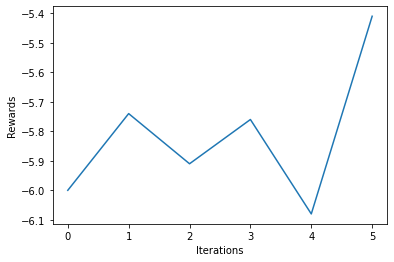

  1%|▍                                                                          | 603/100000 [00:21<1:22:34, 20.06it/s]

Updated Weights
Mean Reward = -5.58
14


  1%|▌                                                                          | 704/100000 [00:26<1:17:29, 21.36it/s]

Updated Weights
Mean Reward = -3.06
31


  1%|▌                                                                          | 802/100000 [00:31<1:35:01, 17.40it/s]

Updated Weights
Mean Reward = -3.39
25


  1%|▋                                                                          | 902/100000 [00:37<1:46:48, 15.46it/s]

Updated Weights
Mean Reward = -2.91
26


  1%|▋                                                                          | 999/100000 [00:43<1:43:35, 15.93it/s]

Updated Weights
Mean Reward = -4.2
21


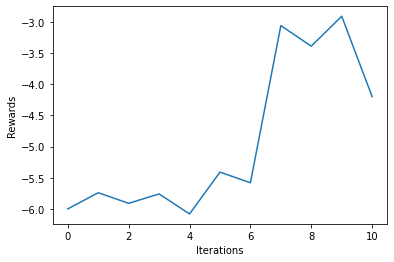

  1%|▊                                                                         | 1103/100000 [00:50<1:44:14, 15.81it/s]

Updated Weights
Mean Reward = -1.7
31


  1%|▉                                                                         | 1203/100000 [00:57<1:48:07, 15.23it/s]

Updated Weights
Mean Reward = -1.32
36


  1%|▉                                                                         | 1303/100000 [01:04<1:48:55, 15.10it/s]

Updated Weights
Mean Reward = -2.23
26


  1%|█                                                                         | 1402/100000 [01:11<2:14:01, 12.26it/s]

Updated Weights
Mean Reward = -0.18
38


  2%|█                                                                         | 1500/100000 [01:18<2:04:38, 13.17it/s]

Updated Weights
Mean Reward = 1.99
34


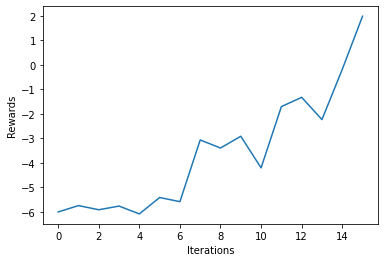

  2%|█▏                                                                        | 1602/100000 [01:26<2:16:55, 11.98it/s]

Updated Weights
Mean Reward = 1.72
44


  2%|█▎                                                                        | 1703/100000 [01:34<1:49:56, 14.90it/s]

Updated Weights
Mean Reward = 2.37
42


  2%|█▎                                                                        | 1802/100000 [01:42<2:17:50, 11.87it/s]

Updated Weights
Mean Reward = -0.8
39


  2%|█▍                                                                        | 1902/100000 [01:50<2:01:05, 13.50it/s]

Updated Weights
Mean Reward = 0.65
41


  2%|█▍                                                                        | 2000/100000 [01:58<2:20:47, 11.60it/s]

Updated Weights
Mean Reward = 1.78
47


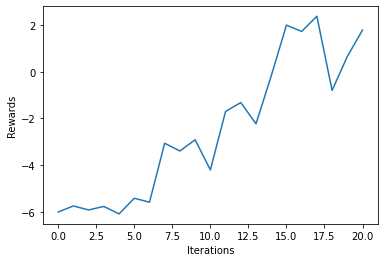

  2%|█▌                                                                        | 2103/100000 [02:06<1:50:48, 14.73it/s]

Updated Weights
Mean Reward = 1.92
53


  2%|█▋                                                                        | 2203/100000 [02:15<2:26:25, 11.13it/s]

Updated Weights
Mean Reward = 0.57
38


  2%|█▋                                                                        | 2302/100000 [02:24<2:24:28, 11.27it/s]

Updated Weights
Mean Reward = 1.82
43


  2%|█▊                                                                        | 2403/100000 [02:34<2:33:32, 10.59it/s]

Updated Weights
Mean Reward = 0.44
28


  2%|█▊                                                                        | 2499/100000 [02:43<2:30:51, 10.77it/s]

Updated Weights
Mean Reward = 1.12
31


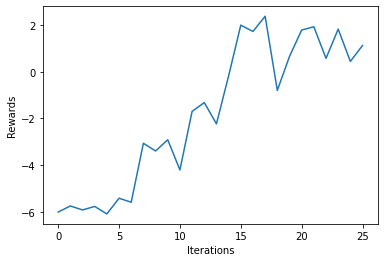

  3%|█▉                                                                        | 2602/100000 [02:54<3:10:13,  8.53it/s]

Updated Weights
Mean Reward = 2.36
34


  3%|█▉                                                                        | 2702/100000 [03:05<3:03:38,  8.83it/s]

Updated Weights
Mean Reward = -2.63
12


  3%|██                                                                        | 2802/100000 [03:16<3:10:19,  8.51it/s]

Updated Weights
Mean Reward = 1.92
14


  3%|██▏                                                                       | 2903/100000 [03:28<3:02:59,  8.84it/s]

Updated Weights
Mean Reward = 0.09
19


  3%|██▏                                                                       | 3000/100000 [03:39<3:04:01,  8.79it/s]

Updated Weights
Mean Reward = 3.35
34


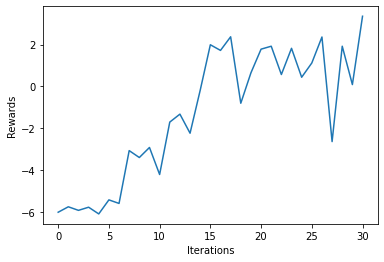

  3%|██▎                                                                       | 3102/100000 [03:53<3:30:53,  7.66it/s]

Updated Weights
Mean Reward = -0.33
14


  3%|██▎                                                                       | 3202/100000 [04:05<3:30:08,  7.68it/s]

Updated Weights
Mean Reward = -5.64
9


  3%|██▍                                                                       | 3302/100000 [04:18<3:30:47,  7.65it/s]

Updated Weights
Mean Reward = -3.91
11


  3%|██▌                                                                       | 3402/100000 [04:29<3:31:51,  7.60it/s]

Updated Weights
Mean Reward = 0.91
22


  4%|██▌                                                                       | 3500/100000 [04:41<3:15:28,  8.23it/s]

Updated Weights
Mean Reward = 0.94
24


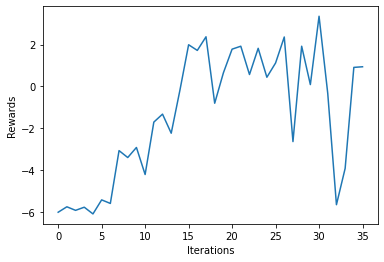

  4%|██▋                                                                       | 3602/100000 [04:54<3:31:43,  7.59it/s]

Updated Weights
Mean Reward = 1.07
20


  4%|██▋                                                                       | 3702/100000 [05:05<3:29:27,  7.66it/s]

Updated Weights
Mean Reward = 1.95
29


  4%|██▊                                                                       | 3802/100000 [05:18<3:25:21,  7.81it/s]

Updated Weights
Mean Reward = 1.92
18


  4%|██▉                                                                       | 3902/100000 [05:30<3:39:36,  7.29it/s]

Updated Weights
Mean Reward = 0.17
22


  4%|██▉                                                                       | 4000/100000 [05:43<3:35:46,  7.42it/s]

Updated Weights
Mean Reward = 1.85
16


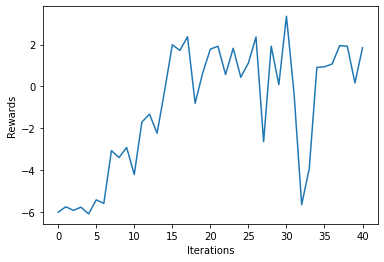

  4%|███                                                                       | 4102/100000 [05:56<3:45:22,  7.09it/s]

Updated Weights
Mean Reward = 1.7
20


  4%|███                                                                       | 4202/100000 [06:08<3:25:54,  7.75it/s]

Updated Weights
Mean Reward = 4.26
29


  4%|███▏                                                                      | 4302/100000 [06:20<3:50:30,  6.92it/s]

Updated Weights
Mean Reward = 5.45
40


  4%|███▎                                                                      | 4402/100000 [06:32<3:33:15,  7.47it/s]

Updated Weights
Mean Reward = 3.35
29


  4%|███▎                                                                      | 4500/100000 [06:44<3:49:44,  6.93it/s]

Updated Weights
Mean Reward = 3.81
31


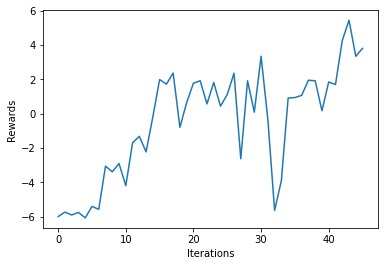

  5%|███▍                                                                      | 4602/100000 [06:57<3:26:25,  7.70it/s]

Updated Weights
Mean Reward = 0.11
22


  5%|███▍                                                                      | 4702/100000 [07:11<3:51:12,  6.87it/s]

Updated Weights
Mean Reward = 4.13
12


  5%|███▌                                                                      | 4802/100000 [07:24<3:53:26,  6.80it/s]

Updated Weights
Mean Reward = 2.29
17


  5%|███▋                                                                      | 4902/100000 [07:38<3:55:16,  6.74it/s]

Updated Weights
Mean Reward = -8.48
10


  5%|███▋                                                                      | 5000/100000 [07:51<3:35:34,  7.34it/s]

Updated Weights
Mean Reward = 0.82
13


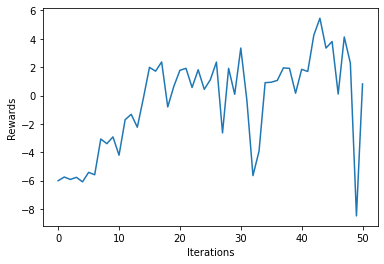

  5%|███▊                                                                      | 5101/100000 [08:07<5:14:54,  5.02it/s]

Updated Weights
Mean Reward = -1.23
13


  5%|███▊                                                                      | 5203/100000 [08:22<3:17:52,  7.98it/s]

Updated Weights
Mean Reward = 1.45
18


  5%|███▉                                                                      | 5301/100000 [08:37<3:55:45,  6.69it/s]

Updated Weights
Mean Reward = 1.23
15


  5%|███▉                                                                      | 5402/100000 [08:53<4:02:54,  6.49it/s]

Updated Weights
Mean Reward = 2.11
17


  6%|████                                                                      | 5500/100000 [09:09<4:31:54,  5.79it/s]

Updated Weights
Mean Reward = 2.44
8


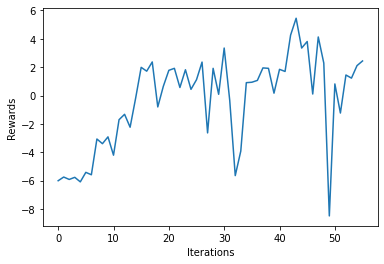

  6%|████▏                                                                     | 5602/100000 [09:25<3:17:04,  7.98it/s]

Updated Weights
Mean Reward = 3.45
13


  6%|████▏                                                                     | 5702/100000 [09:39<3:48:45,  6.87it/s]

Updated Weights
Mean Reward = 2.81
14


  6%|████▎                                                                     | 5802/100000 [09:54<4:01:22,  6.50it/s]

Updated Weights
Mean Reward = 6.51
15


  6%|████▎                                                                     | 5902/100000 [10:09<3:45:06,  6.97it/s]

Updated Weights
Mean Reward = -1.23
11


  6%|████▍                                                                     | 6000/100000 [10:25<3:50:13,  6.80it/s]

Updated Weights
Mean Reward = -2.93
5


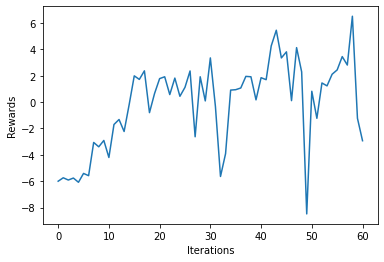

  6%|████▌                                                                     | 6102/100000 [10:40<4:07:27,  6.32it/s]

Updated Weights
Mean Reward = -4.87
4


  6%|████▌                                                                     | 6202/100000 [10:56<3:56:16,  6.62it/s]

Updated Weights
Mean Reward = 2.24
10


  6%|████▋                                                                     | 6301/100000 [11:11<3:57:26,  6.58it/s]

Updated Weights
Mean Reward = 0.94
7


  6%|████▋                                                                     | 6401/100000 [11:25<3:59:35,  6.51it/s]

Updated Weights
Mean Reward = 0.71
10


  6%|████▊                                                                     | 6500/100000 [11:41<4:45:43,  5.45it/s]

Updated Weights
Mean Reward = 2.11
12


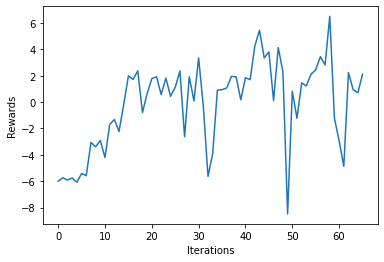

  7%|████▉                                                                     | 6601/100000 [11:57<4:20:40,  5.97it/s]

Updated Weights
Mean Reward = 1.62
12


  7%|████▉                                                                     | 6702/100000 [12:12<3:47:25,  6.84it/s]

Updated Weights
Mean Reward = 1.8
8


  7%|█████                                                                     | 6802/100000 [12:29<4:11:11,  6.18it/s]

Updated Weights
Mean Reward = 2.41
8


  7%|█████                                                                     | 6902/100000 [12:46<4:04:18,  6.35it/s]

Updated Weights
Mean Reward = 1.85
15


  7%|█████▏                                                                    | 7000/100000 [13:01<4:10:04,  6.20it/s]

Updated Weights
Mean Reward = 2.37
12


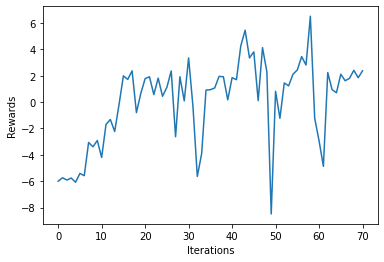

  7%|█████▎                                                                    | 7102/100000 [13:17<2:58:09,  8.69it/s]

Updated Weights
Mean Reward = 3.06
10


  7%|█████▎                                                                    | 7202/100000 [13:32<4:09:41,  6.19it/s]

Updated Weights
Mean Reward = 2.32
9


  7%|█████▍                                                                    | 7302/100000 [13:47<4:03:55,  6.33it/s]

Updated Weights
Mean Reward = 5.65
21


  7%|█████▍                                                                    | 7403/100000 [14:00<3:26:06,  7.49it/s]

Updated Weights
Mean Reward = 4.0
22


  8%|█████▌                                                                    | 7500/100000 [14:14<3:42:51,  6.92it/s]

Updated Weights
Mean Reward = 4.91
25


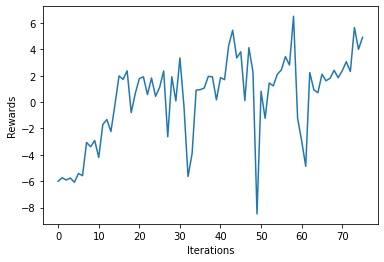

  8%|█████▋                                                                    | 7603/100000 [14:28<3:28:35,  7.38it/s]

Updated Weights
Mean Reward = 4.39
20


  8%|█████▋                                                                    | 7702/100000 [14:43<3:51:20,  6.65it/s]

Updated Weights
Mean Reward = 6.35
18


  8%|█████▊                                                                    | 7802/100000 [14:55<2:51:41,  8.95it/s]

Updated Weights
Mean Reward = 9.2
43


  8%|█████▊                                                                    | 7902/100000 [15:09<4:07:34,  6.20it/s]

Updated Weights
Mean Reward = -0.99
16


  8%|█████▉                                                                    | 8000/100000 [15:23<4:01:37,  6.35it/s]

Updated Weights
Mean Reward = -1.0
12


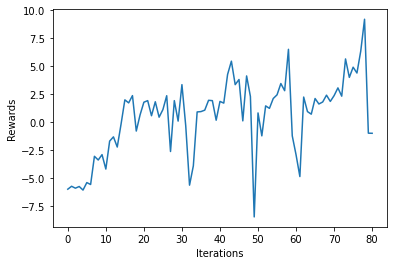

  8%|█████▉                                                                    | 8102/100000 [15:39<4:07:02,  6.20it/s]

Updated Weights
Mean Reward = 3.99
9


  8%|██████                                                                    | 8202/100000 [15:54<4:04:48,  6.25it/s]

Updated Weights
Mean Reward = 1.78
11


  8%|██████▏                                                                   | 8302/100000 [16:08<4:05:09,  6.23it/s]

Updated Weights
Mean Reward = 3.97
18


  8%|██████▏                                                                   | 8402/100000 [16:23<4:07:35,  6.17it/s]

Updated Weights
Mean Reward = 5.34
14


  8%|██████▎                                                                   | 8500/100000 [16:38<4:01:43,  6.31it/s]

Updated Weights
Mean Reward = 4.7
11


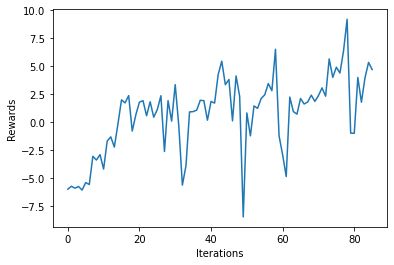

  9%|██████▎                                                                   | 8602/100000 [16:52<4:01:02,  6.32it/s]

Updated Weights
Mean Reward = 6.03
21


  9%|██████▍                                                                   | 8702/100000 [17:05<3:56:01,  6.45it/s]

Updated Weights
Mean Reward = 2.95
20


  9%|██████▌                                                                   | 8800/100000 [17:20<3:55:41,  6.45it/s]

Updated Weights
Mean Reward = 3.2
16


  9%|██████▌                                                                   | 8902/100000 [17:34<3:55:55,  6.44it/s]

Updated Weights
Mean Reward = 2.77
13


  9%|██████▋                                                                   | 9000/100000 [17:49<3:55:51,  6.43it/s]

Updated Weights
Mean Reward = -0.97
15


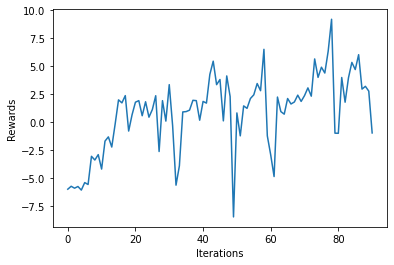

  9%|██████▋                                                                   | 9102/100000 [18:04<4:08:41,  6.09it/s]

Updated Weights
Mean Reward = 1.92
15


  9%|██████▊                                                                   | 9202/100000 [18:19<3:59:23,  6.32it/s]

Updated Weights
Mean Reward = 2.14
12


  9%|██████▉                                                                   | 9302/100000 [18:34<3:36:25,  6.98it/s]

Updated Weights
Mean Reward = 3.29
13


  9%|██████▉                                                                   | 9402/100000 [18:49<3:30:04,  7.19it/s]

Updated Weights
Mean Reward = 3.44
12


 10%|███████                                                                   | 9500/100000 [19:03<4:02:23,  6.22it/s]

Updated Weights
Mean Reward = 2.75
17


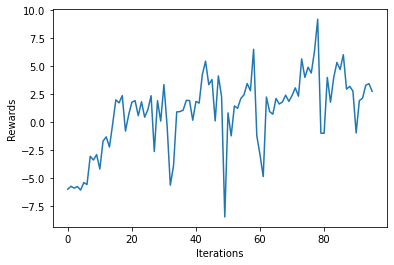

 10%|███████                                                                   | 9602/100000 [19:18<4:01:32,  6.24it/s]

Updated Weights
Mean Reward = -1.05
9


 10%|███████▏                                                                  | 9702/100000 [19:33<3:58:23,  6.31it/s]

Updated Weights
Mean Reward = 4.72
9


 10%|███████▎                                                                  | 9802/100000 [19:49<4:07:44,  6.07it/s]

Updated Weights
Mean Reward = 6.98
6


 10%|███████▎                                                                  | 9902/100000 [20:05<4:00:45,  6.24it/s]

Updated Weights
Mean Reward = 3.84
0


 10%|███████▎                                                                 | 10000/100000 [20:21<4:02:10,  6.19it/s]

Updated Weights
Mean Reward = 1.08
2


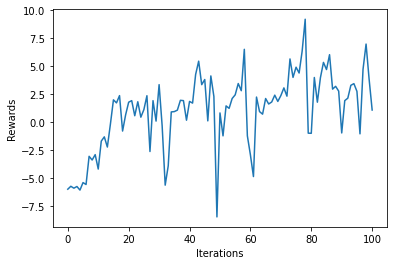

 10%|███████▎                                                                 | 10102/100000 [20:38<4:07:29,  6.05it/s]

Updated Weights
Mean Reward = -7.6
0


 10%|███████▍                                                                 | 10202/100000 [20:54<4:01:35,  6.19it/s]

Updated Weights
Mean Reward = -1.3
3


 10%|███████▌                                                                 | 10302/100000 [21:10<4:02:31,  6.16it/s]

Updated Weights
Mean Reward = 0.29
1


 10%|███████▌                                                                 | 10402/100000 [21:26<4:05:29,  6.08it/s]

Updated Weights
Mean Reward = -2.16
2


 10%|███████▋                                                                 | 10500/100000 [21:41<4:10:34,  5.95it/s]

Updated Weights
Mean Reward = -1.97
4


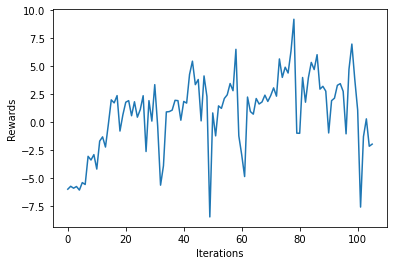

 11%|███████▋                                                                 | 10602/100000 [21:58<4:01:49,  6.16it/s]

Updated Weights
Mean Reward = -4.75
3


 11%|███████▊                                                                 | 10702/100000 [22:13<4:09:26,  5.97it/s]

Updated Weights
Mean Reward = -24.2
7


 11%|███████▉                                                                 | 10802/100000 [22:29<4:04:59,  6.07it/s]

Updated Weights
Mean Reward = -8.76
3


 11%|███████▉                                                                 | 10902/100000 [22:45<4:03:04,  6.11it/s]

Updated Weights
Mean Reward = -16.97
4


 11%|████████                                                                 | 11000/100000 [23:00<4:02:35,  6.11it/s]

Updated Weights
Mean Reward = -12.51
5


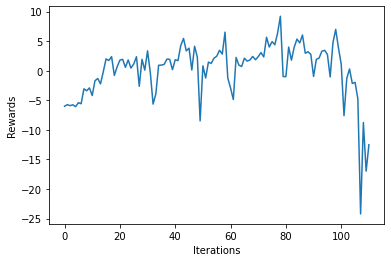

 11%|████████                                                                 | 11102/100000 [23:17<4:03:05,  6.10it/s]

Updated Weights
Mean Reward = -31.44
1


 11%|████████▏                                                                | 11202/100000 [23:33<3:54:02,  6.32it/s]

Updated Weights
Mean Reward = -15.25
3


 11%|████████▎                                                                | 11302/100000 [23:49<4:01:47,  6.11it/s]

Updated Weights
Mean Reward = -9.2
2


 11%|████████▎                                                                | 11402/100000 [24:05<4:00:20,  6.14it/s]

Updated Weights
Mean Reward = -9.9
4


 12%|████████▍                                                                | 11500/100000 [24:21<4:02:09,  6.09it/s]

Updated Weights
Mean Reward = -9.17
2


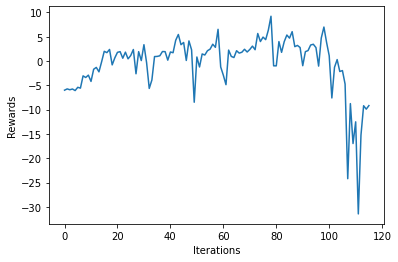

 12%|████████▍                                                                | 11602/100000 [24:38<4:00:50,  6.12it/s]

Updated Weights
Mean Reward = -6.26
0


 12%|████████▌                                                                | 11702/100000 [24:54<4:09:49,  5.89it/s]

Updated Weights
Mean Reward = -8.07
3


 12%|████████▌                                                                | 11802/100000 [25:12<3:51:40,  6.34it/s]

Updated Weights
Mean Reward = -5.42
7


 12%|████████▋                                                                | 11902/100000 [25:29<4:11:12,  5.84it/s]

Updated Weights
Mean Reward = -7.56
3


 12%|████████▊                                                                | 12000/100000 [25:45<4:34:41,  5.34it/s]

Updated Weights
Mean Reward = -5.93
2


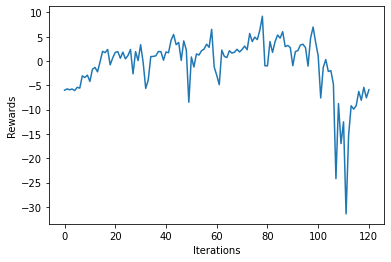

 12%|████████▊                                                                | 12102/100000 [26:03<4:09:43,  5.87it/s]

Updated Weights
Mean Reward = -6.68
3


 12%|████████▉                                                                | 12202/100000 [26:15<2:57:39,  8.24it/s]

Updated Weights
Mean Reward = -4.67
5


 12%|████████▉                                                                | 12302/100000 [26:26<2:42:25,  9.00it/s]

Updated Weights
Mean Reward = -5.39
1


 12%|█████████                                                                | 12402/100000 [26:37<2:44:20,  8.88it/s]

Updated Weights
Mean Reward = -6.83
3


 12%|█████████                                                                | 12499/100000 [26:48<2:21:27, 10.31it/s]

Updated Weights
Mean Reward = -3.94
5


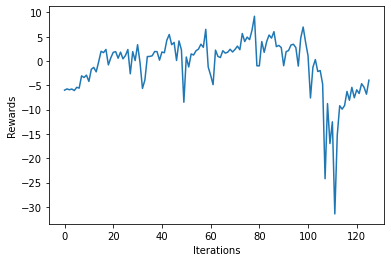

 13%|█████████▏                                                               | 12602/100000 [26:59<2:51:53,  8.47it/s]

Updated Weights
Mean Reward = -4.84
6


 13%|█████████▎                                                               | 12702/100000 [27:12<3:35:04,  6.77it/s]

Updated Weights
Mean Reward = -3.36
2


 13%|█████████▎                                                               | 12802/100000 [27:24<2:41:12,  9.02it/s]

Updated Weights
Mean Reward = -6.38
1


 13%|█████████▍                                                               | 12900/100000 [27:35<2:26:14,  9.93it/s]

Updated Weights
Mean Reward = -5.33
5


 13%|█████████▍                                                               | 13000/100000 [27:46<2:30:38,  9.63it/s]

Updated Weights
Mean Reward = -3.91
4


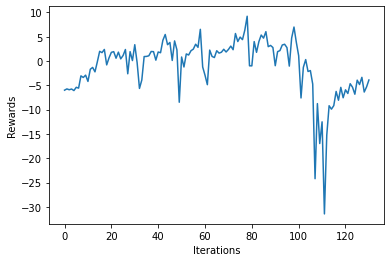

 13%|█████████▌                                                               | 13102/100000 [27:57<2:25:17,  9.97it/s]

Updated Weights
Mean Reward = -5.14
5


 13%|█████████▋                                                               | 13202/100000 [28:07<2:39:29,  9.07it/s]

Updated Weights
Mean Reward = -4.51
1


 13%|█████████▋                                                               | 13302/100000 [28:18<2:26:51,  9.84it/s]

Updated Weights
Mean Reward = -2.26
5


 13%|█████████▊                                                               | 13402/100000 [28:28<2:34:02,  9.37it/s]

Updated Weights
Mean Reward = -3.61
1


 13%|█████████▊                                                               | 13499/100000 [28:39<2:38:49,  9.08it/s]

Updated Weights
Mean Reward = -4.3
3


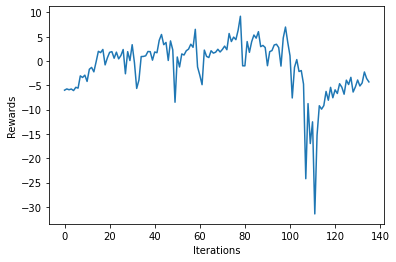

 14%|█████████▉                                                               | 13602/100000 [28:50<2:34:19,  9.33it/s]

Updated Weights
Mean Reward = -3.2
5


 14%|██████████                                                               | 13702/100000 [29:01<2:43:15,  8.81it/s]

Updated Weights
Mean Reward = -2.33
2


 14%|██████████                                                               | 13802/100000 [29:11<2:35:20,  9.25it/s]

Updated Weights
Mean Reward = -1.89
2


 14%|██████████▏                                                              | 13902/100000 [29:22<2:32:47,  9.39it/s]

Updated Weights
Mean Reward = -2.43
2


 14%|██████████▏                                                              | 14000/100000 [29:33<2:38:37,  9.04it/s]

Updated Weights
Mean Reward = -2.27
1


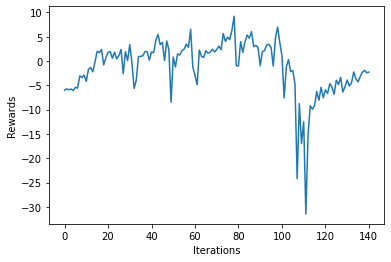

 14%|██████████▎                                                              | 14102/100000 [29:43<2:32:32,  9.38it/s]

Updated Weights
Mean Reward = -1.33
7


 14%|██████████▎                                                              | 14202/100000 [29:54<2:40:00,  8.94it/s]

Updated Weights
Mean Reward = -1.51
1


 14%|██████████▍                                                              | 14302/100000 [30:05<2:39:14,  8.97it/s]

Updated Weights
Mean Reward = -0.18
3


 14%|██████████▌                                                              | 14402/100000 [30:16<2:37:13,  9.07it/s]

Updated Weights
Mean Reward = -2.47
2


 14%|██████████▌                                                              | 14500/100000 [30:26<2:32:35,  9.34it/s]

Updated Weights
Mean Reward = -0.37
2


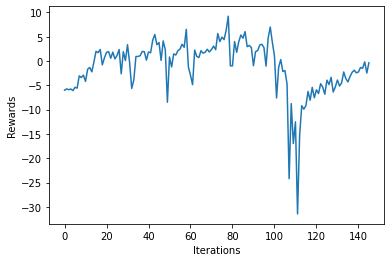

 15%|██████████▋                                                              | 14602/100000 [30:37<2:35:47,  9.14it/s]

Updated Weights
Mean Reward = -1.11
3


 15%|██████████▋                                                              | 14702/100000 [30:48<2:37:47,  9.01it/s]

Updated Weights
Mean Reward = -0.33
4


 15%|██████████▊                                                              | 14803/100000 [30:58<1:58:09, 12.02it/s]

Updated Weights
Mean Reward = -1.67
5


 15%|██████████▉                                                              | 14902/100000 [31:09<2:36:57,  9.04it/s]

Updated Weights
Mean Reward = 0.3
5


 15%|██████████▉                                                              | 15000/100000 [31:19<2:32:30,  9.29it/s]

Updated Weights
Mean Reward = 0.25
5


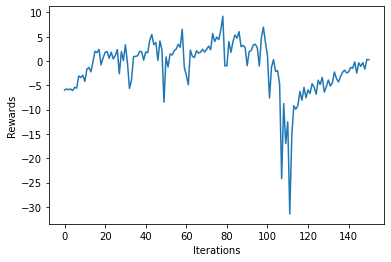

 15%|███████████                                                              | 15102/100000 [31:30<2:37:52,  8.96it/s]

Updated Weights
Mean Reward = -2.02
1


 15%|███████████                                                              | 15202/100000 [31:41<2:39:40,  8.85it/s]

Updated Weights
Mean Reward = -3.42
1


 15%|███████████▏                                                             | 15302/100000 [31:52<3:00:00,  7.84it/s]

Updated Weights
Mean Reward = -0.98
2


 15%|███████████▏                                                             | 15402/100000 [32:02<2:34:51,  9.11it/s]

Updated Weights
Mean Reward = 0.51
6


 15%|███████████▎                                                             | 15499/100000 [32:12<2:35:18,  9.07it/s]

Updated Weights
Mean Reward = -1.03
3


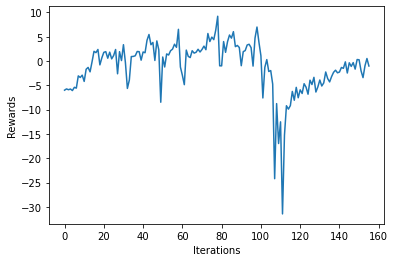

 16%|███████████▍                                                             | 15602/100000 [32:23<2:36:09,  9.01it/s]

Updated Weights
Mean Reward = 0.17
3


 16%|███████████▍                                                             | 15702/100000 [32:34<2:41:07,  8.72it/s]

Updated Weights
Mean Reward = -2.18
0


 16%|███████████▌                                                             | 15802/100000 [32:45<2:34:59,  9.05it/s]

Updated Weights
Mean Reward = 0.29
7


 16%|███████████▌                                                             | 15902/100000 [32:55<2:48:21,  8.33it/s]

Updated Weights
Mean Reward = -2.47
2


 16%|███████████▋                                                             | 15999/100000 [33:06<2:33:20,  9.13it/s]

Updated Weights
Mean Reward = -4.28
0


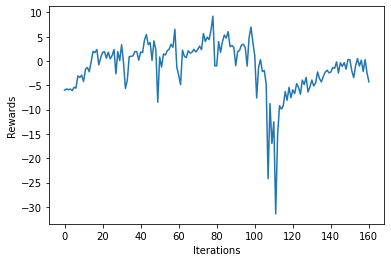

 16%|███████████▊                                                             | 16102/100000 [33:17<2:35:11,  9.01it/s]

Updated Weights
Mean Reward = -0.47
1


 16%|███████████▊                                                             | 16201/100000 [33:27<2:30:56,  9.25it/s]

Updated Weights
Mean Reward = 0.17
5


 16%|███████████▉                                                             | 16301/100000 [33:38<2:13:09, 10.48it/s]

Updated Weights
Mean Reward = -0.61
2


 16%|███████████▉                                                             | 16402/100000 [33:49<2:29:19,  9.33it/s]

Updated Weights
Mean Reward = -0.01
5


 16%|████████████                                                             | 16500/100000 [33:59<2:28:36,  9.36it/s]

Updated Weights
Mean Reward = -0.8
5


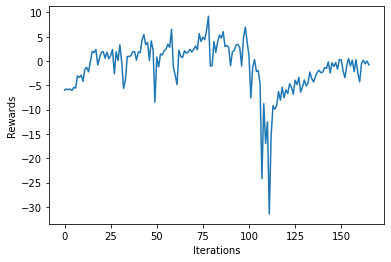

 17%|████████████                                                             | 16602/100000 [34:09<2:35:03,  8.96it/s]

Updated Weights
Mean Reward = -2.17
4


 17%|████████████▏                                                            | 16702/100000 [34:20<2:28:40,  9.34it/s]

Updated Weights
Mean Reward = -1.21
4


 17%|████████████▎                                                            | 16802/100000 [34:31<3:11:34,  7.24it/s]

Updated Weights
Mean Reward = 0.67
7


 17%|████████████▎                                                            | 16902/100000 [34:50<4:39:53,  4.95it/s]

Updated Weights
Mean Reward = -0.51
3


 17%|████████████▍                                                            | 17000/100000 [35:06<3:32:14,  6.52it/s]

Updated Weights
Mean Reward = -0.79
6


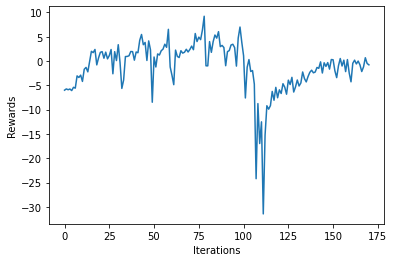

 17%|████████████▍                                                            | 17102/100000 [35:17<2:50:05,  8.12it/s]

Updated Weights
Mean Reward = -0.3
7


 17%|████████████▌                                                            | 17202/100000 [35:29<2:34:52,  8.91it/s]

Updated Weights
Mean Reward = 0.03
6


 17%|████████████▋                                                            | 17302/100000 [35:40<2:38:15,  8.71it/s]

Updated Weights
Mean Reward = -0.45
1


 17%|████████████▋                                                            | 17402/100000 [35:51<2:34:30,  8.91it/s]

Updated Weights
Mean Reward = -0.12
7


 17%|████████████▊                                                            | 17499/100000 [36:01<2:32:04,  9.04it/s]

Updated Weights
Mean Reward = -1.37
2


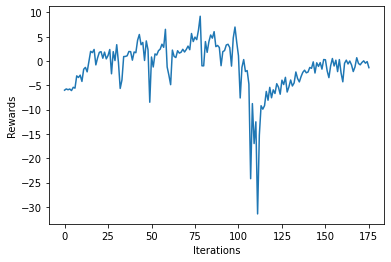

 18%|████████████▊                                                            | 17601/100000 [36:12<2:33:34,  8.94it/s]

Updated Weights
Mean Reward = -0.06
5


 18%|████████████▉                                                            | 17702/100000 [36:23<2:36:18,  8.78it/s]

Updated Weights
Mean Reward = 0.58
6


 18%|████████████▉                                                            | 17802/100000 [36:33<2:20:47,  9.73it/s]

Updated Weights
Mean Reward = -0.97
7


 18%|█████████████                                                            | 17902/100000 [36:44<2:33:47,  8.90it/s]

Updated Weights
Mean Reward = -0.45
3


 18%|█████████████▏                                                           | 17999/100000 [36:54<2:25:03,  9.42it/s]

Updated Weights
Mean Reward = 0.03
4


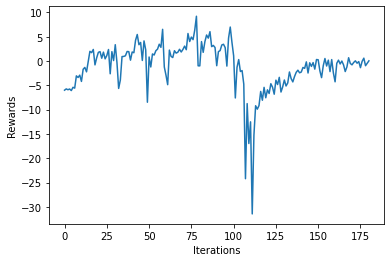

 18%|█████████████▏                                                           | 18101/100000 [37:05<2:12:15, 10.32it/s]

Updated Weights
Mean Reward = -0.59
2


 18%|█████████████▎                                                           | 18203/100000 [37:16<2:12:12, 10.31it/s]

Updated Weights
Mean Reward = -0.52
2


 18%|█████████████▎                                                           | 18302/100000 [37:26<2:16:58,  9.94it/s]

Updated Weights
Mean Reward = 0.06
5


 18%|█████████████▍                                                           | 18402/100000 [37:37<2:26:02,  9.31it/s]

Updated Weights
Mean Reward = -0.84
1


 18%|█████████████▌                                                           | 18500/100000 [37:48<2:28:30,  9.15it/s]

Updated Weights
Mean Reward = -0.92
1


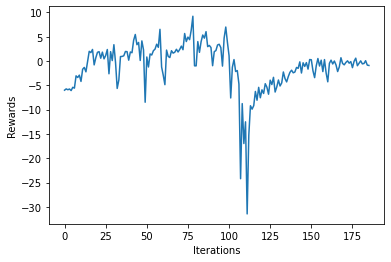

 19%|█████████████▌                                                           | 18602/100000 [37:59<2:28:53,  9.11it/s]

Updated Weights
Mean Reward = -1.62
4


 19%|█████████████▋                                                           | 18702/100000 [38:10<2:35:04,  8.74it/s]

Updated Weights
Mean Reward = -2.62
0


 19%|█████████████▋                                                           | 18802/100000 [38:20<2:26:19,  9.25it/s]

Updated Weights
Mean Reward = -0.63
2


 19%|█████████████▊                                                           | 18902/100000 [38:31<2:30:22,  8.99it/s]

Updated Weights
Mean Reward = -2.23
1


 19%|█████████████▊                                                           | 19000/100000 [38:42<2:28:42,  9.08it/s]

Updated Weights
Mean Reward = -0.82
3


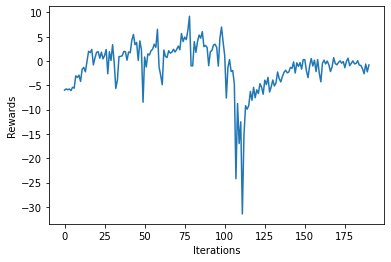

 19%|█████████████▉                                                           | 19102/100000 [38:52<2:30:39,  8.95it/s]

Updated Weights
Mean Reward = 0.99
4


 19%|██████████████                                                           | 19202/100000 [39:03<2:20:16,  9.60it/s]

Updated Weights
Mean Reward = -2.09
4


 19%|██████████████                                                           | 19302/100000 [39:14<2:19:44,  9.62it/s]

Updated Weights
Mean Reward = -1.51
2


 19%|██████████████▏                                                          | 19402/100000 [39:24<2:30:25,  8.93it/s]

Updated Weights
Mean Reward = -1.28
2


 20%|██████████████▏                                                          | 19500/100000 [39:35<2:26:18,  9.17it/s]

Updated Weights
Mean Reward = -0.35
3


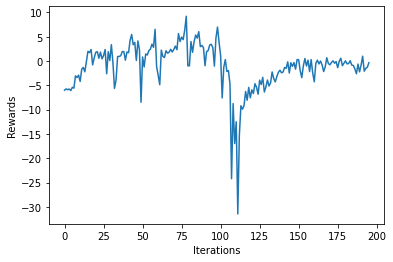

 20%|██████████████▎                                                          | 19602/100000 [39:46<2:17:02,  9.78it/s]

Updated Weights
Mean Reward = -0.45
2


 20%|██████████████▍                                                          | 19702/100000 [39:57<2:26:16,  9.15it/s]

Updated Weights
Mean Reward = -0.26
0


 20%|██████████████▍                                                          | 19801/100000 [40:07<2:05:36, 10.64it/s]

Updated Weights
Mean Reward = -0.61
3


 20%|██████████████▌                                                          | 19901/100000 [40:18<2:24:48,  9.22it/s]

Updated Weights
Mean Reward = -1.32
4


 20%|██████████████▌                                                          | 20000/100000 [40:28<2:06:33, 10.54it/s]

Updated Weights
Mean Reward = 0.42
5


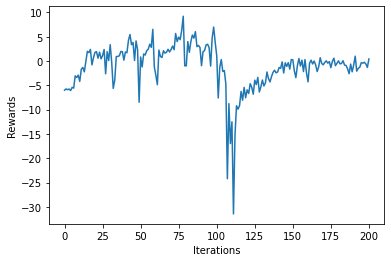

 20%|██████████████▋                                                          | 20102/100000 [40:39<2:25:27,  9.16it/s]

Updated Weights
Mean Reward = -2.81
4


 20%|██████████████▋                                                          | 20202/100000 [40:50<2:23:05,  9.29it/s]

Updated Weights
Mean Reward = -0.87
1


 20%|██████████████▊                                                          | 20301/100000 [41:00<2:15:33,  9.80it/s]

Updated Weights
Mean Reward = 0.57
6


 20%|██████████████▉                                                          | 20402/100000 [41:11<2:11:46, 10.07it/s]

Updated Weights
Mean Reward = -0.7
2


 20%|██████████████▉                                                          | 20499/100000 [41:21<2:14:26,  9.86it/s]

Updated Weights
Mean Reward = 0.04
3


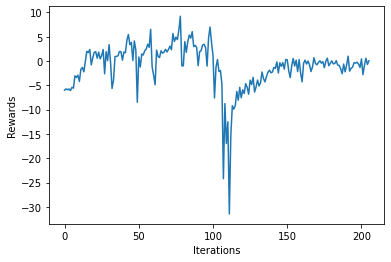

 21%|███████████████                                                          | 20602/100000 [41:32<2:27:09,  8.99it/s]

Updated Weights
Mean Reward = -0.87
3


 21%|███████████████                                                          | 20701/100000 [41:43<2:31:02,  8.75it/s]

Updated Weights
Mean Reward = -1.03
1


 21%|███████████████▏                                                         | 20802/100000 [41:54<2:14:58,  9.78it/s]

Updated Weights
Mean Reward = -0.79
4


 21%|███████████████▎                                                         | 20902/100000 [42:04<2:23:22,  9.20it/s]

Updated Weights
Mean Reward = -0.38
3


 21%|███████████████▎                                                         | 21000/100000 [42:15<2:23:31,  9.17it/s]

Updated Weights
Mean Reward = -1.28
2


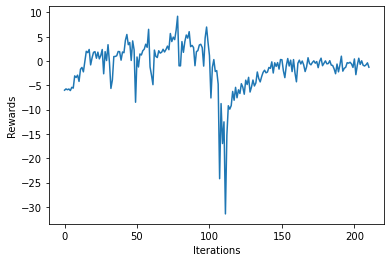

 21%|███████████████▍                                                         | 21102/100000 [42:26<2:46:02,  7.92it/s]

Updated Weights
Mean Reward = -1.66
1


 21%|███████████████▍                                                         | 21201/100000 [42:42<4:14:58,  5.15it/s]

Updated Weights
Mean Reward = 0.0
2


 21%|███████████████▌                                                         | 21302/100000 [42:55<2:37:26,  8.33it/s]

Updated Weights
Mean Reward = -1.76
4


 21%|███████████████▌                                                         | 21402/100000 [43:07<2:24:21,  9.07it/s]

Updated Weights
Mean Reward = -0.71
4


 21%|███████████████▋                                                         | 21499/100000 [43:17<2:09:43, 10.09it/s]

Updated Weights
Mean Reward = -1.75
3


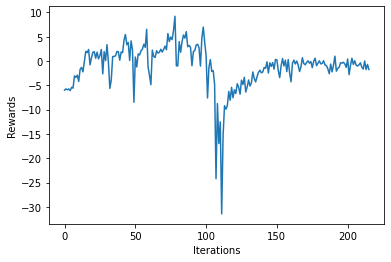

 22%|███████████████▊                                                         | 21601/100000 [43:28<2:15:27,  9.65it/s]

Updated Weights
Mean Reward = 0.24
3


 22%|███████████████▊                                                         | 21702/100000 [43:39<3:00:14,  7.24it/s]

Updated Weights
Mean Reward = -0.73
4


 22%|███████████████▉                                                         | 21801/100000 [43:49<2:13:13,  9.78it/s]

Updated Weights
Mean Reward = 0.66
4


 22%|███████████████▉                                                         | 21902/100000 [44:00<2:24:22,  9.02it/s]

Updated Weights
Mean Reward = -0.16
4


 22%|████████████████                                                         | 22000/100000 [44:12<3:03:22,  7.09it/s]

Updated Weights
Mean Reward = -1.07
2


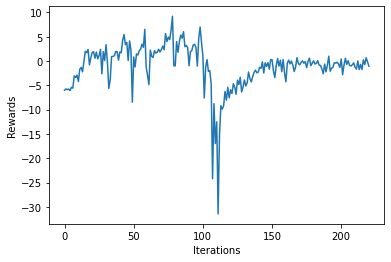

 22%|████████████████▏                                                        | 22102/100000 [44:23<3:06:37,  6.96it/s]

Updated Weights
Mean Reward = -0.64
4


 22%|████████████████▏                                                        | 22202/100000 [44:35<2:23:14,  9.05it/s]

Updated Weights
Mean Reward = 0.2
1


 22%|████████████████▎                                                        | 22302/100000 [44:46<2:30:53,  8.58it/s]

Updated Weights
Mean Reward = -0.66
3


 22%|████████████████▎                                                        | 22401/100000 [44:57<2:24:43,  8.94it/s]

Updated Weights
Mean Reward = 0.01
5


 22%|████████████████▍                                                        | 22500/100000 [45:10<3:26:51,  6.24it/s]

Updated Weights
Mean Reward = -1.9
3


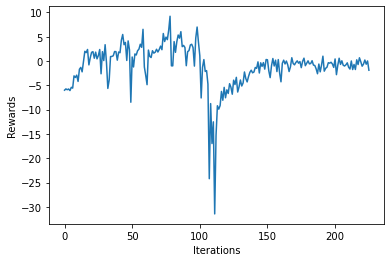

 23%|████████████████▍                                                        | 22602/100000 [45:26<3:24:52,  6.30it/s]

Updated Weights
Mean Reward = 0.6
3


 23%|████████████████▌                                                        | 22702/100000 [45:39<2:20:05,  9.20it/s]

Updated Weights
Mean Reward = 0.45
3


 23%|████████████████▋                                                        | 22801/100000 [45:49<2:04:18, 10.35it/s]

Updated Weights
Mean Reward = -0.58
2


 23%|████████████████▋                                                        | 22902/100000 [46:00<2:15:58,  9.45it/s]

Updated Weights
Mean Reward = 0.73
5


 23%|████████████████▊                                                        | 23000/100000 [46:10<2:21:02,  9.10it/s]

Updated Weights
Mean Reward = -0.1
2


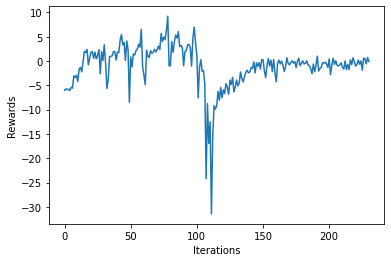

 23%|████████████████▊                                                        | 23102/100000 [46:21<2:18:58,  9.22it/s]

Updated Weights
Mean Reward = -0.58
3


 23%|████████████████▉                                                        | 23203/100000 [46:32<2:17:02,  9.34it/s]

Updated Weights
Mean Reward = 0.17
2


 23%|█████████████████                                                        | 23301/100000 [46:43<2:23:13,  8.93it/s]

Updated Weights
Mean Reward = -1.29
2


 23%|█████████████████                                                        | 23402/100000 [46:54<2:23:09,  8.92it/s]

Updated Weights
Mean Reward = -4.17
2


 24%|█████████████████▏                                                       | 23500/100000 [47:04<2:18:33,  9.20it/s]

Updated Weights
Mean Reward = -2.6
0


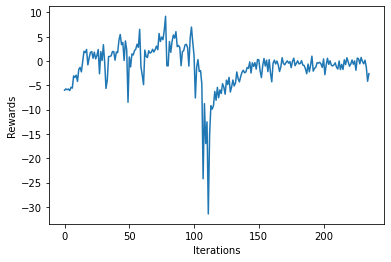

 24%|█████████████████▏                                                       | 23602/100000 [47:17<2:26:29,  8.69it/s]

Updated Weights
Mean Reward = -1.71
5


 24%|█████████████████▎                                                       | 23703/100000 [47:28<2:12:35,  9.59it/s]

Updated Weights
Mean Reward = -0.04
4


 24%|█████████████████▍                                                       | 23802/100000 [47:38<2:15:17,  9.39it/s]

Updated Weights
Mean Reward = -1.82
0


 24%|█████████████████▍                                                       | 23902/100000 [47:49<2:16:41,  9.28it/s]

Updated Weights
Mean Reward = -0.82
9


 24%|█████████████████▌                                                       | 23999/100000 [47:59<2:18:22,  9.15it/s]

Updated Weights
Mean Reward = -1.58
4


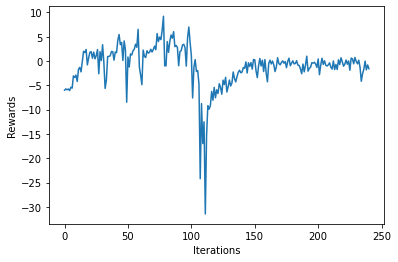

 24%|█████████████████▌                                                       | 24102/100000 [48:10<2:21:36,  8.93it/s]

Updated Weights
Mean Reward = 0.65
7


 24%|█████████████████▋                                                       | 24202/100000 [48:20<2:13:50,  9.44it/s]

Updated Weights
Mean Reward = -1.09
4


 24%|█████████████████▋                                                       | 24302/100000 [48:31<2:00:35, 10.46it/s]

Updated Weights
Mean Reward = -0.75
2


 24%|█████████████████▊                                                       | 24402/100000 [48:42<2:18:34,  9.09it/s]

Updated Weights
Mean Reward = -0.09
1


 24%|█████████████████▉                                                       | 24500/100000 [48:53<2:16:13,  9.24it/s]

Updated Weights
Mean Reward = -0.7
1


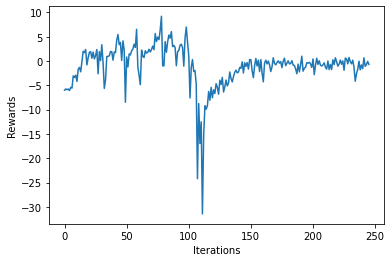

 25%|█████████████████▉                                                       | 24602/100000 [49:04<2:17:06,  9.17it/s]

Updated Weights
Mean Reward = -0.64
2


 25%|██████████████████                                                       | 24702/100000 [49:14<2:12:45,  9.45it/s]

Updated Weights
Mean Reward = -0.46
4


 25%|██████████████████                                                       | 24802/100000 [49:25<2:18:55,  9.02it/s]

Updated Weights
Mean Reward = -1.53
1


 25%|██████████████████▏                                                      | 24902/100000 [49:36<2:15:26,  9.24it/s]

Updated Weights
Mean Reward = -0.04
1


 25%|██████████████████▎                                                      | 25000/100000 [49:47<2:45:13,  7.57it/s]

Updated Weights
Mean Reward = -1.46
1


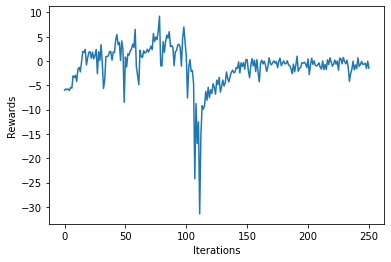

 25%|██████████████████▎                                                      | 25101/100000 [49:59<1:57:07, 10.66it/s]

Updated Weights
Mean Reward = -1.25
3


 25%|██████████████████▍                                                      | 25202/100000 [50:10<2:14:52,  9.24it/s]

Updated Weights
Mean Reward = 0.12
4


 25%|██████████████████▍                                                      | 25302/100000 [50:22<2:20:42,  8.85it/s]

Updated Weights
Mean Reward = -1.87
1


 25%|██████████████████▌                                                      | 25402/100000 [50:33<2:16:48,  9.09it/s]

Updated Weights
Mean Reward = -0.66
2


 26%|██████████████████▌                                                      | 25500/100000 [50:43<2:18:48,  8.95it/s]

Updated Weights
Mean Reward = -0.22
2


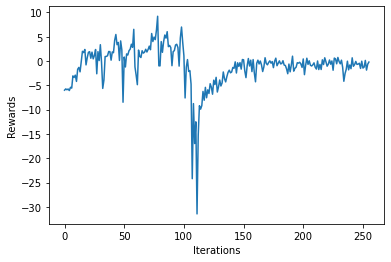

 26%|██████████████████▋                                                      | 25602/100000 [50:54<2:19:47,  8.87it/s]

Updated Weights
Mean Reward = 0.28
4


 26%|██████████████████▊                                                      | 25702/100000 [51:05<2:24:19,  8.58it/s]

Updated Weights
Mean Reward = -0.86
1


 26%|██████████████████▊                                                      | 25802/100000 [51:15<2:04:45,  9.91it/s]

Updated Weights
Mean Reward = -0.35
5


 26%|██████████████████▉                                                      | 25902/100000 [51:26<2:13:04,  9.28it/s]

Updated Weights
Mean Reward = -1.44
0


 26%|██████████████████▉                                                      | 25999/100000 [51:37<2:11:39,  9.37it/s]

Updated Weights
Mean Reward = -0.19
2


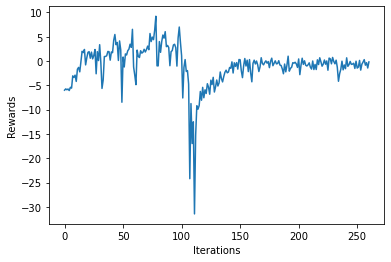

 26%|███████████████████                                                      | 26102/100000 [51:47<2:09:53,  9.48it/s]

Updated Weights
Mean Reward = 0.85
6


 26%|███████████████████▏                                                     | 26202/100000 [51:58<2:14:09,  9.17it/s]

Updated Weights
Mean Reward = -0.01
4


 26%|███████████████████▏                                                     | 26302/100000 [52:09<2:13:26,  9.20it/s]

Updated Weights
Mean Reward = -0.68
0


 26%|███████████████████▎                                                     | 26402/100000 [52:19<2:09:37,  9.46it/s]

Updated Weights
Mean Reward = -1.51
3


 26%|███████████████████▎                                                     | 26500/100000 [52:30<2:17:48,  8.89it/s]

Updated Weights
Mean Reward = -0.38
0


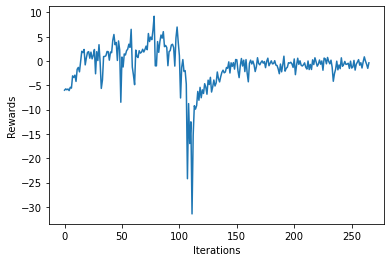

 27%|███████████████████▍                                                     | 26602/100000 [52:41<2:19:55,  8.74it/s]

Updated Weights
Mean Reward = -1.31
2


 27%|███████████████████▍                                                     | 26702/100000 [52:52<2:11:40,  9.28it/s]

Updated Weights
Mean Reward = 0.32
6


 27%|███████████████████▌                                                     | 26802/100000 [53:03<2:16:00,  8.97it/s]

Updated Weights
Mean Reward = -0.14
0


 27%|███████████████████▋                                                     | 26902/100000 [53:14<2:11:06,  9.29it/s]

Updated Weights
Mean Reward = 0.3
1


 27%|███████████████████▋                                                     | 27000/100000 [53:24<2:12:44,  9.17it/s]

Updated Weights
Mean Reward = -0.31
3


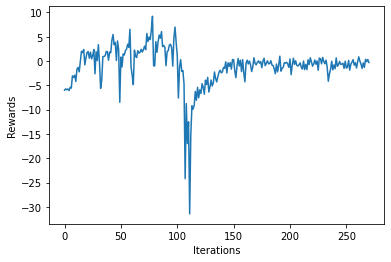

 27%|███████████████████▊                                                     | 27101/100000 [53:35<2:00:47, 10.06it/s]

Updated Weights
Mean Reward = 0.45
4


 27%|███████████████████▊                                                     | 27202/100000 [53:46<2:13:15,  9.10it/s]

Updated Weights
Mean Reward = -0.77
1


 27%|███████████████████▉                                                     | 27302/100000 [53:56<1:57:58, 10.27it/s]

Updated Weights
Mean Reward = -0.31
4


 27%|████████████████████                                                     | 27402/100000 [54:07<2:14:17,  9.01it/s]

Updated Weights
Mean Reward = 0.31
2


 28%|████████████████████                                                     | 27500/100000 [54:17<2:09:56,  9.30it/s]

Updated Weights
Mean Reward = -0.47
6


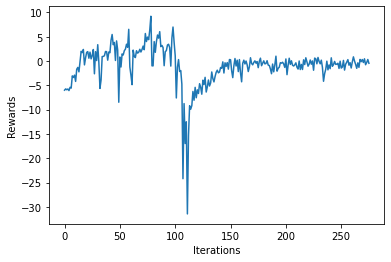

 28%|████████████████████▏                                                    | 27602/100000 [54:28<2:11:45,  9.16it/s]

Updated Weights
Mean Reward = 0.42
6


 28%|████████████████████▏                                                    | 27703/100000 [54:38<2:09:53,  9.28it/s]

Updated Weights
Mean Reward = -0.26
6


 28%|████████████████████▎                                                    | 27801/100000 [54:49<1:54:33, 10.50it/s]

Updated Weights
Mean Reward = -0.47
2


 28%|████████████████████▎                                                    | 27902/100000 [54:59<2:03:38,  9.72it/s]

Updated Weights
Mean Reward = -0.42
1


 28%|████████████████████▍                                                    | 28000/100000 [55:10<2:08:10,  9.36it/s]

Updated Weights
Mean Reward = 0.28
4


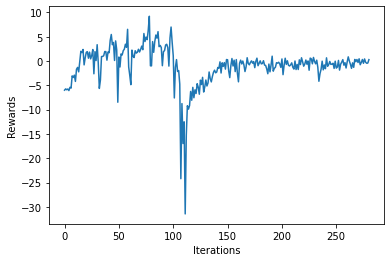

 28%|████████████████████▌                                                    | 28101/100000 [55:20<1:56:24, 10.29it/s]

Updated Weights
Mean Reward = 0.05
2


 28%|████████████████████▌                                                    | 28202/100000 [55:31<2:24:59,  8.25it/s]

Updated Weights
Mean Reward = -0.03
3


 28%|████████████████████▋                                                    | 28302/100000 [55:42<2:14:42,  8.87it/s]

Updated Weights
Mean Reward = 0.11
3


 28%|████████████████████▋                                                    | 28402/100000 [55:53<2:10:27,  9.15it/s]

Updated Weights
Mean Reward = -0.22
0


 28%|████████████████████▊                                                    | 28500/100000 [56:06<3:08:44,  6.31it/s]

Updated Weights
Mean Reward = -0.24
2


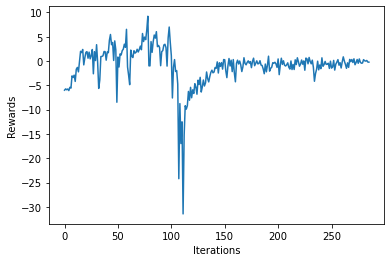

 29%|████████████████████▉                                                    | 28602/100000 [56:22<3:11:16,  6.22it/s]

Updated Weights
Mean Reward = 0.2
3


 29%|████████████████████▉                                                    | 28702/100000 [56:37<2:09:29,  9.18it/s]

Updated Weights
Mean Reward = 0.37
4


 29%|█████████████████████                                                    | 28802/100000 [56:48<2:11:06,  9.05it/s]

Updated Weights
Mean Reward = -0.54
0


 29%|█████████████████████                                                    | 28902/100000 [56:58<2:05:01,  9.48it/s]

Updated Weights
Mean Reward = -4.07
3


 29%|█████████████████████▏                                                   | 29000/100000 [57:08<2:06:52,  9.33it/s]

Updated Weights
Mean Reward = 0.32
6


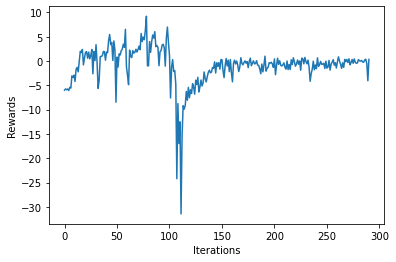

 29%|█████████████████████▏                                                   | 29102/100000 [57:19<2:07:53,  9.24it/s]

Updated Weights
Mean Reward = -0.05
1


 29%|█████████████████████▎                                                   | 29202/100000 [57:29<2:08:50,  9.16it/s]

Updated Weights
Mean Reward = -0.82
4


 29%|█████████████████████▍                                                   | 29302/100000 [57:40<2:05:07,  9.42it/s]

Updated Weights
Mean Reward = -0.38
3


 29%|█████████████████████▍                                                   | 29401/100000 [57:50<1:55:19, 10.20it/s]

Updated Weights
Mean Reward = 0.58
5


 29%|█████████████████████▌                                                   | 29499/100000 [58:00<1:56:35, 10.08it/s]

Updated Weights
Mean Reward = -0.5
3


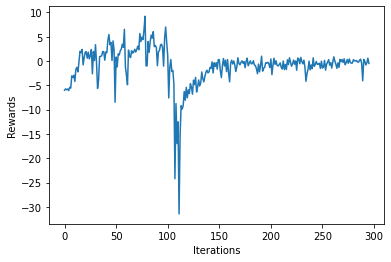

 30%|█████████████████████▌                                                   | 29602/100000 [58:10<2:03:16,  9.52it/s]

Updated Weights
Mean Reward = 1.0
6


 30%|█████████████████████▋                                                   | 29701/100000 [58:21<1:50:31, 10.60it/s]

Updated Weights
Mean Reward = -1.32
4


 30%|█████████████████████▊                                                   | 29802/100000 [58:31<2:04:42,  9.38it/s]

Updated Weights
Mean Reward = 0.66
4


 30%|█████████████████████▊                                                   | 29902/100000 [58:42<2:12:59,  8.78it/s]

Updated Weights
Mean Reward = 0.5
3


 30%|█████████████████████▉                                                   | 30000/100000 [58:52<2:07:58,  9.12it/s]

Updated Weights
Mean Reward = 0.01
3


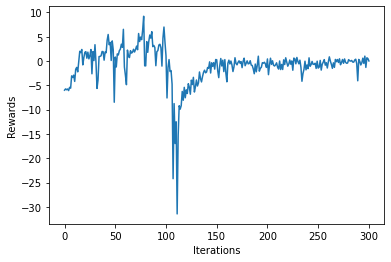

 30%|█████████████████████▉                                                   | 30102/100000 [59:03<2:01:29,  9.59it/s]

Updated Weights
Mean Reward = -3.82
3


 30%|██████████████████████                                                   | 30202/100000 [59:14<1:49:52, 10.59it/s]

Updated Weights
Mean Reward = -3.27
1


 30%|██████████████████████                                                   | 30301/100000 [59:24<2:06:17,  9.20it/s]

Updated Weights
Mean Reward = -0.1
3


 30%|██████████████████████▏                                                  | 30401/100000 [59:35<2:11:05,  8.85it/s]

Updated Weights
Mean Reward = -1.26
0


 30%|██████████████████████▎                                                  | 30499/100000 [59:45<2:05:56,  9.20it/s]

Updated Weights
Mean Reward = -0.93
2


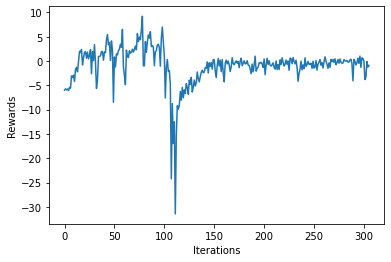

 31%|██████████████████████▎                                                  | 30602/100000 [59:56<2:09:11,  8.95it/s]

Updated Weights
Mean Reward = -1.27
1


 31%|█████████████████████▊                                                 | 30702/100000 [1:00:06<2:04:34,  9.27it/s]

Updated Weights
Mean Reward = -0.72
4


 31%|█████████████████████▊                                                 | 30802/100000 [1:00:17<2:05:20,  9.20it/s]

Updated Weights
Mean Reward = -0.07
6


 31%|█████████████████████▉                                                 | 30902/100000 [1:00:27<2:03:35,  9.32it/s]

Updated Weights
Mean Reward = -0.33
1


 31%|██████████████████████                                                 | 31000/100000 [1:00:37<2:01:27,  9.47it/s]

Updated Weights
Mean Reward = -0.63
4


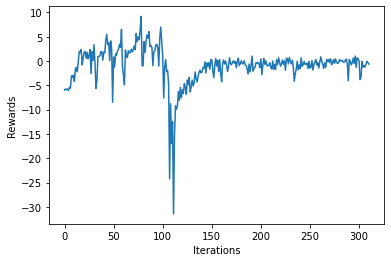

 31%|██████████████████████                                                 | 31102/100000 [1:00:48<2:04:02,  9.26it/s]

Updated Weights
Mean Reward = 0.35
3


 31%|██████████████████████▏                                                | 31202/100000 [1:00:58<1:57:40,  9.74it/s]

Updated Weights
Mean Reward = -0.58
5


 31%|██████████████████████▏                                                | 31302/100000 [1:01:09<2:18:44,  8.25it/s]

Updated Weights
Mean Reward = -0.42
1


 31%|██████████████████████▎                                                | 31402/100000 [1:01:20<2:04:38,  9.17it/s]

Updated Weights
Mean Reward = 0.4
4


 32%|██████████████████████▎                                                | 31500/100000 [1:01:30<2:07:50,  8.93it/s]

Updated Weights
Mean Reward = -0.05
1


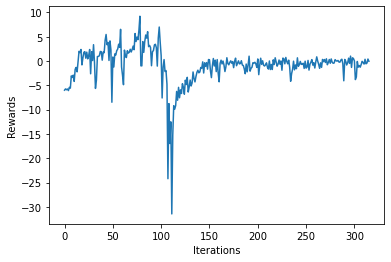

 32%|██████████████████████▍                                                | 31602/100000 [1:01:41<1:52:09, 10.16it/s]

Updated Weights
Mean Reward = 0.0
3


 32%|██████████████████████▌                                                | 31703/100000 [1:01:51<1:59:55,  9.49it/s]

Updated Weights
Mean Reward = -0.77
3


 32%|██████████████████████▌                                                | 31803/100000 [1:02:02<1:46:21, 10.69it/s]

Updated Weights
Mean Reward = -0.16
0


 32%|██████████████████████▋                                                | 31902/100000 [1:02:12<2:01:19,  9.35it/s]

Updated Weights
Mean Reward = -0.13
3


 32%|██████████████████████▋                                                | 32000/100000 [1:02:22<1:59:39,  9.47it/s]

Updated Weights
Mean Reward = -0.61
3


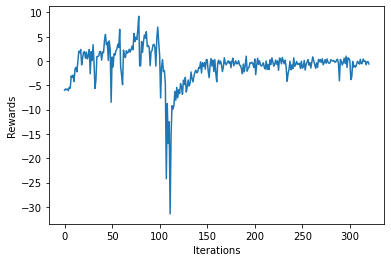

 32%|██████████████████████▊                                                | 32102/100000 [1:02:34<2:01:02,  9.35it/s]

Updated Weights
Mean Reward = -0.61
1


 32%|██████████████████████▊                                                | 32202/100000 [1:02:44<2:00:25,  9.38it/s]

Updated Weights
Mean Reward = -4.78
1


 32%|██████████████████████▉                                                | 32303/100000 [1:02:55<1:54:45,  9.83it/s]

Updated Weights
Mean Reward = 0.41
4


 32%|███████████████████████                                                | 32402/100000 [1:03:05<2:02:15,  9.22it/s]

Updated Weights
Mean Reward = 0.34
4


 32%|███████████████████████                                                | 32500/100000 [1:03:15<2:00:46,  9.31it/s]

Updated Weights
Mean Reward = 0.62
5


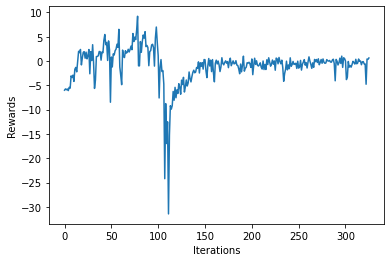

 33%|███████████████████████▏                                               | 32601/100000 [1:03:25<1:52:48,  9.96it/s]

Updated Weights
Mean Reward = 0.18
3


 33%|███████████████████████▏                                               | 32701/100000 [1:03:36<2:01:35,  9.22it/s]

Updated Weights
Mean Reward = -0.64
0


 33%|███████████████████████▎                                               | 32802/100000 [1:03:47<1:51:15, 10.07it/s]

Updated Weights
Mean Reward = 0.33
3


 33%|███████████████████████▎                                               | 32902/100000 [1:03:57<2:01:44,  9.19it/s]

Updated Weights
Mean Reward = 0.08
2


 33%|███████████████████████▍                                               | 33000/100000 [1:04:07<1:52:29,  9.93it/s]

Updated Weights
Mean Reward = 1.48
8


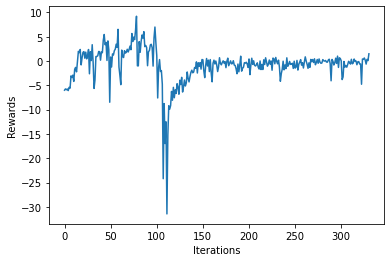

 33%|███████████████████████▌                                               | 33102/100000 [1:04:18<1:53:21,  9.84it/s]

Updated Weights
Mean Reward = 0.4
4


 33%|███████████████████████▌                                               | 33201/100000 [1:04:28<1:44:17, 10.68it/s]

Updated Weights
Mean Reward = -0.48
4


 33%|███████████████████████▋                                               | 33302/100000 [1:04:38<1:56:07,  9.57it/s]

Updated Weights
Mean Reward = -0.67
3


 33%|███████████████████████▋                                               | 33401/100000 [1:04:49<1:44:40, 10.60it/s]

Updated Weights
Mean Reward = -1.81
3


 34%|███████████████████████▊                                               | 33500/100000 [1:04:59<1:54:31,  9.68it/s]

Updated Weights
Mean Reward = -5.59
3


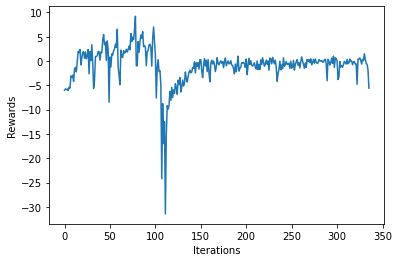

 34%|███████████████████████▊                                               | 33602/100000 [1:05:10<1:55:12,  9.61it/s]

Updated Weights
Mean Reward = -9.55
4


 34%|███████████████████████▉                                               | 33701/100000 [1:05:20<1:52:22,  9.83it/s]

Updated Weights
Mean Reward = -1.38
7


 34%|███████████████████████▉                                               | 33802/100000 [1:05:30<1:55:33,  9.55it/s]

Updated Weights
Mean Reward = 4.02
4


 34%|████████████████████████                                               | 33902/100000 [1:05:40<2:01:54,  9.04it/s]

Updated Weights
Mean Reward = 4.2
5


 34%|████████████████████████▏                                              | 34000/100000 [1:05:51<1:56:20,  9.46it/s]

Updated Weights
Mean Reward = 4.05
3


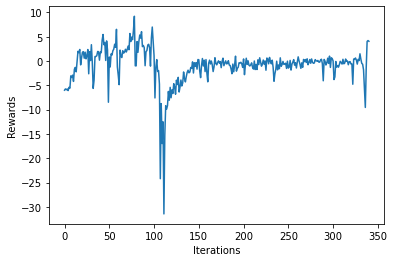

 34%|████████████████████████▏                                              | 34101/100000 [1:06:02<1:49:10, 10.06it/s]

Updated Weights
Mean Reward = 2.56
2


 34%|████████████████████████▎                                              | 34202/100000 [1:06:12<2:01:23,  9.03it/s]

Updated Weights
Mean Reward = -0.13
5


 34%|████████████████████████▎                                              | 34302/100000 [1:06:22<1:56:45,  9.38it/s]

Updated Weights
Mean Reward = 1.69
4


 34%|████████████████████████▍                                              | 34403/100000 [1:06:33<1:56:16,  9.40it/s]

Updated Weights
Mean Reward = 3.44
3


 34%|████████████████████████▍                                              | 34499/100000 [1:06:42<1:41:38, 10.74it/s]

Updated Weights
Mean Reward = 3.06
7


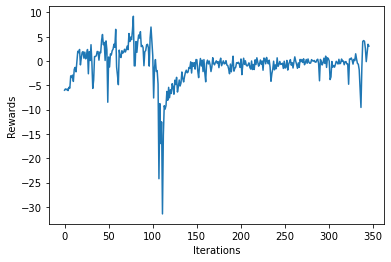

 35%|████████████████████████▌                                              | 34601/100000 [1:06:53<1:41:42, 10.72it/s]

Updated Weights
Mean Reward = 3.36
3


 35%|████████████████████████▋                                              | 34702/100000 [1:07:04<2:00:57,  9.00it/s]

Updated Weights
Mean Reward = 1.82
2


 35%|████████████████████████▋                                              | 34802/100000 [1:07:15<1:57:21,  9.26it/s]

Updated Weights
Mean Reward = 1.29
2


 35%|████████████████████████▊                                              | 34903/100000 [1:07:25<1:38:24, 11.02it/s]

Updated Weights
Mean Reward = 5.94
4


 35%|████████████████████████▊                                              | 35000/100000 [1:07:36<1:55:52,  9.35it/s]

Updated Weights
Mean Reward = 3.68
1


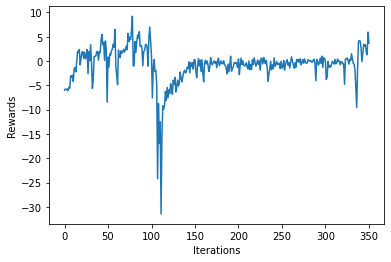

 35%|████████████████████████▉                                              | 35102/100000 [1:07:47<1:54:36,  9.44it/s]

Updated Weights
Mean Reward = 4.41
5


 35%|████████████████████████▉                                              | 35202/100000 [1:07:57<1:58:57,  9.08it/s]

Updated Weights
Mean Reward = 3.64
0


 35%|█████████████████████████                                              | 35302/100000 [1:08:08<1:55:56,  9.30it/s]

Updated Weights
Mean Reward = 1.09
7


 35%|█████████████████████████▏                                             | 35403/100000 [1:08:19<1:55:14,  9.34it/s]

Updated Weights
Mean Reward = 8.94
2


 36%|█████████████████████████▏                                             | 35500/100000 [1:08:29<1:53:41,  9.46it/s]

Updated Weights
Mean Reward = 10.12
3


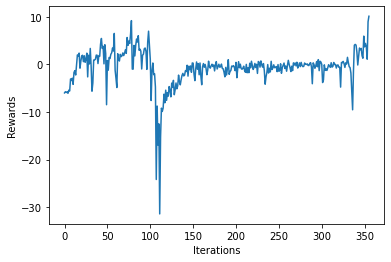

 36%|█████████████████████████▎                                             | 35602/100000 [1:08:40<2:20:31,  7.64it/s]

Updated Weights
Mean Reward = 9.59
2


 36%|█████████████████████████▎                                             | 35701/100000 [1:08:51<1:45:14, 10.18it/s]

Updated Weights
Mean Reward = 9.41
3


 36%|█████████████████████████▍                                             | 35802/100000 [1:09:01<1:47:11,  9.98it/s]

Updated Weights
Mean Reward = 10.43
7


 36%|█████████████████████████▍                                             | 35902/100000 [1:09:11<1:42:22, 10.43it/s]

Updated Weights
Mean Reward = 5.37
14


 36%|█████████████████████████▌                                             | 36000/100000 [1:09:21<1:46:21, 10.03it/s]

Updated Weights
Mean Reward = 0.6
8


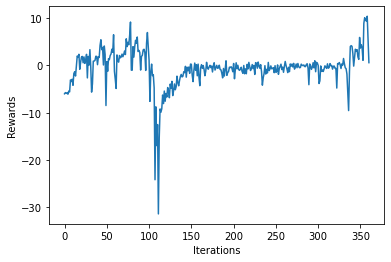

 36%|█████████████████████████▋                                             | 36102/100000 [1:09:31<1:52:52,  9.44it/s]

Updated Weights
Mean Reward = 3.75
8


 36%|█████████████████████████▋                                             | 36201/100000 [1:09:41<1:58:35,  8.97it/s]

Updated Weights
Mean Reward = 3.22
8


 36%|█████████████████████████▊                                             | 36301/100000 [1:09:51<1:33:22, 11.37it/s]

Updated Weights
Mean Reward = 4.35
8


 36%|█████████████████████████▊                                             | 36401/100000 [1:10:02<1:44:59, 10.10it/s]

Updated Weights
Mean Reward = 0.88
5


 36%|█████████████████████████▉                                             | 36500/100000 [1:10:12<1:51:49,  9.46it/s]

Updated Weights
Mean Reward = 2.47
5


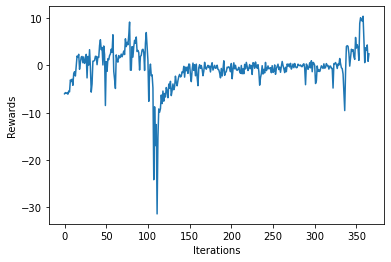

 37%|█████████████████████████▉                                             | 36601/100000 [1:10:22<1:37:15, 10.86it/s]

Updated Weights
Mean Reward = 5.14
10


 37%|██████████████████████████                                             | 36702/100000 [1:10:32<1:55:53,  9.10it/s]

Updated Weights
Mean Reward = 5.08
9


 37%|██████████████████████████▏                                            | 36802/100000 [1:10:43<1:43:46, 10.15it/s]

Updated Weights
Mean Reward = 4.01
6


 37%|██████████████████████████▏                                            | 36902/100000 [1:10:53<1:49:44,  9.58it/s]

Updated Weights
Mean Reward = 5.92
8


 37%|██████████████████████████▎                                            | 36999/100000 [1:11:02<1:24:50, 12.38it/s]

Updated Weights
Mean Reward = 3.52
12


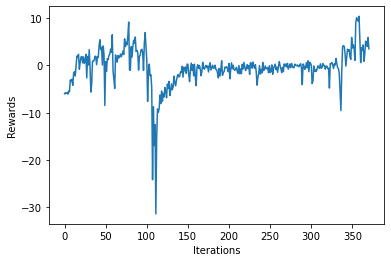

 37%|██████████████████████████▎                                            | 37102/100000 [1:11:13<1:51:37,  9.39it/s]

Updated Weights
Mean Reward = 2.33
9


 37%|██████████████████████████▍                                            | 37202/100000 [1:11:22<1:38:14, 10.65it/s]

Updated Weights
Mean Reward = 2.21
14


 37%|██████████████████████████▍                                            | 37302/100000 [1:11:32<1:51:20,  9.39it/s]

Updated Weights
Mean Reward = 2.84
11


 37%|██████████████████████████▌                                            | 37402/100000 [1:11:42<1:54:55,  9.08it/s]

Updated Weights
Mean Reward = 3.76
8


 37%|██████████████████████████▌                                            | 37499/100000 [1:11:52<1:38:39, 10.56it/s]

Updated Weights
Mean Reward = 3.81
7


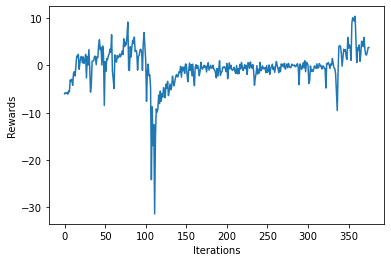

 38%|██████████████████████████▋                                            | 37601/100000 [1:12:03<1:40:48, 10.32it/s]

Updated Weights
Mean Reward = 4.34
4


 38%|██████████████████████████▊                                            | 37703/100000 [1:12:14<1:50:23,  9.41it/s]

Updated Weights
Mean Reward = 7.49
5


 38%|██████████████████████████▊                                            | 37802/100000 [1:12:24<1:52:01,  9.25it/s]

Updated Weights
Mean Reward = 7.19
6


 38%|██████████████████████████▉                                            | 37902/100000 [1:12:35<1:53:32,  9.11it/s]

Updated Weights
Mean Reward = 9.32
3


 38%|██████████████████████████▉                                            | 38000/100000 [1:12:45<1:54:58,  8.99it/s]

Updated Weights
Mean Reward = 7.66
6


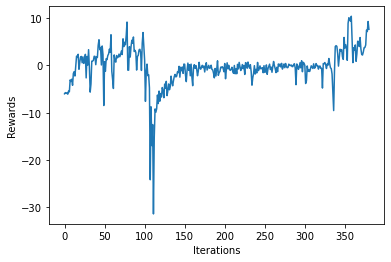

 38%|███████████████████████████                                            | 38103/100000 [1:12:56<1:39:15, 10.39it/s]

Updated Weights
Mean Reward = 5.92
3


 38%|███████████████████████████                                            | 38202/100000 [1:13:06<1:38:54, 10.41it/s]

Updated Weights
Mean Reward = 3.73
13


 38%|███████████████████████████▏                                           | 38302/100000 [1:13:15<1:51:03,  9.26it/s]

Updated Weights
Mean Reward = 5.34
14


 38%|███████████████████████████▎                                           | 38402/100000 [1:13:26<1:49:42,  9.36it/s]

Updated Weights
Mean Reward = 4.98
7


 38%|███████████████████████████▎                                           | 38499/100000 [1:13:36<1:41:18, 10.12it/s]

Updated Weights
Mean Reward = 3.57
5


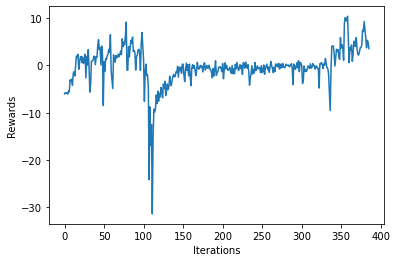

 39%|███████████████████████████▍                                           | 38602/100000 [1:13:47<1:53:46,  8.99it/s]

Updated Weights
Mean Reward = 4.88
4


 39%|███████████████████████████▍                                           | 38702/100000 [1:13:57<1:59:15,  8.57it/s]

Updated Weights
Mean Reward = 7.02
10


 39%|███████████████████████████▌                                           | 38802/100000 [1:14:07<1:53:33,  8.98it/s]

Updated Weights
Mean Reward = 8.62
6


 39%|███████████████████████████▌                                           | 38901/100000 [1:14:17<1:45:34,  9.65it/s]

Updated Weights
Mean Reward = 6.16
9


 39%|███████████████████████████▋                                           | 39000/100000 [1:14:27<1:52:11,  9.06it/s]

Updated Weights
Mean Reward = 7.69
6


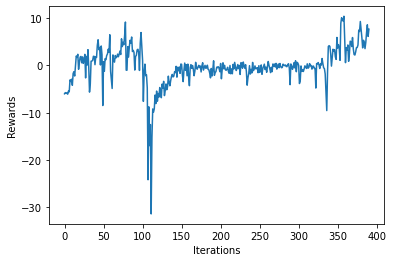

 39%|███████████████████████████▊                                           | 39101/100000 [1:14:38<1:34:31, 10.74it/s]

Updated Weights
Mean Reward = 5.37
6


 39%|███████████████████████████▊                                           | 39202/100000 [1:14:49<1:51:58,  9.05it/s]

Updated Weights
Mean Reward = 3.81
4


 39%|███████████████████████████▉                                           | 39302/100000 [1:14:59<1:43:44,  9.75it/s]

Updated Weights
Mean Reward = 4.94
9


 39%|███████████████████████████▉                                           | 39402/100000 [1:15:09<1:49:11,  9.25it/s]

Updated Weights
Mean Reward = 5.63
1


 40%|████████████████████████████                                           | 39500/100000 [1:15:20<1:49:53,  9.18it/s]

Updated Weights
Mean Reward = 6.3
4


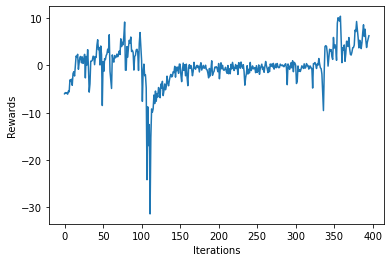

 40%|████████████████████████████                                           | 39602/100000 [1:15:31<1:51:00,  9.07it/s]

Updated Weights
Mean Reward = 5.18
1


 40%|████████████████████████████▏                                          | 39702/100000 [1:15:41<1:42:06,  9.84it/s]

Updated Weights
Mean Reward = 7.5
12


 40%|████████████████████████████▎                                          | 39802/100000 [1:15:51<1:51:59,  8.96it/s]

Updated Weights
Mean Reward = 5.14
5


 40%|████████████████████████████▎                                          | 39901/100000 [1:16:01<1:33:59, 10.66it/s]

Updated Weights
Mean Reward = 5.95
6


 40%|████████████████████████████▍                                          | 40000/100000 [1:16:12<1:43:08,  9.70it/s]

Updated Weights
Mean Reward = 7.13
5


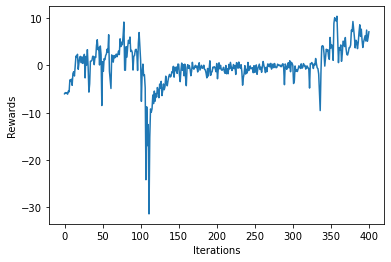

 40%|████████████████████████████▍                                          | 40103/100000 [1:16:22<1:45:53,  9.43it/s]

Updated Weights
Mean Reward = 4.83
7


 40%|████████████████████████████▌                                          | 40202/100000 [1:16:32<1:25:08, 11.70it/s]

Updated Weights
Mean Reward = 6.72
11


 40%|████████████████████████████▌                                          | 40302/100000 [1:16:42<1:48:06,  9.20it/s]

Updated Weights
Mean Reward = 2.4
8


 40%|████████████████████████████▋                                          | 40403/100000 [1:16:53<1:45:18,  9.43it/s]

Updated Weights
Mean Reward = 5.13
6


 40%|████████████████████████████▊                                          | 40500/100000 [1:17:03<1:48:35,  9.13it/s]

Updated Weights
Mean Reward = 4.95
5


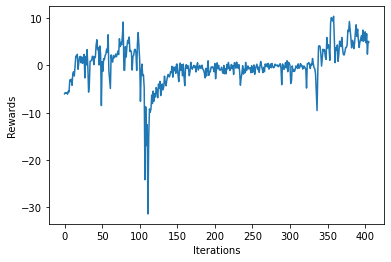

 41%|████████████████████████████▊                                          | 40602/100000 [1:17:14<1:46:15,  9.32it/s]

Updated Weights
Mean Reward = 4.92
3


 41%|████████████████████████████▉                                          | 40702/100000 [1:17:24<1:46:51,  9.25it/s]

Updated Weights
Mean Reward = 8.43
5


 41%|████████████████████████████▉                                          | 40802/100000 [1:17:35<1:46:17,  9.28it/s]

Updated Weights
Mean Reward = 5.93
2


 41%|█████████████████████████████                                          | 40902/100000 [1:17:46<1:51:54,  8.80it/s]

Updated Weights
Mean Reward = 7.99
2


 41%|█████████████████████████████                                          | 41000/100000 [1:17:57<1:53:49,  8.64it/s]

Updated Weights
Mean Reward = 7.87
2


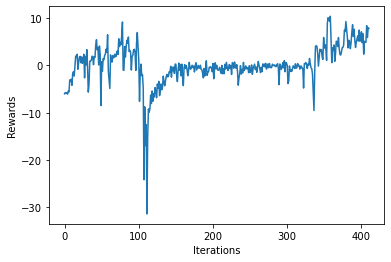

 41%|█████████████████████████████▏                                         | 41103/100000 [1:18:08<1:21:54, 11.99it/s]

Updated Weights
Mean Reward = 8.02
8


 41%|█████████████████████████████▎                                         | 41202/100000 [1:18:18<1:46:31,  9.20it/s]

Updated Weights
Mean Reward = 6.43
5


 41%|█████████████████████████████▎                                         | 41302/100000 [1:18:29<1:44:10,  9.39it/s]

Updated Weights
Mean Reward = 3.89
1


 41%|█████████████████████████████▍                                         | 41402/100000 [1:18:39<1:47:46,  9.06it/s]

Updated Weights
Mean Reward = 6.29
3


 41%|█████████████████████████████▍                                         | 41499/100000 [1:18:50<1:39:22,  9.81it/s]

Updated Weights
Mean Reward = 0.41
4


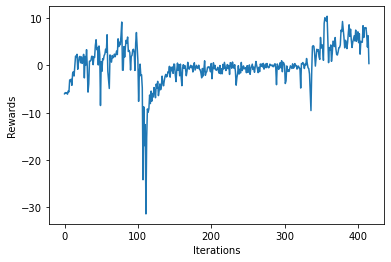

 42%|█████████████████████████████▌                                         | 41602/100000 [1:19:01<2:02:12,  7.96it/s]

Updated Weights
Mean Reward = 2.19
4


 42%|█████████████████████████████▌                                         | 41702/100000 [1:19:11<1:43:11,  9.42it/s]

Updated Weights
Mean Reward = 6.08
2


 42%|█████████████████████████████▋                                         | 41802/100000 [1:19:22<1:45:44,  9.17it/s]

Updated Weights
Mean Reward = 8.07
4


 42%|█████████████████████████████▊                                         | 41902/100000 [1:19:33<1:51:42,  8.67it/s]

Updated Weights
Mean Reward = 7.63
1


 42%|█████████████████████████████▊                                         | 41999/100000 [1:19:43<1:38:25,  9.82it/s]

Updated Weights
Mean Reward = 8.28
5


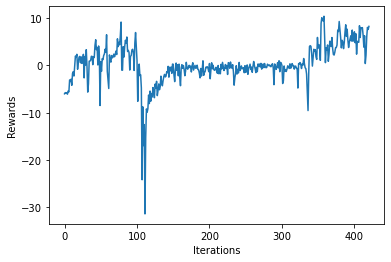

 42%|█████████████████████████████▉                                         | 42102/100000 [1:19:54<1:33:09, 10.36it/s]

Updated Weights
Mean Reward = 6.67
3


 42%|█████████████████████████████▉                                         | 42202/100000 [1:20:04<1:44:01,  9.26it/s]

Updated Weights
Mean Reward = 6.24
3


 42%|██████████████████████████████                                         | 42303/100000 [1:20:15<1:42:51,  9.35it/s]

Updated Weights
Mean Reward = 8.2
2


 42%|██████████████████████████████                                         | 42402/100000 [1:20:25<1:43:17,  9.29it/s]

Updated Weights
Mean Reward = 6.02
9


 42%|██████████████████████████████▏                                        | 42500/100000 [1:20:35<1:41:20,  9.46it/s]

Updated Weights
Mean Reward = 3.83
10


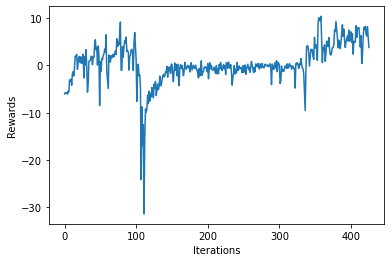

 43%|██████████████████████████████▏                                        | 42602/100000 [1:20:46<1:45:43,  9.05it/s]

Updated Weights
Mean Reward = 4.6
4


 43%|██████████████████████████████▎                                        | 42701/100000 [1:20:56<1:36:59,  9.85it/s]

Updated Weights
Mean Reward = 6.36
5


 43%|██████████████████████████████▍                                        | 42802/100000 [1:21:07<1:38:11,  9.71it/s]

Updated Weights
Mean Reward = 4.46
8


 43%|██████████████████████████████▍                                        | 42902/100000 [1:21:17<1:45:30,  9.02it/s]

Updated Weights
Mean Reward = 4.35
3


 43%|██████████████████████████████▌                                        | 43000/100000 [1:21:27<1:39:42,  9.53it/s]

Updated Weights
Mean Reward = 6.28
5


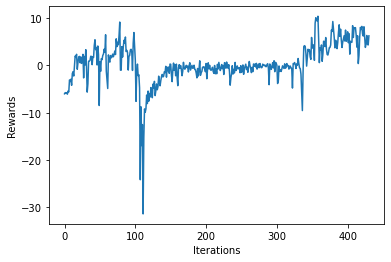

 43%|██████████████████████████████▌                                        | 43102/100000 [1:21:38<1:43:58,  9.12it/s]

Updated Weights
Mean Reward = 5.55
3


 43%|██████████████████████████████▋                                        | 43202/100000 [1:21:49<1:42:35,  9.23it/s]

Updated Weights
Mean Reward = 1.94
4


 43%|██████████████████████████████▋                                        | 43301/100000 [1:21:59<1:44:53,  9.01it/s]

Updated Weights
Mean Reward = 5.26
3


 43%|██████████████████████████████▊                                        | 43401/100000 [1:22:10<1:44:42,  9.01it/s]

Updated Weights
Mean Reward = 5.46
3


 44%|██████████████████████████████▉                                        | 43500/100000 [1:22:20<1:33:48, 10.04it/s]

Updated Weights
Mean Reward = 7.2
5


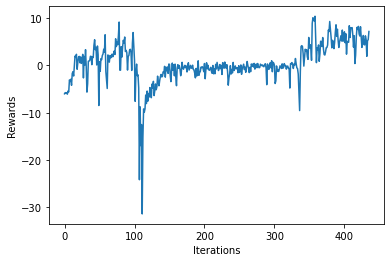

 44%|██████████████████████████████▉                                        | 43602/100000 [1:22:31<1:43:52,  9.05it/s]

Updated Weights
Mean Reward = 8.14
3


 44%|███████████████████████████████                                        | 43702/100000 [1:22:41<1:45:10,  8.92it/s]

Updated Weights
Mean Reward = 8.63
6


 44%|███████████████████████████████                                        | 43802/100000 [1:22:52<1:40:32,  9.32it/s]

Updated Weights
Mean Reward = 7.66
3


 44%|███████████████████████████████▏                                       | 43902/100000 [1:23:03<1:39:58,  9.35it/s]

Updated Weights
Mean Reward = 8.55
2


 44%|███████████████████████████████▏                                       | 43999/100000 [1:23:13<1:44:17,  8.95it/s]

Updated Weights
Mean Reward = 8.49
3


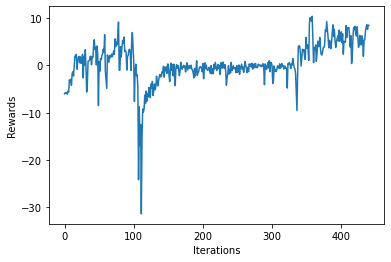

 44%|███████████████████████████████▎                                       | 44101/100000 [1:23:24<1:42:15,  9.11it/s]

Updated Weights
Mean Reward = 8.5
1


 44%|███████████████████████████████▍                                       | 44201/100000 [1:23:34<1:29:46, 10.36it/s]

Updated Weights
Mean Reward = 6.49
3


 44%|███████████████████████████████▍                                       | 44302/100000 [1:23:45<1:42:02,  9.10it/s]

Updated Weights
Mean Reward = 9.5
5


 44%|███████████████████████████████▌                                       | 44402/100000 [1:23:56<1:42:10,  9.07it/s]

Updated Weights
Mean Reward = 9.35
2


 44%|███████████████████████████████▌                                       | 44500/100000 [1:24:06<1:40:37,  9.19it/s]

Updated Weights
Mean Reward = 9.15
1


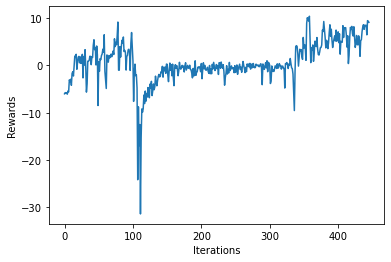

 45%|███████████████████████████████▋                                       | 44602/100000 [1:24:17<1:38:07,  9.41it/s]

Updated Weights
Mean Reward = 8.75
5


 45%|███████████████████████████████▋                                       | 44702/100000 [1:24:28<1:42:28,  8.99it/s]

Updated Weights
Mean Reward = 6.38
4


 45%|███████████████████████████████▊                                       | 44801/100000 [1:24:38<1:34:05,  9.78it/s]

Updated Weights
Mean Reward = 7.28
6


 45%|███████████████████████████████▉                                       | 44903/100000 [1:24:48<1:36:53,  9.48it/s]

Updated Weights
Mean Reward = 7.85
7


 45%|███████████████████████████████▉                                       | 45000/100000 [1:24:58<1:25:09, 10.76it/s]

Updated Weights
Mean Reward = 5.78
6


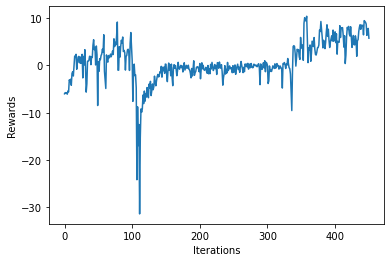

 45%|████████████████████████████████                                       | 45102/100000 [1:25:09<1:40:05,  9.14it/s]

Updated Weights
Mean Reward = 5.82
5


 45%|████████████████████████████████                                       | 45201/100000 [1:25:19<1:23:29, 10.94it/s]

Updated Weights
Mean Reward = 2.97
7


 45%|████████████████████████████████▏                                      | 45301/100000 [1:25:29<1:34:30,  9.65it/s]

Updated Weights
Mean Reward = 6.54
6


 45%|████████████████████████████████▏                                      | 45402/100000 [1:25:40<1:43:35,  8.78it/s]

Updated Weights
Mean Reward = 9.63
6


 46%|████████████████████████████████▎                                      | 45500/100000 [1:25:50<1:40:22,  9.05it/s]

Updated Weights
Mean Reward = 9.04
2


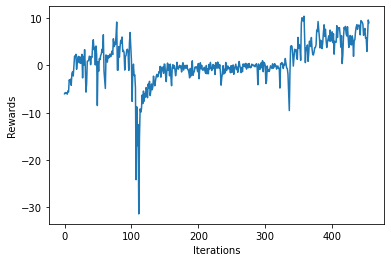

 46%|████████████████████████████████▍                                      | 45602/100000 [1:26:01<1:40:16,  9.04it/s]

Updated Weights
Mean Reward = 9.27
2


 46%|████████████████████████████████▍                                      | 45703/100000 [1:26:12<1:37:25,  9.29it/s]

Updated Weights
Mean Reward = 10.51
3


 46%|████████████████████████████████▌                                      | 45802/100000 [1:26:23<1:35:57,  9.41it/s]

Updated Weights
Mean Reward = 9.4
5


 46%|████████████████████████████████▌                                      | 45901/100000 [1:26:33<1:21:17, 11.09it/s]

Updated Weights
Mean Reward = 6.51
8


 46%|████████████████████████████████▋                                      | 46000/100000 [1:26:43<1:38:59,  9.09it/s]

Updated Weights
Mean Reward = 8.33
4


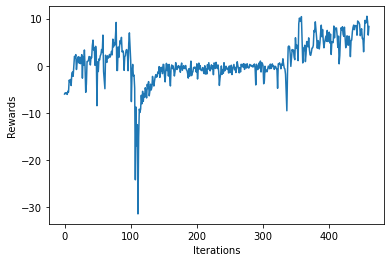

 46%|████████████████████████████████▋                                      | 46102/100000 [1:26:54<1:37:11,  9.24it/s]

Updated Weights
Mean Reward = 7.33
1


 46%|████████████████████████████████▊                                      | 46202/100000 [1:27:05<1:39:00,  9.06it/s]

Updated Weights
Mean Reward = 3.4
4


 46%|████████████████████████████████▊                                      | 46302/100000 [1:27:15<1:37:24,  9.19it/s]

Updated Weights
Mean Reward = 5.02
5


 46%|████████████████████████████████▉                                      | 46402/100000 [1:27:26<1:37:13,  9.19it/s]

Updated Weights
Mean Reward = 8.33
3


 46%|█████████████████████████████████                                      | 46500/100000 [1:27:36<1:29:25,  9.97it/s]

Updated Weights
Mean Reward = 8.8
5


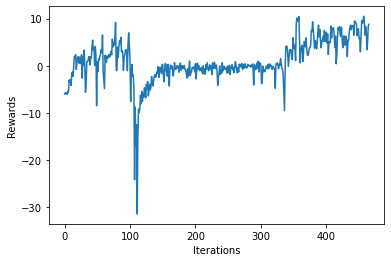

 47%|█████████████████████████████████                                      | 46601/100000 [1:27:47<1:38:45,  9.01it/s]

Updated Weights
Mean Reward = 8.36
3


 47%|█████████████████████████████████▏                                     | 46702/100000 [1:27:58<1:37:44,  9.09it/s]

Updated Weights
Mean Reward = 7.14
3


 47%|█████████████████████████████████▏                                     | 46802/100000 [1:28:08<1:34:01,  9.43it/s]

Updated Weights
Mean Reward = 9.3
4


 47%|█████████████████████████████████▎                                     | 46902/100000 [1:28:19<1:41:15,  8.74it/s]

Updated Weights
Mean Reward = 8.82
4


 47%|█████████████████████████████████▎                                     | 47000/100000 [1:28:29<1:34:44,  9.32it/s]

Updated Weights
Mean Reward = 8.67
2


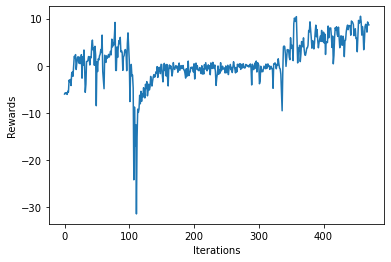

 47%|█████████████████████████████████▍                                     | 47102/100000 [1:28:40<1:41:45,  8.66it/s]

Updated Weights
Mean Reward = 6.36
5


 47%|█████████████████████████████████▌                                     | 47203/100000 [1:28:50<1:33:17,  9.43it/s]

Updated Weights
Mean Reward = 4.59
8


 47%|█████████████████████████████████▌                                     | 47302/100000 [1:29:01<1:34:10,  9.33it/s]

Updated Weights
Mean Reward = 3.97
5


 47%|█████████████████████████████████▋                                     | 47402/100000 [1:29:11<1:29:06,  9.84it/s]

Updated Weights
Mean Reward = 7.43
2


 48%|█████████████████████████████████▋                                     | 47500/100000 [1:29:21<1:35:17,  9.18it/s]

Updated Weights
Mean Reward = 7.84
5


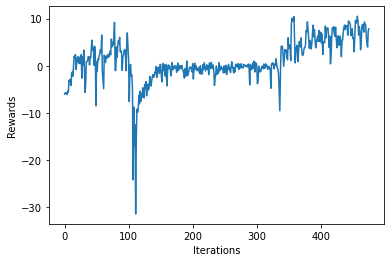

 48%|█████████████████████████████████▊                                     | 47602/100000 [1:29:32<1:33:54,  9.30it/s]

Updated Weights
Mean Reward = 7.35
2


 48%|█████████████████████████████████▊                                     | 47702/100000 [1:29:43<1:34:29,  9.22it/s]

Updated Weights
Mean Reward = 8.33
3


 48%|█████████████████████████████████▉                                     | 47802/100000 [1:29:53<1:34:41,  9.19it/s]

Updated Weights
Mean Reward = 9.6
4


 48%|██████████████████████████████████                                     | 47901/100000 [1:30:04<1:36:15,  9.02it/s]

Updated Weights
Mean Reward = 8.5
5


 48%|██████████████████████████████████                                     | 47999/100000 [1:30:14<1:26:43,  9.99it/s]

Updated Weights
Mean Reward = 8.79
9


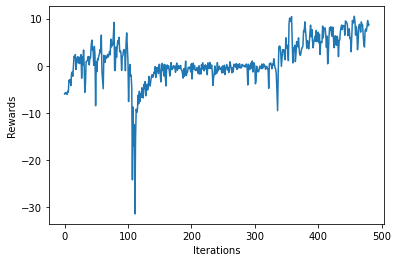

 48%|██████████████████████████████████▏                                    | 48102/100000 [1:30:24<1:36:38,  8.95it/s]

Updated Weights
Mean Reward = 9.38
7


 48%|██████████████████████████████████▏                                    | 48202/100000 [1:30:34<1:32:17,  9.35it/s]

Updated Weights
Mean Reward = 5.97
9


 48%|██████████████████████████████████▎                                    | 48303/100000 [1:30:45<1:19:00, 10.90it/s]

Updated Weights
Mean Reward = 0.62
4


 48%|██████████████████████████████████▎                                    | 48404/100000 [1:30:55<1:08:37, 12.53it/s]

Updated Weights
Mean Reward = 3.3
10


 48%|██████████████████████████████████▍                                    | 48500/100000 [1:31:05<1:26:12,  9.96it/s]

Updated Weights
Mean Reward = 9.14
11


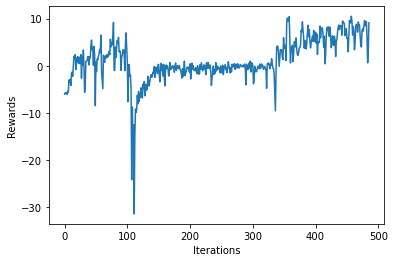

 49%|██████████████████████████████████▌                                    | 48601/100000 [1:31:15<1:32:22,  9.27it/s]

Updated Weights
Mean Reward = 9.82
7


 49%|██████████████████████████████████▌                                    | 48702/100000 [1:31:26<1:35:37,  8.94it/s]

Updated Weights
Mean Reward = 8.95
2


 49%|██████████████████████████████████▋                                    | 48802/100000 [1:31:37<1:47:05,  7.97it/s]

Updated Weights
Mean Reward = 6.14
4


 49%|██████████████████████████████████▋                                    | 48902/100000 [1:31:47<1:31:27,  9.31it/s]

Updated Weights
Mean Reward = 5.72
3


 49%|██████████████████████████████████▊                                    | 48999/100000 [1:31:58<1:25:48,  9.91it/s]

Updated Weights
Mean Reward = 7.38
3


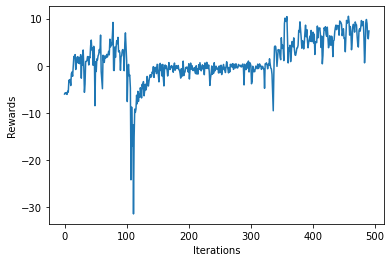

 49%|██████████████████████████████████▊                                    | 49102/100000 [1:32:10<1:33:35,  9.06it/s]

Updated Weights
Mean Reward = 7.42
2


 49%|██████████████████████████████████▉                                    | 49202/100000 [1:32:21<1:35:48,  8.84it/s]

Updated Weights
Mean Reward = 7.01
6


 49%|███████████████████████████████████                                    | 49302/100000 [1:32:35<2:26:47,  5.76it/s]

Updated Weights
Mean Reward = 5.96
2


 49%|███████████████████████████████████                                    | 49403/100000 [1:32:51<1:57:52,  7.15it/s]

Updated Weights
Mean Reward = 8.96
3


 50%|███████████████████████████████████▏                                   | 49500/100000 [1:33:01<1:25:19,  9.87it/s]

Updated Weights
Mean Reward = 8.01
6


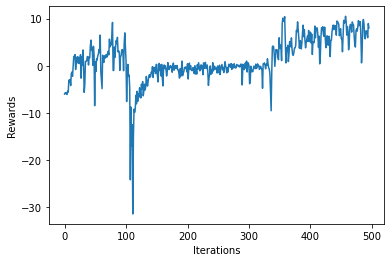

 50%|███████████████████████████████████▏                                   | 49602/100000 [1:33:12<1:33:16,  9.01it/s]

Updated Weights
Mean Reward = 8.19
4


 50%|███████████████████████████████████▎                                   | 49702/100000 [1:33:23<1:28:33,  9.47it/s]

Updated Weights
Mean Reward = 7.05
3


 50%|███████████████████████████████████▎                                   | 49803/100000 [1:33:33<1:11:55, 11.63it/s]

Updated Weights
Mean Reward = 8.03
7


 50%|███████████████████████████████████▍                                   | 49902/100000 [1:33:44<1:30:37,  9.21it/s]

Updated Weights
Mean Reward = 8.43
5


 50%|███████████████████████████████████▍                                   | 49999/100000 [1:33:54<1:24:36,  9.85it/s]

Updated Weights
Mean Reward = 7.59
8


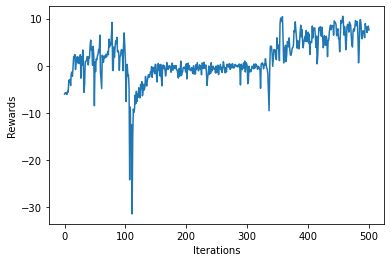

 50%|███████████████████████████████████▌                                   | 50102/100000 [1:34:04<1:29:54,  9.25it/s]

Updated Weights
Mean Reward = 6.75
7


 50%|███████████████████████████████████▋                                   | 50202/100000 [1:34:15<1:34:57,  8.74it/s]

Updated Weights
Mean Reward = 7.54
4


 50%|███████████████████████████████████▋                                   | 50301/100000 [1:34:25<1:24:12,  9.84it/s]

Updated Weights
Mean Reward = 5.96
7


 50%|███████████████████████████████████▊                                   | 50403/100000 [1:34:35<1:09:47, 11.85it/s]

Updated Weights
Mean Reward = 1.74
8


 50%|███████████████████████████████████▊                                   | 50500/100000 [1:34:45<1:33:27,  8.83it/s]

Updated Weights
Mean Reward = 7.3
10


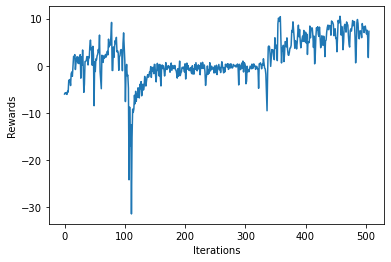

 51%|███████████████████████████████████▉                                   | 50602/100000 [1:34:56<1:27:34,  9.40it/s]

Updated Weights
Mean Reward = 5.35
3


 51%|███████████████████████████████████▉                                   | 50702/100000 [1:35:06<1:31:32,  8.98it/s]

Updated Weights
Mean Reward = 5.65
7


 51%|████████████████████████████████████                                   | 50802/100000 [1:35:17<1:29:48,  9.13it/s]

Updated Weights
Mean Reward = 8.57
3


 51%|████████████████████████████████████▏                                  | 50902/100000 [1:35:27<1:29:33,  9.14it/s]

Updated Weights
Mean Reward = 6.17
5


 51%|████████████████████████████████████▏                                  | 51000/100000 [1:35:37<1:28:15,  9.25it/s]

Updated Weights
Mean Reward = 7.46
5


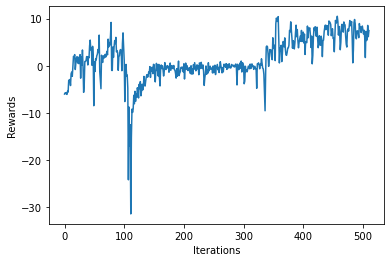

 51%|████████████████████████████████████▎                                  | 51102/100000 [1:35:48<1:35:37,  8.52it/s]

Updated Weights
Mean Reward = 6.0
7


 51%|████████████████████████████████████▎                                  | 51202/100000 [1:35:59<1:31:32,  8.88it/s]

Updated Weights
Mean Reward = 6.0
0


 51%|████████████████████████████████████▍                                  | 51302/100000 [1:36:10<1:25:05,  9.54it/s]

Updated Weights
Mean Reward = 8.61
2


 51%|████████████████████████████████████▍                                  | 51402/100000 [1:36:21<1:22:21,  9.84it/s]

Updated Weights
Mean Reward = 7.49
3


 52%|████████████████████████████████████▌                                  | 51500/100000 [1:36:31<1:29:51,  9.00it/s]

Updated Weights
Mean Reward = 5.74
7


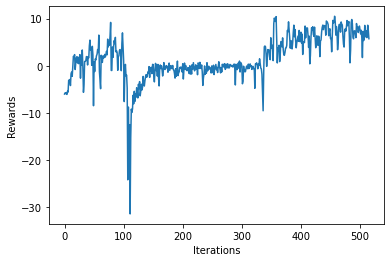

 52%|████████████████████████████████████▋                                  | 51603/100000 [1:36:42<1:19:44, 10.12it/s]

Updated Weights
Mean Reward = 6.18
2


 52%|████████████████████████████████████▋                                  | 51701/100000 [1:36:52<1:19:14, 10.16it/s]

Updated Weights
Mean Reward = 7.04
4


 52%|████████████████████████████████████▊                                  | 51802/100000 [1:37:03<1:19:29, 10.11it/s]

Updated Weights
Mean Reward = 7.78
4


 52%|████████████████████████████████████▊                                  | 51902/100000 [1:37:13<1:17:56, 10.29it/s]

Updated Weights
Mean Reward = 6.16
8


 52%|████████████████████████████████████▉                                  | 52000/100000 [1:37:23<1:18:36, 10.18it/s]

Updated Weights
Mean Reward = 6.51
5


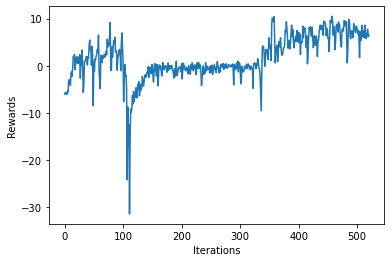

 52%|████████████████████████████████████▉                                  | 52102/100000 [1:37:34<1:27:53,  9.08it/s]

Updated Weights
Mean Reward = 5.96
9


 52%|█████████████████████████████████████                                  | 52202/100000 [1:37:44<1:27:23,  9.12it/s]

Updated Weights
Mean Reward = 4.76
3


 52%|█████████████████████████████████████▏                                 | 52302/100000 [1:37:55<1:24:53,  9.37it/s]

Updated Weights
Mean Reward = 6.47
5


 52%|█████████████████████████████████████▏                                 | 52402/100000 [1:38:06<1:18:05, 10.16it/s]

Updated Weights
Mean Reward = 6.03
3


 52%|█████████████████████████████████████▎                                 | 52500/100000 [1:38:16<1:25:14,  9.29it/s]

Updated Weights
Mean Reward = 7.52
0


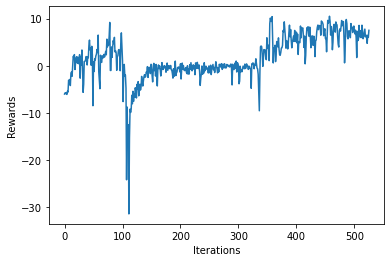

 53%|█████████████████████████████████████▎                                 | 52602/100000 [1:38:27<1:25:27,  9.24it/s]

Updated Weights
Mean Reward = 7.18
5


 53%|█████████████████████████████████████▍                                 | 52703/100000 [1:38:38<1:24:40,  9.31it/s]

Updated Weights
Mean Reward = 7.74
4


 53%|█████████████████████████████████████▍                                 | 52802/100000 [1:38:49<1:20:29,  9.77it/s]

Updated Weights
Mean Reward = 7.08
4


 53%|█████████████████████████████████████▌                                 | 52902/100000 [1:38:59<1:21:29,  9.63it/s]

Updated Weights
Mean Reward = 7.22
5


 53%|█████████████████████████████████████▋                                 | 53000/100000 [1:39:09<1:23:53,  9.34it/s]

Updated Weights
Mean Reward = 5.47
9


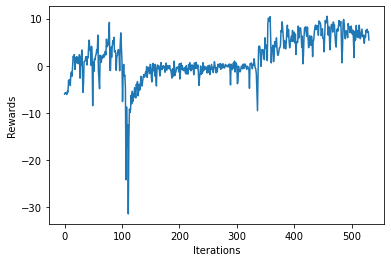

 53%|█████████████████████████████████████▋                                 | 53103/100000 [1:39:20<1:14:21, 10.51it/s]

Updated Weights
Mean Reward = 7.76
2


 53%|█████████████████████████████████████▊                                 | 53202/100000 [1:39:31<1:19:31,  9.81it/s]

Updated Weights
Mean Reward = 6.19
5


 53%|█████████████████████████████████████▊                                 | 53301/100000 [1:39:41<1:14:58, 10.38it/s]

Updated Weights
Mean Reward = 7.26
6


 53%|█████████████████████████████████████▉                                 | 53401/100000 [1:39:52<1:16:35, 10.14it/s]

Updated Weights
Mean Reward = 5.94
7


 54%|█████████████████████████████████████▉                                 | 53500/100000 [1:40:03<1:32:21,  8.39it/s]

Updated Weights
Mean Reward = 4.63
6


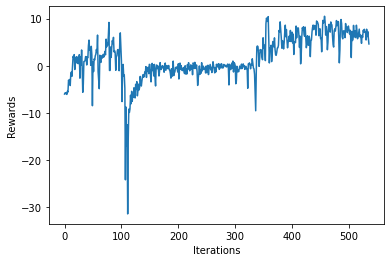

 54%|██████████████████████████████████████                                 | 53601/100000 [1:40:15<2:02:48,  6.30it/s]

Updated Weights
Mean Reward = 6.06
5


 54%|██████████████████████████████████████▏                                | 53702/100000 [1:40:31<2:03:07,  6.27it/s]

Updated Weights
Mean Reward = 4.49
4


 54%|██████████████████████████████████████▏                                | 53802/100000 [1:40:46<1:32:58,  8.28it/s]

Updated Weights
Mean Reward = 8.08
4


 54%|██████████████████████████████████████▎                                | 53901/100000 [1:40:57<1:16:49, 10.00it/s]

Updated Weights
Mean Reward = 7.82
3


 54%|██████████████████████████████████████▎                                | 53999/100000 [1:41:07<1:23:18,  9.20it/s]

Updated Weights
Mean Reward = 6.46
6


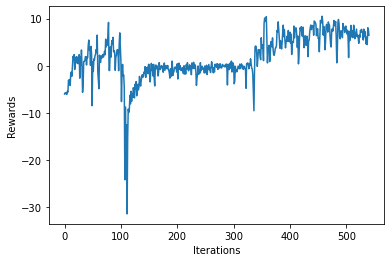

 54%|██████████████████████████████████████▍                                | 54102/100000 [1:41:18<1:26:19,  8.86it/s]

Updated Weights
Mean Reward = 5.62
5


 54%|██████████████████████████████████████▍                                | 54201/100000 [1:41:29<1:15:15, 10.14it/s]

Updated Weights
Mean Reward = 7.86
7


 54%|██████████████████████████████████████▌                                | 54302/100000 [1:41:40<1:27:08,  8.74it/s]

Updated Weights
Mean Reward = 7.86
10


 54%|██████████████████████████████████████▋                                | 54402/100000 [1:41:50<1:24:21,  9.01it/s]

Updated Weights
Mean Reward = 6.12
11


 54%|██████████████████████████████████████▋                                | 54499/100000 [1:42:01<1:09:50, 10.86it/s]

Updated Weights
Mean Reward = 6.34
4


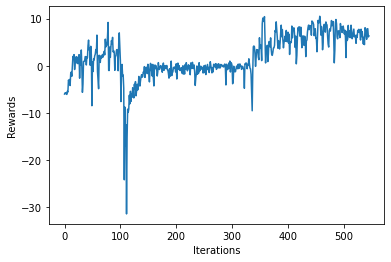

 55%|██████████████████████████████████████▊                                | 54602/100000 [1:42:12<1:24:06,  9.00it/s]

Updated Weights
Mean Reward = 6.18
5


 55%|██████████████████████████████████████▊                                | 54702/100000 [1:42:22<1:18:24,  9.63it/s]

Updated Weights
Mean Reward = 6.84
6


 55%|██████████████████████████████████████▉                                | 54802/100000 [1:42:33<1:20:30,  9.36it/s]

Updated Weights
Mean Reward = 5.26
8


 55%|██████████████████████████████████████▉                                | 54901/100000 [1:42:43<1:16:35,  9.81it/s]

Updated Weights
Mean Reward = 4.12
5


 55%|███████████████████████████████████████                                | 55000/100000 [1:42:53<1:15:43,  9.90it/s]

Updated Weights
Mean Reward = 6.68
6


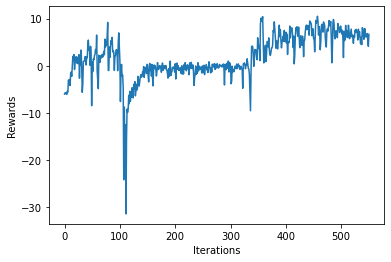

 55%|███████████████████████████████████████                                | 55102/100000 [1:43:04<1:21:01,  9.24it/s]

Updated Weights
Mean Reward = 7.31
2


 55%|███████████████████████████████████████▏                               | 55202/100000 [1:43:15<1:20:05,  9.32it/s]

Updated Weights
Mean Reward = 6.59
3


 55%|███████████████████████████████████████▎                               | 55301/100000 [1:43:25<1:09:39, 10.70it/s]

Updated Weights
Mean Reward = 5.46
4


 55%|███████████████████████████████████████▎                               | 55401/100000 [1:43:36<1:22:23,  9.02it/s]

Updated Weights
Mean Reward = 5.8
5


 56%|███████████████████████████████████████▍                               | 55500/100000 [1:43:46<1:09:59, 10.60it/s]

Updated Weights
Mean Reward = 7.59
5


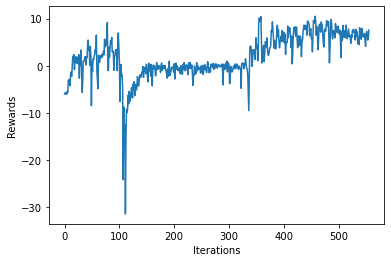

 56%|███████████████████████████████████████▍                               | 55602/100000 [1:43:56<1:21:04,  9.13it/s]

Updated Weights
Mean Reward = 5.86
9


 56%|███████████████████████████████████████▌                               | 55701/100000 [1:44:06<1:11:51, 10.27it/s]

Updated Weights
Mean Reward = 7.26
5


 56%|███████████████████████████████████████▌                               | 55802/100000 [1:44:17<1:20:29,  9.15it/s]

Updated Weights
Mean Reward = 7.19
5


 56%|███████████████████████████████████████▋                               | 55902/100000 [1:44:27<1:20:07,  9.17it/s]

Updated Weights
Mean Reward = 6.6
7


 56%|███████████████████████████████████████▊                               | 56000/100000 [1:44:37<1:09:47, 10.51it/s]

Updated Weights
Mean Reward = 6.25
8


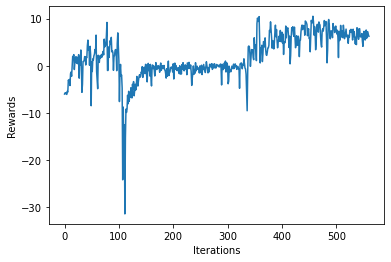

 56%|███████████████████████████████████████▊                               | 56101/100000 [1:44:47<1:15:03,  9.75it/s]

Updated Weights
Mean Reward = 5.59
9


 56%|███████████████████████████████████████▉                               | 56202/100000 [1:44:58<1:18:37,  9.28it/s]

Updated Weights
Mean Reward = 6.98
6


 56%|███████████████████████████████████████▉                               | 56302/100000 [1:45:08<1:20:53,  9.00it/s]

Updated Weights
Mean Reward = 5.43
3


 56%|████████████████████████████████████████                               | 56402/100000 [1:45:18<1:19:24,  9.15it/s]

Updated Weights
Mean Reward = 7.32
8


 56%|████████████████████████████████████████                               | 56500/100000 [1:45:28<1:10:20, 10.31it/s]

Updated Weights
Mean Reward = 6.05
6


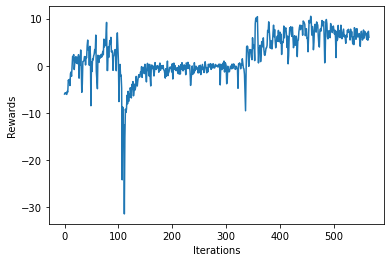

 57%|████████████████████████████████████████▏                              | 56602/100000 [1:45:39<1:18:41,  9.19it/s]

Updated Weights
Mean Reward = 5.76
5


 57%|████████████████████████████████████████▎                              | 56702/100000 [1:45:50<1:17:18,  9.33it/s]

Updated Weights
Mean Reward = 6.17
2


 57%|████████████████████████████████████████▎                              | 56801/100000 [1:46:00<1:17:00,  9.35it/s]

Updated Weights
Mean Reward = 6.82
4


 57%|████████████████████████████████████████▍                              | 56901/100000 [1:46:11<1:19:42,  9.01it/s]

Updated Weights
Mean Reward = 6.94
6


 57%|████████████████████████████████████████▍                              | 57000/100000 [1:46:21<1:16:42,  9.34it/s]

Updated Weights
Mean Reward = 7.9
7


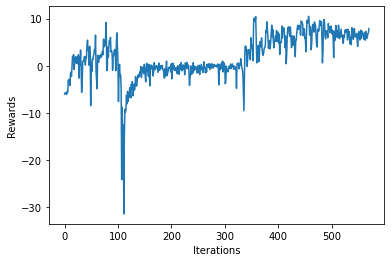

 57%|████████████████████████████████████████▌                              | 57103/100000 [1:46:32<1:07:17, 10.62it/s]

Updated Weights
Mean Reward = 6.28
5


 57%|████████████████████████████████████████▌                              | 57202/100000 [1:46:42<1:14:53,  9.52it/s]

Updated Weights
Mean Reward = 7.62
7


 57%|████████████████████████████████████████▋                              | 57303/100000 [1:46:53<1:07:55, 10.48it/s]

Updated Weights
Mean Reward = 3.17
2


 57%|████████████████████████████████████████▊                              | 57402/100000 [1:47:03<1:16:31,  9.28it/s]

Updated Weights
Mean Reward = 7.5
3


 57%|████████████████████████████████████████▊                              | 57500/100000 [1:47:14<1:46:25,  6.66it/s]

Updated Weights
Mean Reward = 6.06
10


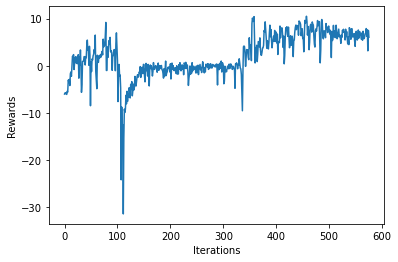

 58%|████████████████████████████████████████▉                              | 57602/100000 [1:47:26<1:09:36, 10.15it/s]

Updated Weights
Mean Reward = 6.52
7


 58%|████████████████████████████████████████▉                              | 57703/100000 [1:47:37<1:05:44, 10.72it/s]

Updated Weights
Mean Reward = 5.66
4


 58%|█████████████████████████████████████████                              | 57802/100000 [1:47:47<1:17:19,  9.10it/s]

Updated Weights
Mean Reward = 5.63
7


 58%|█████████████████████████████████████████                              | 57901/100000 [1:47:57<1:10:27,  9.96it/s]

Updated Weights
Mean Reward = 1.11
6


 58%|█████████████████████████████████████████▏                             | 57999/100000 [1:48:07<1:09:35, 10.06it/s]

Updated Weights
Mean Reward = 3.78
5


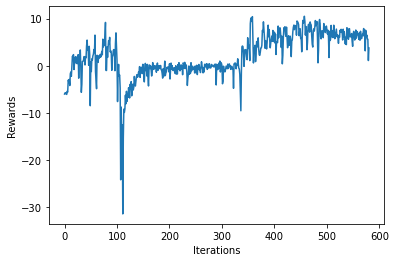

 58%|█████████████████████████████████████████▎                             | 58102/100000 [1:48:18<1:11:11,  9.81it/s]

Updated Weights
Mean Reward = 6.65
8


 58%|█████████████████████████████████████████▎                             | 58202/100000 [1:48:29<1:14:56,  9.29it/s]

Updated Weights
Mean Reward = 5.76
5


 58%|█████████████████████████████████████████▍                             | 58302/100000 [1:48:39<1:06:14, 10.49it/s]

Updated Weights
Mean Reward = 5.69
10


 58%|█████████████████████████████████████████▍                             | 58402/100000 [1:48:49<1:10:34,  9.82it/s]

Updated Weights
Mean Reward = 7.15
6


 58%|█████████████████████████████████████████▌                             | 58500/100000 [1:48:59<1:15:46,  9.13it/s]

Updated Weights
Mean Reward = 7.18
6


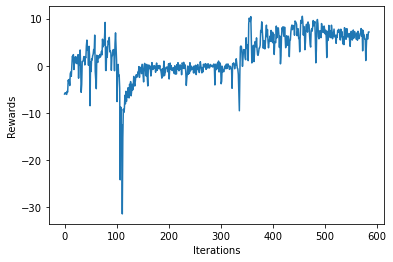

 59%|█████████████████████████████████████████▌                             | 58602/100000 [1:49:10<1:07:48, 10.17it/s]

Updated Weights
Mean Reward = 6.47
7


 59%|█████████████████████████████████████████▋                             | 58702/100000 [1:49:20<1:15:20,  9.14it/s]

Updated Weights
Mean Reward = 8.09
4


 59%|█████████████████████████████████████████▋                             | 58802/100000 [1:49:30<1:06:30, 10.32it/s]

Updated Weights
Mean Reward = 5.39
9


 59%|█████████████████████████████████████████▊                             | 58901/100000 [1:49:41<1:08:15, 10.03it/s]

Updated Weights
Mean Reward = 5.57
5


 59%|█████████████████████████████████████████▉                             | 58999/100000 [1:49:51<1:15:28,  9.05it/s]

Updated Weights
Mean Reward = 5.35
2


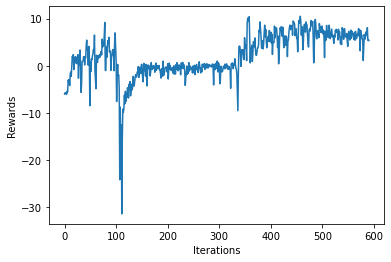

 59%|█████████████████████████████████████████▉                             | 59101/100000 [1:50:01<1:07:52, 10.04it/s]

Updated Weights
Mean Reward = 6.1
9


 59%|██████████████████████████████████████████                             | 59202/100000 [1:50:12<1:17:38,  8.76it/s]

Updated Weights
Mean Reward = 5.21
5


 59%|██████████████████████████████████████████                             | 59302/100000 [1:50:22<1:15:48,  8.95it/s]

Updated Weights
Mean Reward = 6.56
5


 59%|██████████████████████████████████████████▏                            | 59402/100000 [1:50:32<1:10:41,  9.57it/s]

Updated Weights
Mean Reward = 7.86
6


 59%|██████████████████████████████████████████▏                            | 59499/100000 [1:50:43<1:08:30,  9.85it/s]

Updated Weights
Mean Reward = 7.59
2


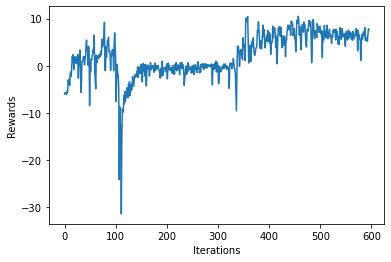

 60%|██████████████████████████████████████████▎                            | 59602/100000 [1:50:53<1:09:20,  9.71it/s]

Updated Weights
Mean Reward = 8.31
10


 60%|██████████████████████████████████████████▍                            | 59702/100000 [1:51:04<1:11:52,  9.34it/s]

Updated Weights
Mean Reward = 7.69
5


 60%|██████████████████████████████████████████▍                            | 59801/100000 [1:51:14<1:08:02,  9.85it/s]

Updated Weights
Mean Reward = 5.21
3


 60%|██████████████████████████████████████████▌                            | 59902/100000 [1:51:25<1:13:56,  9.04it/s]

Updated Weights
Mean Reward = 7.63
6


 60%|██████████████████████████████████████████▌                            | 60000/100000 [1:51:35<1:10:38,  9.44it/s]

Updated Weights
Mean Reward = 7.61
2


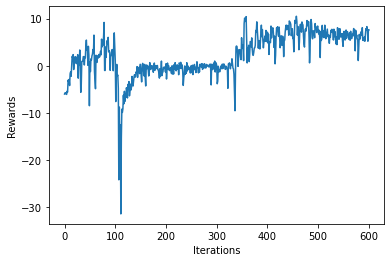

 60%|███████████████████████████████████████████▊                             | 60101/100000 [1:51:46<50:48, 13.09it/s]

Updated Weights
Mean Reward = 5.97
8


 60%|██████████████████████████████████████████▋                            | 60201/100000 [1:51:56<1:07:44,  9.79it/s]

Updated Weights
Mean Reward = 7.19
7


 60%|██████████████████████████████████████████▊                            | 60301/100000 [1:52:06<1:06:42,  9.92it/s]

Updated Weights
Mean Reward = 7.7
6


 60%|██████████████████████████████████████████▉                            | 60402/100000 [1:52:17<1:06:56,  9.86it/s]

Updated Weights
Mean Reward = 3.49
4


 60%|██████████████████████████████████████████▉                            | 60500/100000 [1:52:27<1:12:20,  9.10it/s]

Updated Weights
Mean Reward = 6.21
2


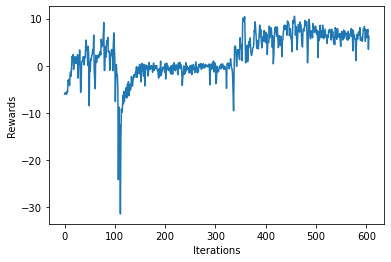

 61%|███████████████████████████████████████████                            | 60601/100000 [1:52:37<1:03:39, 10.31it/s]

Updated Weights
Mean Reward = 7.32
9


 61%|███████████████████████████████████████████                            | 60701/100000 [1:52:48<1:08:10,  9.61it/s]

Updated Weights
Mean Reward = 4.71
5


 61%|███████████████████████████████████████████▏                           | 60802/100000 [1:52:58<1:12:31,  9.01it/s]

Updated Weights
Mean Reward = 6.21
8


 61%|███████████████████████████████████████████▏                           | 60901/100000 [1:53:09<1:11:16,  9.14it/s]

Updated Weights
Mean Reward = 6.06
2


 61%|███████████████████████████████████████████▎                           | 60999/100000 [1:53:19<1:01:55, 10.50it/s]

Updated Weights
Mean Reward = 6.82
7


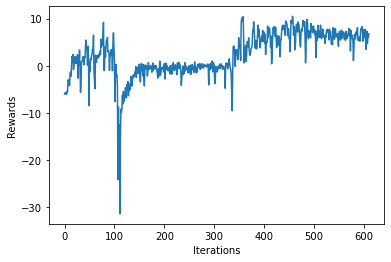

 61%|███████████████████████████████████████████▍                           | 61102/100000 [1:53:29<1:07:02,  9.67it/s]

Updated Weights
Mean Reward = 5.89
7


 61%|███████████████████████████████████████████▍                           | 61202/100000 [1:53:40<1:09:51,  9.26it/s]

Updated Weights
Mean Reward = 8.01
5


 61%|███████████████████████████████████████████▌                           | 61302/100000 [1:53:50<1:01:09, 10.55it/s]

Updated Weights
Mean Reward = 6.36
6


 61%|███████████████████████████████████████████▌                           | 61402/100000 [1:54:00<1:10:35,  9.11it/s]

Updated Weights
Mean Reward = 6.04
5


 61%|███████████████████████████████████████████▋                           | 61499/100000 [1:54:10<1:05:26,  9.80it/s]

Updated Weights
Mean Reward = 6.73
5


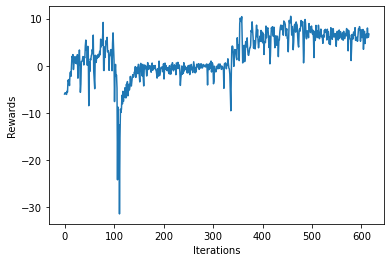

 62%|███████████████████████████████████████████▋                           | 61602/100000 [1:54:21<1:10:12,  9.12it/s]

Updated Weights
Mean Reward = 7.58
4


 62%|█████████████████████████████████████████████                            | 61703/100000 [1:54:32<59:51, 10.66it/s]

Updated Weights
Mean Reward = 9.02
5


 62%|█████████████████████████████████████████████                            | 61801/100000 [1:54:42<59:33, 10.69it/s]

Updated Weights
Mean Reward = 6.8
10


 62%|███████████████████████████████████████████▉                           | 61902/100000 [1:54:52<1:08:04,  9.33it/s]

Updated Weights
Mean Reward = 6.75
5


 62%|████████████████████████████████████████████                           | 62000/100000 [1:55:02<1:07:34,  9.37it/s]

Updated Weights
Mean Reward = 6.24
9


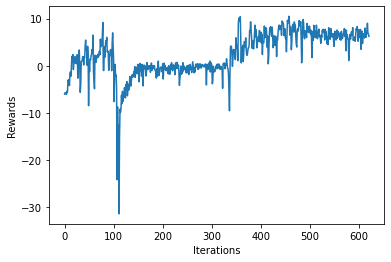

 62%|████████████████████████████████████████████                           | 62102/100000 [1:55:12<1:09:06,  9.14it/s]

Updated Weights
Mean Reward = 6.09
9


 62%|████████████████████████████████████████████▏                          | 62202/100000 [1:55:22<1:08:44,  9.16it/s]

Updated Weights
Mean Reward = 7.92
6


 62%|████████████████████████████████████████████▏                          | 62302/100000 [1:55:33<1:06:18,  9.47it/s]

Updated Weights
Mean Reward = 8.39
3


 62%|████████████████████████████████████████████▎                          | 62402/100000 [1:55:43<1:06:01,  9.49it/s]

Updated Weights
Mean Reward = 7.73
6


 62%|█████████████████████████████████████████████▌                           | 62499/100000 [1:55:53<55:43, 11.21it/s]

Updated Weights
Mean Reward = 6.49
10


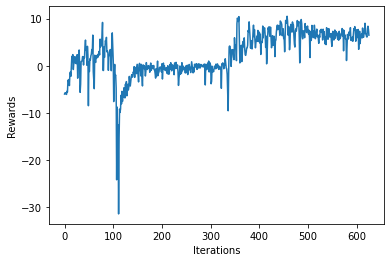

 63%|████████████████████████████████████████████▍                          | 62602/100000 [1:56:03<1:08:10,  9.14it/s]

Updated Weights
Mean Reward = 3.72
10


 63%|████████████████████████████████████████████▌                          | 62702/100000 [1:56:14<1:08:25,  9.08it/s]

Updated Weights
Mean Reward = 5.8
7


 63%|████████████████████████████████████████████▌                          | 62802/100000 [1:56:24<1:07:07,  9.24it/s]

Updated Weights
Mean Reward = 4.48
7


 63%|████████████████████████████████████████████▋                          | 62902/100000 [1:56:34<1:07:59,  9.09it/s]

Updated Weights
Mean Reward = 5.66
4


 63%|████████████████████████████████████████████▋                          | 62999/100000 [1:56:44<1:02:49,  9.82it/s]

Updated Weights
Mean Reward = 9.29
7


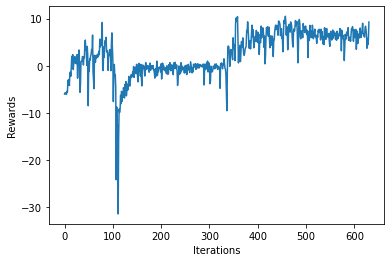

 63%|██████████████████████████████████████████████                           | 63101/100000 [1:56:55<57:07, 10.76it/s]

Updated Weights
Mean Reward = 7.83
9


 63%|██████████████████████████████████████████████▏                          | 63202/100000 [1:57:05<53:49, 11.39it/s]

Updated Weights
Mean Reward = 4.24
8


 63%|████████████████████████████████████████████▉                          | 63302/100000 [1:57:16<1:07:59,  9.00it/s]

Updated Weights
Mean Reward = 7.55
3


 63%|█████████████████████████████████████████████                          | 63402/100000 [1:57:26<1:06:38,  9.15it/s]

Updated Weights
Mean Reward = 6.74
8


 63%|█████████████████████████████████████████████                          | 63499/100000 [1:57:36<1:02:25,  9.75it/s]

Updated Weights
Mean Reward = 2.31
7


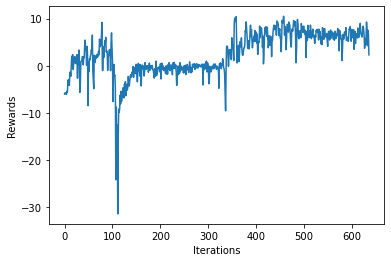

 64%|█████████████████████████████████████████████▏                         | 63602/100000 [1:57:47<1:07:55,  8.93it/s]

Updated Weights
Mean Reward = 7.86
5


 64%|█████████████████████████████████████████████▏                         | 63702/100000 [1:57:57<1:07:27,  8.97it/s]

Updated Weights
Mean Reward = 8.97
4


 64%|█████████████████████████████████████████████▎                         | 63802/100000 [1:58:08<1:07:34,  8.93it/s]

Updated Weights
Mean Reward = 8.61
3


 64%|██████████████████████████████████████████████▋                          | 63902/100000 [1:58:18<59:26, 10.12it/s]

Updated Weights
Mean Reward = 7.26
8


 64%|█████████████████████████████████████████████▍                         | 64000/100000 [1:58:28<1:05:45,  9.12it/s]

Updated Weights
Mean Reward = 7.12
5


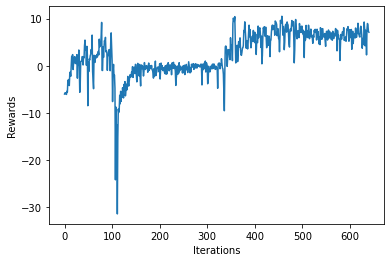

 64%|█████████████████████████████████████████████▌                         | 64102/100000 [1:58:39<1:04:55,  9.22it/s]

Updated Weights
Mean Reward = 8.79
8


 64%|██████████████████████████████████████████████▊                          | 64201/100000 [1:58:49<56:12, 10.61it/s]

Updated Weights
Mean Reward = 8.8
4


 64%|██████████████████████████████████████████████▉                          | 64302/100000 [1:59:00<53:37, 11.10it/s]

Updated Weights
Mean Reward = 7.83
6


 64%|█████████████████████████████████████████████▋                         | 64402/100000 [1:59:10<1:04:16,  9.23it/s]

Updated Weights
Mean Reward = 8.65
6


 64%|█████████████████████████████████████████████▊                         | 64500/100000 [1:59:20<1:03:20,  9.34it/s]

Updated Weights
Mean Reward = 7.77
10


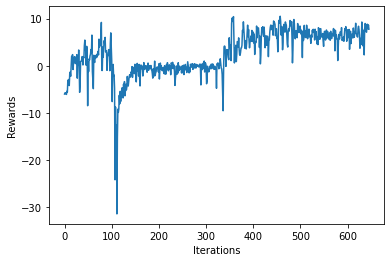

 65%|███████████████████████████████████████████████▏                         | 64602/100000 [1:59:30<58:57, 10.01it/s]

Updated Weights
Mean Reward = 7.51
7


 65%|█████████████████████████████████████████████▉                         | 64702/100000 [1:59:41<1:04:57,  9.06it/s]

Updated Weights
Mean Reward = 8.69
4


 65%|██████████████████████████████████████████████                         | 64801/100000 [1:59:51<1:03:36,  9.22it/s]

Updated Weights
Mean Reward = 6.38
4


 65%|██████████████████████████████████████████████                         | 64902/100000 [2:00:02<1:03:58,  9.14it/s]

Updated Weights
Mean Reward = 6.77
2


 65%|██████████████████████████████████████████████▏                        | 64999/100000 [2:00:12<1:04:27,  9.05it/s]

Updated Weights
Mean Reward = 7.97
3


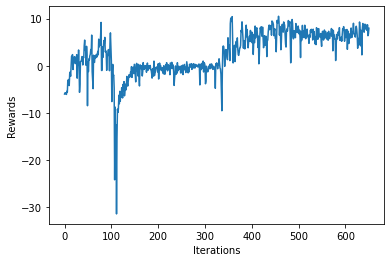

 65%|██████████████████████████████████████████████▏                        | 65102/100000 [2:00:23<1:03:18,  9.19it/s]

Updated Weights
Mean Reward = 6.77
6


 65%|██████████████████████████████████████████████▎                        | 65202/100000 [2:00:33<1:03:27,  9.14it/s]

Updated Weights
Mean Reward = 6.96
4


 65%|███████████████████████████████████████████████▋                         | 65301/100000 [2:00:44<51:59, 11.12it/s]

Updated Weights
Mean Reward = 8.07
6


 65%|██████████████████████████████████████████████▍                        | 65402/100000 [2:00:53<1:02:35,  9.21it/s]

Updated Weights
Mean Reward = 8.74
14


 66%|██████████████████████████████████████████████▌                        | 65500/100000 [2:01:04<1:04:07,  8.97it/s]

Updated Weights
Mean Reward = 6.24
2


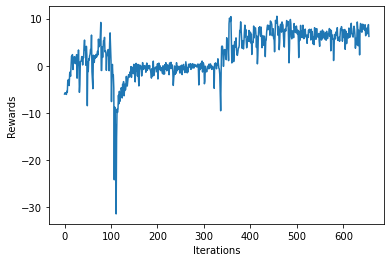

 66%|██████████████████████████████████████████████▌                        | 65602/100000 [2:01:14<1:02:21,  9.19it/s]

Updated Weights
Mean Reward = 6.41
10


 66%|███████████████████████████████████████████████▉                         | 65702/100000 [2:01:25<54:55, 10.41it/s]

Updated Weights
Mean Reward = 7.93
3


 66%|██████████████████████████████████████████████▋                        | 65802/100000 [2:01:35<1:01:26,  9.28it/s]

Updated Weights
Mean Reward = 6.61
6


 66%|████████████████████████████████████████████████                         | 65901/100000 [2:01:45<58:44,  9.67it/s]

Updated Weights
Mean Reward = 5.6
5


 66%|████████████████████████████████████████████████▏                        | 65999/100000 [2:01:56<53:23, 10.62it/s]

Updated Weights
Mean Reward = 6.46
3


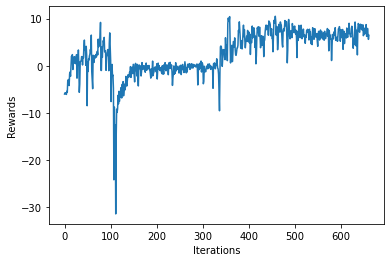

 66%|██████████████████████████████████████████████▉                        | 66102/100000 [2:02:06<1:00:55,  9.27it/s]

Updated Weights
Mean Reward = 7.6
6


 66%|████████████████████████████████████████████████▎                        | 66201/100000 [2:02:17<58:19,  9.66it/s]

Updated Weights
Mean Reward = 5.34
3


 66%|███████████████████████████████████████████████                        | 66302/100000 [2:02:27<1:00:16,  9.32it/s]

Updated Weights
Mean Reward = 6.74
3


 66%|███████████████████████████████████████████████▏                       | 66402/100000 [2:02:38<1:01:59,  9.03it/s]

Updated Weights
Mean Reward = 5.31
6


 66%|████████████████████████████████████████████████▌                        | 66499/100000 [2:02:48<57:00,  9.80it/s]

Updated Weights
Mean Reward = 8.64
4


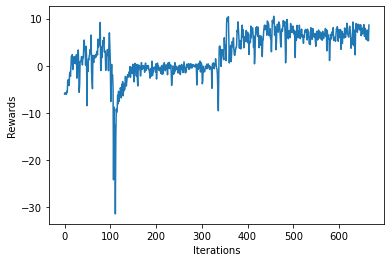

 67%|████████████████████████████████████████████████▌                        | 66601/100000 [2:02:59<59:10,  9.41it/s]

Updated Weights
Mean Reward = 4.71
5


 67%|███████████████████████████████████████████████▎                       | 66702/100000 [2:03:10<1:00:39,  9.15it/s]

Updated Weights
Mean Reward = 4.45
2


 67%|███████████████████████████████████████████████▍                       | 66802/100000 [2:03:20<1:01:29,  9.00it/s]

Updated Weights
Mean Reward = 3.72
6


 67%|████████████████████████████████████████████████▊                        | 66902/100000 [2:03:30<56:33,  9.75it/s]

Updated Weights
Mean Reward = 8.06
8


 67%|███████████████████████████████████████████████▌                       | 67000/100000 [2:03:40<1:00:44,  9.06it/s]

Updated Weights
Mean Reward = 6.45
3


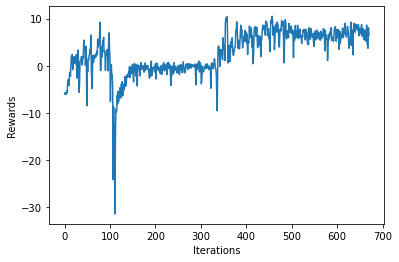

 67%|███████████████████████████████████████████████▋                       | 67102/100000 [2:03:51<1:00:31,  9.06it/s]

Updated Weights
Mean Reward = 7.45
4


 67%|█████████████████████████████████████████████████                        | 67202/100000 [2:04:02<54:05, 10.10it/s]

Updated Weights
Mean Reward = 8.57
4


 67%|█████████████████████████████████████████████████▏                       | 67301/100000 [2:04:12<51:06, 10.66it/s]

Updated Weights
Mean Reward = 5.77
10


 67%|███████████████████████████████████████████████▊                       | 67401/100000 [2:04:22<1:00:10,  9.03it/s]

Updated Weights
Mean Reward = 6.88
5


 68%|█████████████████████████████████████████████████▎                       | 67500/100000 [2:04:32<58:18,  9.29it/s]

Updated Weights
Mean Reward = 7.68
5


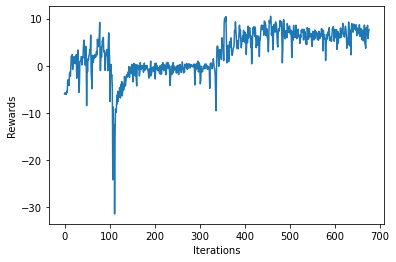

 68%|█████████████████████████████████████████████████▎                       | 67602/100000 [2:04:43<59:00,  9.15it/s]

Updated Weights
Mean Reward = 4.82
8


 68%|█████████████████████████████████████████████████▍                       | 67702/100000 [2:04:53<57:07,  9.42it/s]

Updated Weights
Mean Reward = 5.79
8


 68%|█████████████████████████████████████████████████▍                       | 67802/100000 [2:05:03<45:41, 11.75it/s]

Updated Weights
Mean Reward = 4.96
13


 68%|█████████████████████████████████████████████████▌                       | 67902/100000 [2:05:13<54:52,  9.75it/s]

Updated Weights
Mean Reward = 5.63
9


 68%|█████████████████████████████████████████████████▋                       | 67999/100000 [2:05:23<57:51,  9.22it/s]

Updated Weights
Mean Reward = 5.51
3


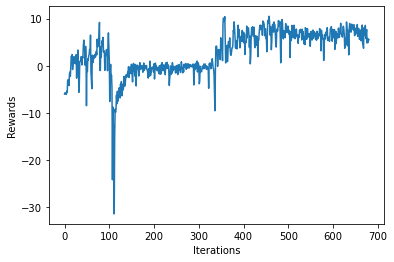

 68%|█████████████████████████████████████████████████▋                       | 68101/100000 [2:05:34<57:50,  9.19it/s]

Updated Weights
Mean Reward = 5.57
1


 68%|█████████████████████████████████████████████████▊                       | 68202/100000 [2:05:45<53:57,  9.82it/s]

Updated Weights
Mean Reward = 9.14
4


 68%|█████████████████████████████████████████████████▊                       | 68302/100000 [2:05:55<58:48,  8.98it/s]

Updated Weights
Mean Reward = 7.34
3


 68%|█████████████████████████████████████████████████▉                       | 68402/100000 [2:06:06<51:16, 10.27it/s]

Updated Weights
Mean Reward = 7.36
5


 68%|██████████████████████████████████████████████████                       | 68500/100000 [2:06:16<57:54,  9.07it/s]

Updated Weights
Mean Reward = 6.9
6


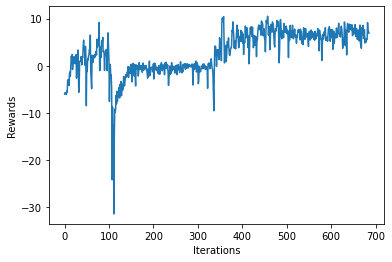

 69%|██████████████████████████████████████████████████                       | 68602/100000 [2:06:26<47:30, 11.02it/s]

Updated Weights
Mean Reward = 7.66
12


 69%|██████████████████████████████████████████████████▏                      | 68702/100000 [2:06:36<57:03,  9.14it/s]

Updated Weights
Mean Reward = 8.17
4


 69%|██████████████████████████████████████████████████▏                      | 68802/100000 [2:06:47<55:07,  9.43it/s]

Updated Weights
Mean Reward = 8.03
8


 69%|██████████████████████████████████████████████████▎                      | 68902/100000 [2:06:57<53:28,  9.69it/s]

Updated Weights
Mean Reward = 7.04
7


 69%|██████████████████████████████████████████████████▎                      | 69000/100000 [2:07:07<53:37,  9.63it/s]

Updated Weights
Mean Reward = 7.18
5


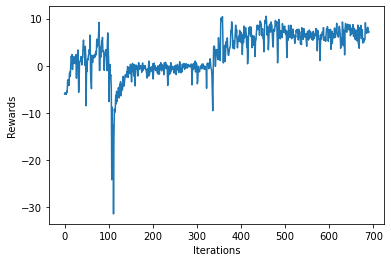

 69%|██████████████████████████████████████████████████▍                      | 69102/100000 [2:07:18<52:44,  9.76it/s]

Updated Weights
Mean Reward = 5.43
5


 69%|██████████████████████████████████████████████████▌                      | 69202/100000 [2:07:28<54:19,  9.45it/s]

Updated Weights
Mean Reward = 6.87
7


 69%|██████████████████████████████████████████████████▌                      | 69301/100000 [2:07:38<56:18,  9.09it/s]

Updated Weights
Mean Reward = 4.62
8


 69%|██████████████████████████████████████████████████▋                      | 69402/100000 [2:07:48<54:47,  9.31it/s]

Updated Weights
Mean Reward = 4.84
6


 70%|██████████████████████████████████████████████████▋                      | 69500/100000 [2:07:59<55:12,  9.21it/s]

Updated Weights
Mean Reward = 6.67
4


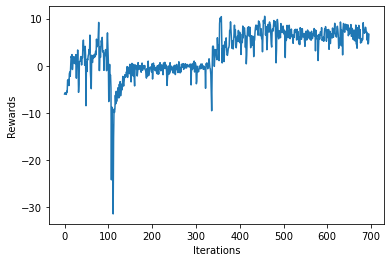

 70%|██████████████████████████████████████████████████▊                      | 69602/100000 [2:08:09<47:43, 10.62it/s]

Updated Weights
Mean Reward = 7.54
7


 70%|██████████████████████████████████████████████████▉                      | 69702/100000 [2:08:20<53:08,  9.50it/s]

Updated Weights
Mean Reward = 8.9
4


 70%|██████████████████████████████████████████████████▉                      | 69802/100000 [2:08:30<56:30,  8.91it/s]

Updated Weights
Mean Reward = 7.42
6


 70%|███████████████████████████████████████████████████                      | 69903/100000 [2:08:40<46:53, 10.70it/s]

Updated Weights
Mean Reward = 7.43
7


 70%|███████████████████████████████████████████████████                      | 70000/100000 [2:08:50<53:58,  9.26it/s]

Updated Weights
Mean Reward = 6.14
6


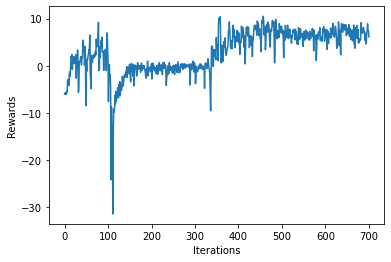

 70%|███████████████████████████████████████████████████▏                     | 70102/100000 [2:09:01<54:58,  9.06it/s]

Updated Weights
Mean Reward = 4.67
4


 70%|███████████████████████████████████████████████████▏                     | 70202/100000 [2:09:11<54:40,  9.08it/s]

Updated Weights
Mean Reward = 4.87
7


 70%|███████████████████████████████████████████████████▎                     | 70302/100000 [2:09:22<54:22,  9.10it/s]

Updated Weights
Mean Reward = 2.16
6


 70%|███████████████████████████████████████████████████▍                     | 70402/100000 [2:09:32<53:03,  9.30it/s]

Updated Weights
Mean Reward = 8.84
7


 70%|███████████████████████████████████████████████████▍                     | 70500/100000 [2:09:42<55:34,  8.85it/s]

Updated Weights
Mean Reward = 8.15
7


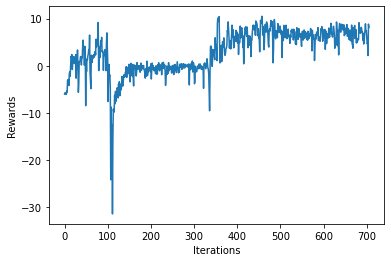

 71%|███████████████████████████████████████████████████▌                     | 70603/100000 [2:09:53<46:11, 10.61it/s]

Updated Weights
Mean Reward = 7.59
4


 71%|███████████████████████████████████████████████████▌                     | 70701/100000 [2:10:03<54:45,  8.92it/s]

Updated Weights
Mean Reward = 7.37
5


 71%|███████████████████████████████████████████████████▋                     | 70802/100000 [2:10:13<45:47, 10.63it/s]

Updated Weights
Mean Reward = 8.26
6


 71%|███████████████████████████████████████████████████▊                     | 70902/100000 [2:10:23<52:00,  9.32it/s]

Updated Weights
Mean Reward = 6.78
9


 71%|███████████████████████████████████████████████████▊                     | 71000/100000 [2:10:33<47:52, 10.10it/s]

Updated Weights
Mean Reward = 8.65
12


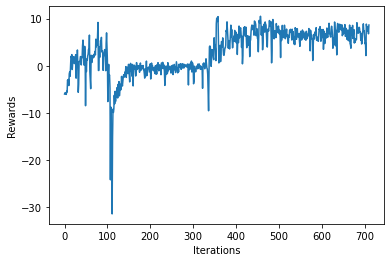

 71%|███████████████████████████████████████████████████▉                     | 71102/100000 [2:10:44<52:13,  9.22it/s]

Updated Weights
Mean Reward = 8.14
7


 71%|███████████████████████████████████████████████████▉                     | 71201/100000 [2:10:54<48:17,  9.94it/s]

Updated Weights
Mean Reward = 4.68
5


 71%|████████████████████████████████████████████████████                     | 71302/100000 [2:11:04<44:07, 10.84it/s]

Updated Weights
Mean Reward = 5.2
8


 71%|████████████████████████████████████████████████████                     | 71402/100000 [2:11:15<53:56,  8.84it/s]

Updated Weights
Mean Reward = 6.84
5


 71%|████████████████████████████████████████████████████▏                    | 71499/100000 [2:11:25<53:04,  8.95it/s]

Updated Weights
Mean Reward = 5.86
2


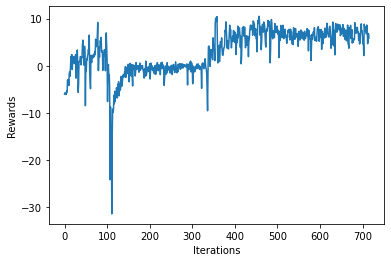

 72%|████████████████████████████████████████████████████▎                    | 71602/100000 [2:11:35<51:09,  9.25it/s]

Updated Weights
Mean Reward = 6.75
8


 72%|████████████████████████████████████████████████████▎                    | 71702/100000 [2:11:46<52:17,  9.02it/s]

Updated Weights
Mean Reward = 8.55
6


 72%|████████████████████████████████████████████████████▍                    | 71801/100000 [2:11:56<48:54,  9.61it/s]

Updated Weights
Mean Reward = 6.96
4


 72%|████████████████████████████████████████████████████▍                    | 71902/100000 [2:12:07<49:54,  9.38it/s]

Updated Weights
Mean Reward = 7.9
6


 72%|████████████████████████████████████████████████████▌                    | 71999/100000 [2:12:16<44:46, 10.42it/s]

Updated Weights
Mean Reward = 7.11
9


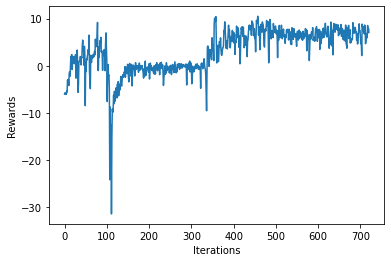

 72%|████████████████████████████████████████████████████▋                    | 72101/100000 [2:12:27<49:01,  9.48it/s]

Updated Weights
Mean Reward = 7.01
5


 72%|████████████████████████████████████████████████████▋                    | 72201/100000 [2:12:38<51:00,  9.08it/s]

Updated Weights
Mean Reward = 6.65
2


 72%|████████████████████████████████████████████████████▊                    | 72303/100000 [2:12:49<41:05, 11.23it/s]

Updated Weights
Mean Reward = 8.36
5


 72%|████████████████████████████████████████████████████▊                    | 72403/100000 [2:13:00<48:16,  9.53it/s]

Updated Weights
Mean Reward = 6.63
6


 72%|████████████████████████████████████████████████████▉                    | 72500/100000 [2:13:09<48:49,  9.39it/s]

Updated Weights
Mean Reward = 7.51
10


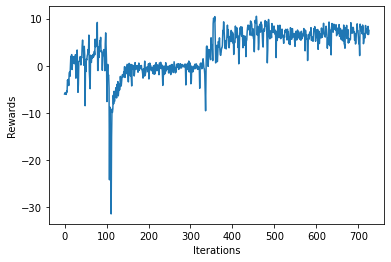

 73%|████████████████████████████████████████████████████▉                    | 72602/100000 [2:13:20<49:33,  9.21it/s]

Updated Weights
Mean Reward = 6.6
6


 73%|█████████████████████████████████████████████████████                    | 72701/100000 [2:13:30<43:15, 10.52it/s]

Updated Weights
Mean Reward = 8.3
5


 73%|█████████████████████████████████████████████████████▏                   | 72803/100000 [2:13:40<49:07,  9.23it/s]

Updated Weights
Mean Reward = 6.27
8


 73%|█████████████████████████████████████████████████████▏                   | 72902/100000 [2:13:51<47:25,  9.52it/s]

Updated Weights
Mean Reward = 7.52
7


 73%|█████████████████████████████████████████████████████▎                   | 72999/100000 [2:14:00<40:33, 11.09it/s]

Updated Weights
Mean Reward = 5.01
12


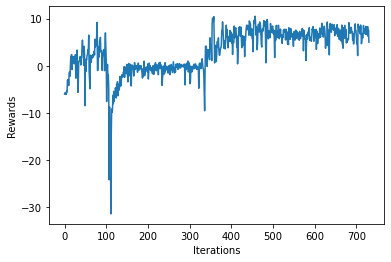

 73%|█████████████████████████████████████████████████████▎                   | 73102/100000 [2:14:11<47:31,  9.43it/s]

Updated Weights
Mean Reward = 8.19
3


 73%|█████████████████████████████████████████████████████▍                   | 73202/100000 [2:14:21<49:16,  9.06it/s]

Updated Weights
Mean Reward = 8.7
5


 73%|█████████████████████████████████████████████████████▌                   | 73302/100000 [2:14:32<42:54, 10.37it/s]

Updated Weights
Mean Reward = 6.29
6


 73%|█████████████████████████████████████████████████████▌                   | 73402/100000 [2:14:42<47:29,  9.34it/s]

Updated Weights
Mean Reward = 6.46
4


 74%|█████████████████████████████████████████████████████▋                   | 73500/100000 [2:14:52<45:51,  9.63it/s]

Updated Weights
Mean Reward = 7.35
8


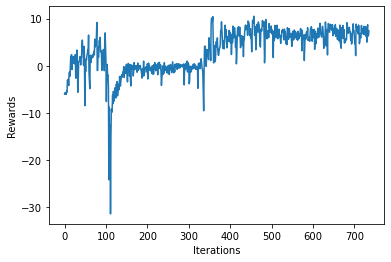

 74%|█████████████████████████████████████████████████████▋                   | 73601/100000 [2:15:03<37:23, 11.77it/s]

Updated Weights
Mean Reward = 2.08
7


 74%|█████████████████████████████████████████████████████▊                   | 73701/100000 [2:15:13<47:35,  9.21it/s]

Updated Weights
Mean Reward = 6.25
2


 74%|█████████████████████████████████████████████████████▉                   | 73802/100000 [2:15:24<43:20, 10.07it/s]

Updated Weights
Mean Reward = 9.49
8


 74%|█████████████████████████████████████████████████████▉                   | 73902/100000 [2:15:34<44:29,  9.78it/s]

Updated Weights
Mean Reward = 8.99
10


 74%|██████████████████████████████████████████████████████                   | 74000/100000 [2:15:44<41:50, 10.36it/s]

Updated Weights
Mean Reward = 9.54
6


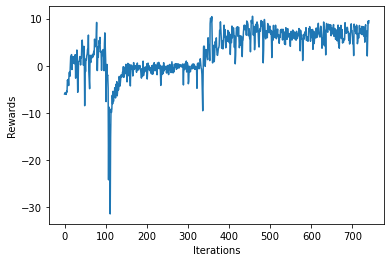

 74%|██████████████████████████████████████████████████████                   | 74101/100000 [2:15:55<39:48, 10.84it/s]

Updated Weights
Mean Reward = 8.61
4


 74%|██████████████████████████████████████████████████████▏                  | 74202/100000 [2:16:05<46:58,  9.15it/s]

Updated Weights
Mean Reward = 5.19
6


 74%|██████████████████████████████████████████████████████▏                  | 74302/100000 [2:16:15<46:07,  9.29it/s]

Updated Weights
Mean Reward = 3.9
8


 74%|██████████████████████████████████████████████████████▎                  | 74402/100000 [2:16:25<45:57,  9.28it/s]

Updated Weights
Mean Reward = 3.46
6


 74%|██████████████████████████████████████████████████████▍                  | 74500/100000 [2:16:35<45:55,  9.25it/s]

Updated Weights
Mean Reward = 5.81
6


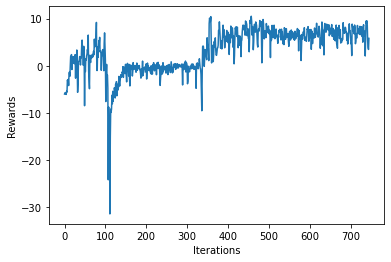

 75%|██████████████████████████████████████████████████████▍                  | 74602/100000 [2:16:46<39:53, 10.61it/s]

Updated Weights
Mean Reward = 7.51
6


 75%|██████████████████████████████████████████████████████▌                  | 74702/100000 [2:16:57<44:34,  9.46it/s]

Updated Weights
Mean Reward = 7.89
4


 75%|██████████████████████████████████████████████████████▌                  | 74802/100000 [2:17:07<42:47,  9.81it/s]

Updated Weights
Mean Reward = 8.94
5


 75%|██████████████████████████████████████████████████████▋                  | 74902/100000 [2:17:18<45:18,  9.23it/s]

Updated Weights
Mean Reward = 8.37
5


 75%|██████████████████████████████████████████████████████▊                  | 75000/100000 [2:17:28<43:04,  9.67it/s]

Updated Weights
Mean Reward = 9.42
2


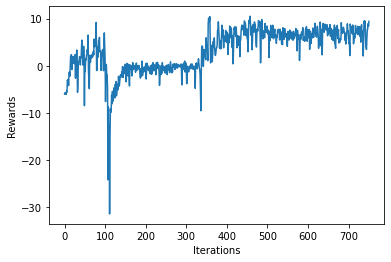

 75%|██████████████████████████████████████████████████████▊                  | 75102/100000 [2:17:39<44:28,  9.33it/s]

Updated Weights
Mean Reward = 7.04
1


 75%|██████████████████████████████████████████████████████▉                  | 75201/100000 [2:17:50<39:41, 10.41it/s]

Updated Weights
Mean Reward = 9.05
7


 75%|██████████████████████████████████████████████████████▉                  | 75302/100000 [2:18:00<43:47,  9.40it/s]

Updated Weights
Mean Reward = 9.61
9


 75%|███████████████████████████████████████████████████████                  | 75402/100000 [2:18:10<34:44, 11.80it/s]

Updated Weights
Mean Reward = 9.54
8


 75%|███████████████████████████████████████████████████████                  | 75499/100000 [2:18:19<44:06,  9.26it/s]

Updated Weights
Mean Reward = 7.42
11


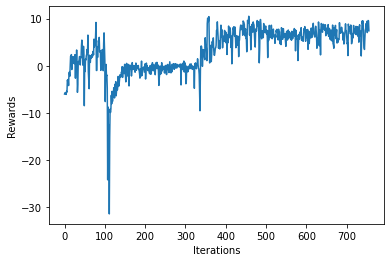

 76%|███████████████████████████████████████████████████████▏                 | 75602/100000 [2:18:30<44:32,  9.13it/s]

Updated Weights
Mean Reward = 7.08
3


 76%|███████████████████████████████████████████████████████▎                 | 75702/100000 [2:18:41<44:50,  9.03it/s]

Updated Weights
Mean Reward = 6.85
4


 76%|███████████████████████████████████████████████████████▎                 | 75801/100000 [2:18:50<38:09, 10.57it/s]

Updated Weights
Mean Reward = 8.49
14


 76%|███████████████████████████████████████████████████████▍                 | 75901/100000 [2:19:01<38:19, 10.48it/s]

Updated Weights
Mean Reward = 8.9
8


 76%|███████████████████████████████████████████████████████▍                 | 76000/100000 [2:19:11<43:18,  9.24it/s]

Updated Weights
Mean Reward = 8.54
7


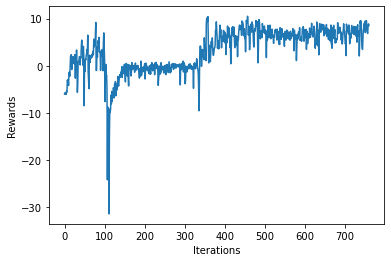

 76%|███████████████████████████████████████████████████████▌                 | 76101/100000 [2:19:22<40:37,  9.80it/s]

Updated Weights
Mean Reward = 6.52
3


 76%|███████████████████████████████████████████████████████▋                 | 76202/100000 [2:19:32<42:48,  9.27it/s]

Updated Weights
Mean Reward = 7.65
9


 76%|███████████████████████████████████████████████████████▋                 | 76302/100000 [2:19:42<40:40,  9.71it/s]

Updated Weights
Mean Reward = 8.7
6


 76%|███████████████████████████████████████████████████████▊                 | 76402/100000 [2:19:52<44:11,  8.90it/s]

Updated Weights
Mean Reward = 9.16
7


 76%|███████████████████████████████████████████████████████▊                 | 76499/100000 [2:20:02<42:53,  9.13it/s]

Updated Weights
Mean Reward = 7.17
5


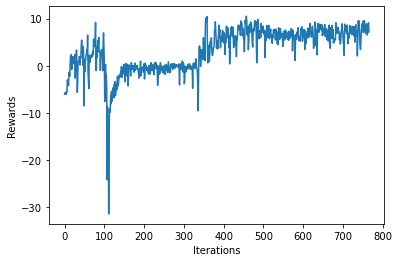

 77%|███████████████████████████████████████████████████████▉                 | 76603/100000 [2:20:13<37:51, 10.30it/s]

Updated Weights
Mean Reward = 6.03
9


 77%|███████████████████████████████████████████████████████▉                 | 76703/100000 [2:20:24<43:20,  8.96it/s]

Updated Weights
Mean Reward = 6.84
3


 77%|████████████████████████████████████████████████████████                 | 76802/100000 [2:20:34<42:11,  9.17it/s]

Updated Weights
Mean Reward = 7.68
3


 77%|████████████████████████████████████████████████████████▏                | 76901/100000 [2:20:44<37:52, 10.17it/s]

Updated Weights
Mean Reward = 8.83
8


 77%|████████████████████████████████████████████████████████▏                | 76999/100000 [2:20:54<39:39,  9.67it/s]

Updated Weights
Mean Reward = 6.94
7


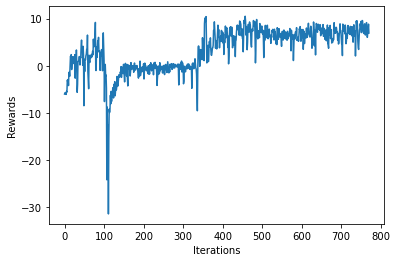

 77%|████████████████████████████████████████████████████████▎                | 77102/100000 [2:21:05<38:53,  9.81it/s]

Updated Weights
Mean Reward = 6.32
5


 77%|████████████████████████████████████████████████████████▎                | 77202/100000 [2:21:16<37:10, 10.22it/s]

Updated Weights
Mean Reward = -2.23
6


 77%|████████████████████████████████████████████████████████▍                | 77302/100000 [2:21:26<41:08,  9.19it/s]

Updated Weights
Mean Reward = 3.39
4


 77%|████████████████████████████████████████████████████████▌                | 77401/100000 [2:21:36<38:31,  9.78it/s]

Updated Weights
Mean Reward = 6.48
7


 78%|████████████████████████████████████████████████████████▌                | 77500/100000 [2:21:47<40:49,  9.19it/s]

Updated Weights
Mean Reward = 4.96
3


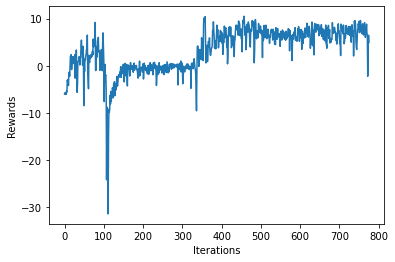

 78%|████████████████████████████████████████████████████████▋                | 77602/100000 [2:21:57<35:03, 10.65it/s]

Updated Weights
Mean Reward = 5.56
5


 78%|████████████████████████████████████████████████████████▋                | 77702/100000 [2:22:08<40:55,  9.08it/s]

Updated Weights
Mean Reward = 4.38
2


 78%|████████████████████████████████████████████████████████▊                | 77802/100000 [2:22:19<40:02,  9.24it/s]

Updated Weights
Mean Reward = 6.33
3


 78%|████████████████████████████████████████████████████████▊                | 77902/100000 [2:22:29<39:42,  9.28it/s]

Updated Weights
Mean Reward = 5.74
3


 78%|████████████████████████████████████████████████████████▉                | 78000/100000 [2:22:39<39:44,  9.23it/s]

Updated Weights
Mean Reward = 7.0
6


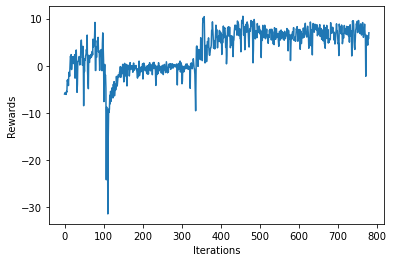

 78%|█████████████████████████████████████████████████████████                | 78102/100000 [2:22:50<37:08,  9.83it/s]

Updated Weights
Mean Reward = 5.09
6


 78%|█████████████████████████████████████████████████████████                | 78202/100000 [2:23:01<38:37,  9.41it/s]

Updated Weights
Mean Reward = 7.04
2


 78%|█████████████████████████████████████████████████████████▏               | 78302/100000 [2:23:11<34:32, 10.47it/s]

Updated Weights
Mean Reward = 5.94
4


 78%|█████████████████████████████████████████████████████████▏               | 78402/100000 [2:23:22<40:49,  8.82it/s]

Updated Weights
Mean Reward = 6.42
2


 78%|█████████████████████████████████████████████████████████▎               | 78499/100000 [2:23:32<33:28, 10.70it/s]

Updated Weights
Mean Reward = 6.31
3


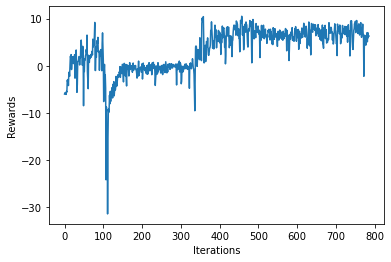

 79%|█████████████████████████████████████████████████████████▍               | 78601/100000 [2:23:43<39:08,  9.11it/s]

Updated Weights
Mean Reward = 7.19
4


 79%|█████████████████████████████████████████████████████████▍               | 78702/100000 [2:23:54<38:35,  9.20it/s]

Updated Weights
Mean Reward = 8.55
5


 79%|█████████████████████████████████████████████████████████▌               | 78802/100000 [2:24:04<33:46, 10.46it/s]

Updated Weights
Mean Reward = 6.09
3


 79%|█████████████████████████████████████████████████████████▌               | 78903/100000 [2:24:15<32:58, 10.66it/s]

Updated Weights
Mean Reward = 7.74
2


 79%|█████████████████████████████████████████████████████████▋               | 79000/100000 [2:24:25<37:13,  9.40it/s]

Updated Weights
Mean Reward = 7.17
5


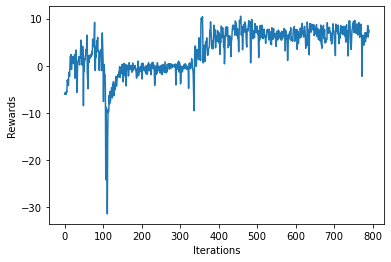

 79%|█████████████████████████████████████████████████████████▋               | 79103/100000 [2:24:36<33:06, 10.52it/s]

Updated Weights
Mean Reward = 6.71
2


 79%|█████████████████████████████████████████████████████████▊               | 79201/100000 [2:24:46<35:17,  9.82it/s]

Updated Weights
Mean Reward = 8.62
6


 79%|█████████████████████████████████████████████████████████▉               | 79302/100000 [2:24:57<36:54,  9.35it/s]

Updated Weights
Mean Reward = 9.05
5


 79%|█████████████████████████████████████████████████████████▉               | 79402/100000 [2:25:07<31:07, 11.03it/s]

Updated Weights
Mean Reward = 9.15
5


 80%|██████████████████████████████████████████████████████████               | 79500/100000 [2:25:17<33:29, 10.20it/s]

Updated Weights
Mean Reward = 5.9
6


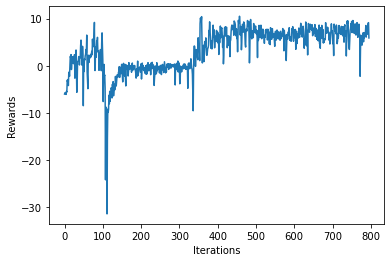

 80%|██████████████████████████████████████████████████████████               | 79602/100000 [2:25:28<37:44,  9.01it/s]

Updated Weights
Mean Reward = 8.81
2


 80%|██████████████████████████████████████████████████████████▏              | 79702/100000 [2:25:38<35:31,  9.52it/s]

Updated Weights
Mean Reward = 5.9
6


 80%|██████████████████████████████████████████████████████████▎              | 79802/100000 [2:25:49<25:28, 13.21it/s]

Updated Weights
Mean Reward = 7.95
3


 80%|██████████████████████████████████████████████████████████▎              | 79902/100000 [2:25:59<35:29,  9.44it/s]

Updated Weights
Mean Reward = 6.31
7


 80%|██████████████████████████████████████████████████████████▍              | 79999/100000 [2:26:09<36:30,  9.13it/s]

Updated Weights
Mean Reward = 7.99
5


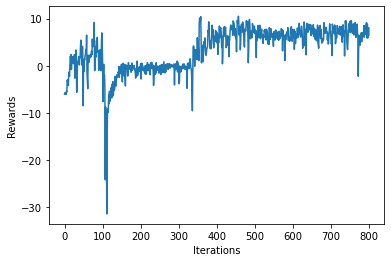

 80%|██████████████████████████████████████████████████████████▍              | 80102/100000 [2:26:20<36:33,  9.07it/s]

Updated Weights
Mean Reward = 6.14
10


 80%|██████████████████████████████████████████████████████████▌              | 80202/100000 [2:26:30<32:52, 10.04it/s]

Updated Weights
Mean Reward = 8.87
6


 80%|██████████████████████████████████████████████████████████▌              | 80302/100000 [2:26:40<38:12,  8.59it/s]

Updated Weights
Mean Reward = 7.15
5


 80%|██████████████████████████████████████████████████████████▋              | 80402/100000 [2:26:51<36:24,  8.97it/s]

Updated Weights
Mean Reward = 9.17
7


 80%|██████████████████████████████████████████████████████████▊              | 80500/100000 [2:27:01<32:13, 10.09it/s]

Updated Weights
Mean Reward = 7.1
8


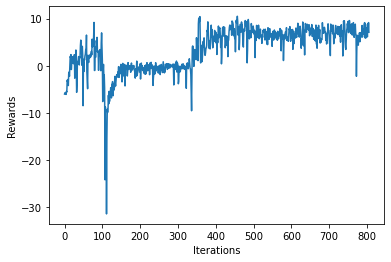

 81%|██████████████████████████████████████████████████████████▊              | 80602/100000 [2:27:11<35:20,  9.15it/s]

Updated Weights
Mean Reward = 8.28
3


 81%|██████████████████████████████████████████████████████████▉              | 80703/100000 [2:27:22<30:59, 10.38it/s]

Updated Weights
Mean Reward = 8.54
8


 81%|██████████████████████████████████████████████████████████▉              | 80802/100000 [2:27:32<32:21,  9.89it/s]

Updated Weights
Mean Reward = 8.16
9


 81%|███████████████████████████████████████████████████████████              | 80902/100000 [2:27:42<31:58,  9.95it/s]

Updated Weights
Mean Reward = 7.6
4


 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [2:27:53<33:30,  9.45it/s]

Updated Weights
Mean Reward = 8.59
4


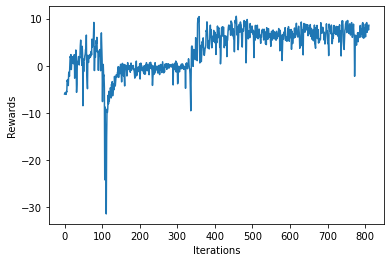

 81%|███████████████████████████████████████████████████████████▏             | 81103/100000 [2:28:03<33:21,  9.44it/s]

Updated Weights
Mean Reward = 7.71
4


 81%|███████████████████████████████████████████████████████████▎             | 81202/100000 [2:28:14<32:33,  9.62it/s]

Updated Weights
Mean Reward = 7.9
5


 81%|███████████████████████████████████████████████████████████▎             | 81302/100000 [2:28:24<35:47,  8.71it/s]

Updated Weights
Mean Reward = 8.03
9


 81%|███████████████████████████████████████████████████████████▍             | 81403/100000 [2:28:34<30:14, 10.25it/s]

Updated Weights
Mean Reward = 7.09
5


 82%|███████████████████████████████████████████████████████████▍             | 81500/100000 [2:28:44<31:50,  9.68it/s]

Updated Weights
Mean Reward = 7.61
8


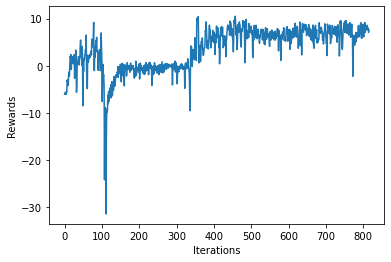

 82%|███████████████████████████████████████████████████████████▌             | 81602/100000 [2:28:55<32:41,  9.38it/s]

Updated Weights
Mean Reward = 8.79
5


 82%|███████████████████████████████████████████████████████████▋             | 81703/100000 [2:29:05<27:25, 11.12it/s]

Updated Weights
Mean Reward = 8.79
6


 82%|███████████████████████████████████████████████████████████▋             | 81802/100000 [2:29:15<33:02,  9.18it/s]

Updated Weights
Mean Reward = 8.33
10


 82%|███████████████████████████████████████████████████████████▊             | 81902/100000 [2:29:25<29:09, 10.35it/s]

Updated Weights
Mean Reward = 8.36
7


 82%|███████████████████████████████████████████████████████████▊             | 81999/100000 [2:29:35<30:46,  9.75it/s]

Updated Weights
Mean Reward = 8.14
9


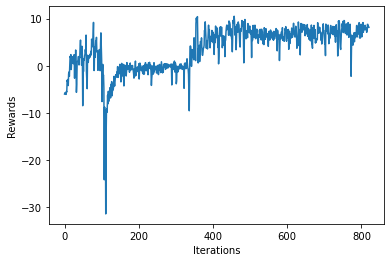

 82%|███████████████████████████████████████████████████████████▉             | 82102/100000 [2:29:46<32:23,  9.21it/s]

Updated Weights
Mean Reward = 8.15
7


 82%|████████████████████████████████████████████████████████████             | 82202/100000 [2:29:56<30:45,  9.64it/s]

Updated Weights
Mean Reward = 8.1
7


 82%|████████████████████████████████████████████████████████████             | 82302/100000 [2:30:06<32:08,  9.18it/s]

Updated Weights
Mean Reward = 7.56
4


 82%|████████████████████████████████████████████████████████████▏            | 82401/100000 [2:30:16<28:28, 10.30it/s]

Updated Weights
Mean Reward = 3.38
9


 82%|████████████████████████████████████████████████████████████▏            | 82500/100000 [2:30:27<31:32,  9.25it/s]

Updated Weights
Mean Reward = 7.3
3


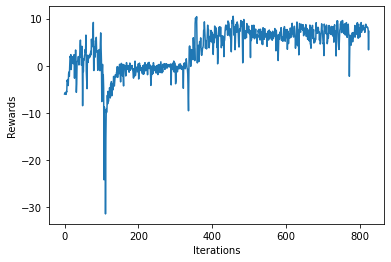

 83%|████████████████████████████████████████████████████████████▎            | 82602/100000 [2:30:37<31:02,  9.34it/s]

Updated Weights
Mean Reward = 8.2
5


 83%|████████████████████████████████████████████████████████████▎            | 82703/100000 [2:30:48<27:09, 10.62it/s]

Updated Weights
Mean Reward = 7.84
6


 83%|████████████████████████████████████████████████████████████▍            | 82802/100000 [2:30:58<30:48,  9.30it/s]

Updated Weights
Mean Reward = 7.94
6


 83%|████████████████████████████████████████████████████████████▌            | 82902/100000 [2:31:08<30:09,  9.45it/s]

Updated Weights
Mean Reward = 8.31
7


 83%|████████████████████████████████████████████████████████████▌            | 83000/100000 [2:31:18<30:07,  9.41it/s]

Updated Weights
Mean Reward = 7.88
10


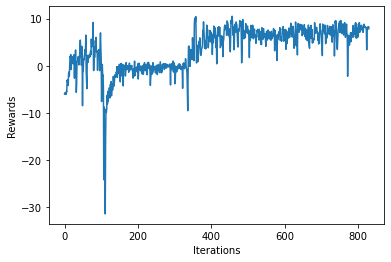

 83%|████████████████████████████████████████████████████████████▋            | 83102/100000 [2:31:29<30:13,  9.32it/s]

Updated Weights
Mean Reward = 6.6
7


 83%|████████████████████████████████████████████████████████████▋            | 83201/100000 [2:31:39<27:45, 10.09it/s]

Updated Weights
Mean Reward = 8.09
6


 83%|████████████████████████████████████████████████████████████▊            | 83302/100000 [2:31:50<29:28,  9.44it/s]

Updated Weights
Mean Reward = 7.28
5


 83%|████████████████████████████████████████████████████████████▉            | 83401/100000 [2:32:00<27:24, 10.10it/s]

Updated Weights
Mean Reward = 6.46
2


 83%|████████████████████████████████████████████████████████████▉            | 83499/100000 [2:32:10<28:14,  9.74it/s]

Updated Weights
Mean Reward = 8.12
10


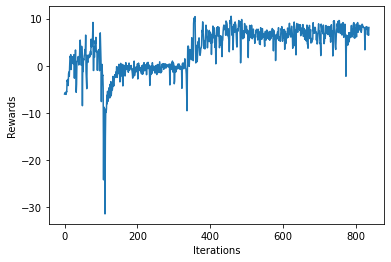

 84%|█████████████████████████████████████████████████████████████            | 83602/100000 [2:32:20<28:06,  9.72it/s]

Updated Weights
Mean Reward = 6.69
9


 84%|█████████████████████████████████████████████████████████████            | 83702/100000 [2:32:31<29:43,  9.14it/s]

Updated Weights
Mean Reward = 7.62
5


 84%|█████████████████████████████████████████████████████████████▏           | 83802/100000 [2:32:41<33:16,  8.11it/s]

Updated Weights
Mean Reward = 6.92
7


 84%|█████████████████████████████████████████████████████████████▏           | 83901/100000 [2:32:51<27:04,  9.91it/s]

Updated Weights
Mean Reward = 5.83
8


 84%|█████████████████████████████████████████████████████████████▎           | 84000/100000 [2:33:01<28:39,  9.31it/s]

Updated Weights
Mean Reward = 8.8
6


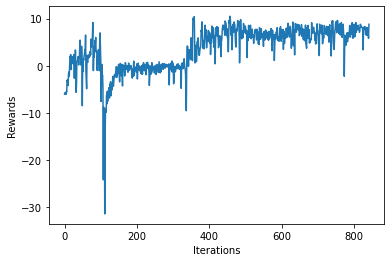

 84%|█████████████████████████████████████████████████████████████▍           | 84102/100000 [2:33:12<27:37,  9.59it/s]

Updated Weights
Mean Reward = 9.34
7


 84%|█████████████████████████████████████████████████████████████▍           | 84202/100000 [2:33:22<28:51,  9.12it/s]

Updated Weights
Mean Reward = 7.9
4


 84%|█████████████████████████████████████████████████████████████▌           | 84302/100000 [2:33:33<29:11,  8.96it/s]

Updated Weights
Mean Reward = 7.1
3


 84%|█████████████████████████████████████████████████████████████▌           | 84403/100000 [2:33:43<23:33, 11.04it/s]

Updated Weights
Mean Reward = 9.92
10


 84%|█████████████████████████████████████████████████████████████▋           | 84500/100000 [2:33:53<27:54,  9.26it/s]

Updated Weights
Mean Reward = 6.7
6


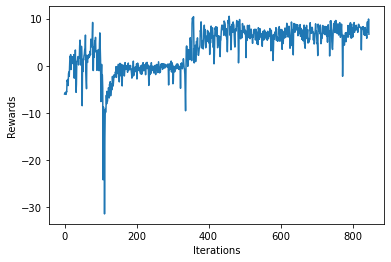

 85%|█████████████████████████████████████████████████████████████▊           | 84601/100000 [2:34:03<24:25, 10.51it/s]

Updated Weights
Mean Reward = 7.61
13


 85%|█████████████████████████████████████████████████████████████▊           | 84702/100000 [2:34:14<26:45,  9.53it/s]

Updated Weights
Mean Reward = 6.13
8


 85%|█████████████████████████████████████████████████████████████▉           | 84801/100000 [2:34:24<28:29,  8.89it/s]

Updated Weights
Mean Reward = 6.87
6


 85%|█████████████████████████████████████████████████████████████▉           | 84902/100000 [2:34:34<26:31,  9.49it/s]

Updated Weights
Mean Reward = 6.81
11


 85%|██████████████████████████████████████████████████████████████           | 84999/100000 [2:34:44<24:09, 10.35it/s]

Updated Weights
Mean Reward = 8.37
8


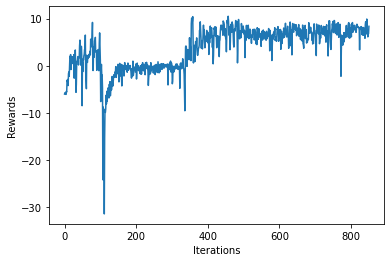

 85%|██████████████████████████████████████████████████████████████           | 85102/100000 [2:34:54<23:29, 10.57it/s]

Updated Weights
Mean Reward = 4.71
5


 85%|██████████████████████████████████████████████████████████████▏          | 85202/100000 [2:35:05<26:37,  9.26it/s]

Updated Weights
Mean Reward = 4.07
7


 85%|██████████████████████████████████████████████████████████████▎          | 85302/100000 [2:35:15<27:24,  8.94it/s]

Updated Weights
Mean Reward = 7.08
7


 85%|██████████████████████████████████████████████████████████████▎          | 85403/100000 [2:35:25<26:00,  9.35it/s]

Updated Weights
Mean Reward = 8.03
6


 86%|██████████████████████████████████████████████████████████████▍          | 85500/100000 [2:35:35<25:45,  9.38it/s]

Updated Weights
Mean Reward = 7.88
9


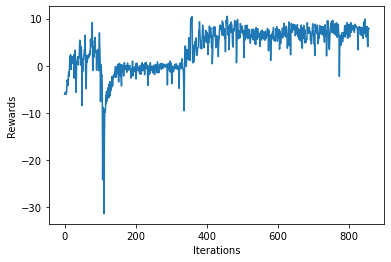

 86%|██████████████████████████████████████████████████████████████▍          | 85602/100000 [2:35:46<26:29,  9.06it/s]

Updated Weights
Mean Reward = 7.45
8


 86%|██████████████████████████████████████████████████████████████▌          | 85703/100000 [2:35:56<24:31,  9.71it/s]

Updated Weights
Mean Reward = 6.87
4


 86%|██████████████████████████████████████████████████████████████▋          | 85803/100000 [2:36:06<21:07, 11.20it/s]

Updated Weights
Mean Reward = 6.84
7


 86%|██████████████████████████████████████████████████████████████▋          | 85902/100000 [2:36:16<24:44,  9.50it/s]

Updated Weights
Mean Reward = 7.35
11


 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [2:36:26<22:12, 10.50it/s]

Updated Weights
Mean Reward = 8.31
5


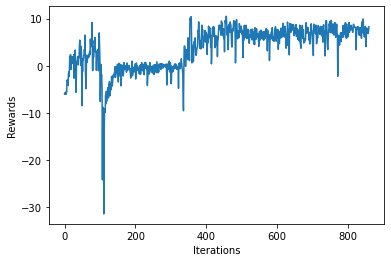

 86%|██████████████████████████████████████████████████████████████▊          | 86101/100000 [2:36:37<23:44,  9.75it/s]

Updated Weights
Mean Reward = 8.74
9


 86%|██████████████████████████████████████████████████████████████▉          | 86201/100000 [2:36:47<24:13,  9.50it/s]

Updated Weights
Mean Reward = 8.56
6


 86%|███████████████████████████████████████████████████████████████          | 86302/100000 [2:36:57<24:30,  9.31it/s]

Updated Weights
Mean Reward = 2.97
6


 86%|███████████████████████████████████████████████████████████████          | 86402/100000 [2:37:08<20:32, 11.03it/s]

Updated Weights
Mean Reward = 3.68
7


 86%|███████████████████████████████████████████████████████████████▏         | 86500/100000 [2:37:18<24:50,  9.06it/s]

Updated Weights
Mean Reward = 8.24
6


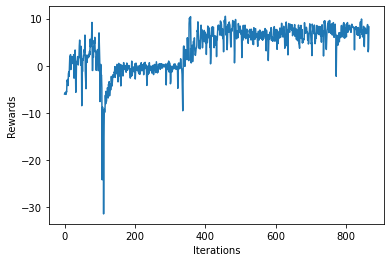

 87%|███████████████████████████████████████████████████████████████▏         | 86602/100000 [2:37:28<24:37,  9.07it/s]

Updated Weights
Mean Reward = 8.42
7


 87%|███████████████████████████████████████████████████████████████▎         | 86702/100000 [2:37:38<24:49,  8.93it/s]

Updated Weights
Mean Reward = 7.63
7


 87%|███████████████████████████████████████████████████████████████▎         | 86802/100000 [2:37:49<24:23,  9.02it/s]

Updated Weights
Mean Reward = 9.38
1


 87%|███████████████████████████████████████████████████████████████▍         | 86901/100000 [2:37:59<23:14,  9.39it/s]

Updated Weights
Mean Reward = 7.92
5


 87%|███████████████████████████████████████████████████████████████▌         | 87000/100000 [2:38:10<23:24,  9.25it/s]

Updated Weights
Mean Reward = 6.88
3


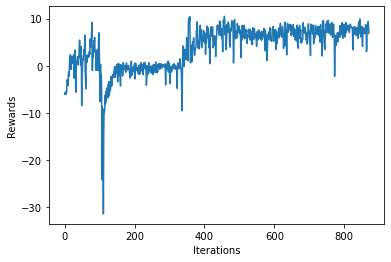

 87%|███████████████████████████████████████████████████████████████▌         | 87102/100000 [2:38:20<22:17,  9.65it/s]

Updated Weights
Mean Reward = 8.41
10


 87%|███████████████████████████████████████████████████████████████▋         | 87202/100000 [2:38:31<21:56,  9.72it/s]

Updated Weights
Mean Reward = 6.78
5


 87%|███████████████████████████████████████████████████████████████▋         | 87302/100000 [2:38:41<25:52,  8.18it/s]

Updated Weights
Mean Reward = 8.5
5


 87%|███████████████████████████████████████████████████████████████▊         | 87402/100000 [2:38:52<22:12,  9.46it/s]

Updated Weights
Mean Reward = 7.58
6


 88%|███████████████████████████████████████████████████████████████▉         | 87500/100000 [2:39:02<22:37,  9.21it/s]

Updated Weights
Mean Reward = 8.77
3


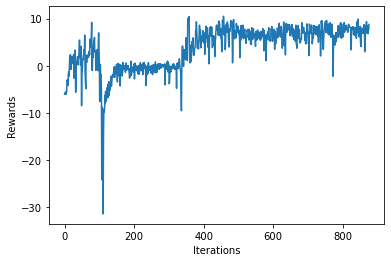

 88%|███████████████████████████████████████████████████████████████▉         | 87602/100000 [2:39:13<22:42,  9.10it/s]

Updated Weights
Mean Reward = 6.74
6


 88%|████████████████████████████████████████████████████████████████         | 87702/100000 [2:39:23<22:21,  9.17it/s]

Updated Weights
Mean Reward = 9.05
4


 88%|████████████████████████████████████████████████████████████████         | 87802/100000 [2:39:34<22:09,  9.18it/s]

Updated Weights
Mean Reward = 9.1
2


 88%|████████████████████████████████████████████████████████████████▏        | 87902/100000 [2:39:44<22:21,  9.02it/s]

Updated Weights
Mean Reward = 8.49
4


 88%|████████████████████████████████████████████████████████████████▏        | 87999/100000 [2:39:55<21:53,  9.13it/s]

Updated Weights
Mean Reward = 8.74
3


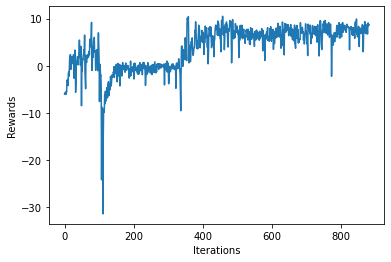

 88%|████████████████████████████████████████████████████████████████▎        | 88102/100000 [2:40:05<19:27, 10.19it/s]

Updated Weights
Mean Reward = 8.17
6


 88%|████████████████████████████████████████████████████████████████▍        | 88202/100000 [2:40:16<21:30,  9.14it/s]

Updated Weights
Mean Reward = 6.9
5


 88%|████████████████████████████████████████████████████████████████▍        | 88303/100000 [2:40:25<16:55, 11.52it/s]

Updated Weights
Mean Reward = 7.38
12


 88%|████████████████████████████████████████████████████████████████▌        | 88401/100000 [2:40:36<21:07,  9.15it/s]

Updated Weights
Mean Reward = 7.29
6


 88%|████████████████████████████████████████████████████████████████▌        | 88500/100000 [2:40:46<20:48,  9.21it/s]

Updated Weights
Mean Reward = 6.32
5


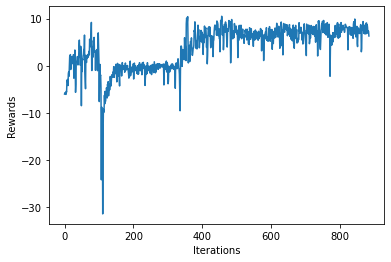

 89%|████████████████████████████████████████████████████████████████▋        | 88603/100000 [2:40:57<18:16, 10.40it/s]

Updated Weights
Mean Reward = 8.56
6


 89%|████████████████████████████████████████████████████████████████▊        | 88702/100000 [2:41:07<20:47,  9.06it/s]

Updated Weights
Mean Reward = 8.44
5


 89%|████████████████████████████████████████████████████████████████▊        | 88802/100000 [2:41:17<20:11,  9.24it/s]

Updated Weights
Mean Reward = 7.4
9


 89%|████████████████████████████████████████████████████████████████▉        | 88902/100000 [2:41:28<20:31,  9.02it/s]

Updated Weights
Mean Reward = 8.03
4


 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [2:41:37<19:37,  9.34it/s]

Updated Weights
Mean Reward = 7.92
9


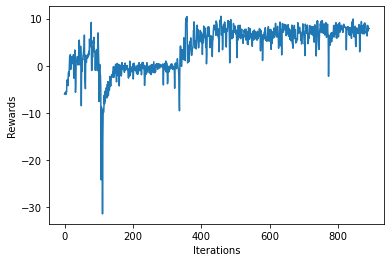

 89%|█████████████████████████████████████████████████████████████████        | 89103/100000 [2:41:48<17:28, 10.39it/s]

Updated Weights
Mean Reward = 5.4
4


 89%|█████████████████████████████████████████████████████████████████        | 89202/100000 [2:41:58<19:05,  9.42it/s]

Updated Weights
Mean Reward = 6.41
7


 89%|█████████████████████████████████████████████████████████████████▏       | 89302/100000 [2:42:08<18:05,  9.86it/s]

Updated Weights
Mean Reward = 8.5
9


 89%|█████████████████████████████████████████████████████████████████▎       | 89402/100000 [2:42:19<18:10,  9.71it/s]

Updated Weights
Mean Reward = 7.89
6


 90%|█████████████████████████████████████████████████████████████████▎       | 89500/100000 [2:42:28<17:56,  9.75it/s]

Updated Weights
Mean Reward = 7.84
10


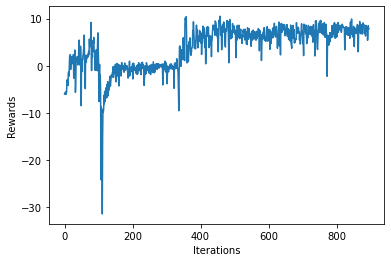

 90%|█████████████████████████████████████████████████████████████████▍       | 89602/100000 [2:42:39<19:25,  8.92it/s]

Updated Weights
Mean Reward = 6.99
2


 90%|█████████████████████████████████████████████████████████████████▍       | 89702/100000 [2:42:50<18:24,  9.32it/s]

Updated Weights
Mean Reward = 7.99
8


 90%|█████████████████████████████████████████████████████████████████▌       | 89802/100000 [2:43:00<17:13,  9.87it/s]

Updated Weights
Mean Reward = 7.01
8


 90%|█████████████████████████████████████████████████████████████████▋       | 89902/100000 [2:43:10<18:00,  9.35it/s]

Updated Weights
Mean Reward = 6.89
6


 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [2:43:20<17:13,  9.68it/s]

Updated Weights
Mean Reward = 6.47
7


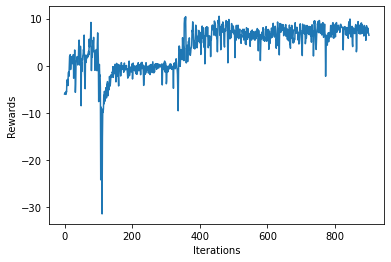

 90%|█████████████████████████████████████████████████████████████████▊       | 90102/100000 [2:43:31<17:36,  9.37it/s]

Updated Weights
Mean Reward = 7.83
10


 90%|█████████████████████████████████████████████████████████████████▊       | 90202/100000 [2:43:41<17:46,  9.19it/s]

Updated Weights
Mean Reward = 6.54
8


 90%|█████████████████████████████████████████████████████████████████▉       | 90303/100000 [2:43:51<17:26,  9.27it/s]

Updated Weights
Mean Reward = 6.69
2


 90%|█████████████████████████████████████████████████████████████████▉       | 90401/100000 [2:44:01<14:07, 11.33it/s]

Updated Weights
Mean Reward = 8.83
13


 90%|██████████████████████████████████████████████████████████████████       | 90500/100000 [2:44:11<15:55,  9.94it/s]

Updated Weights
Mean Reward = 7.6
5


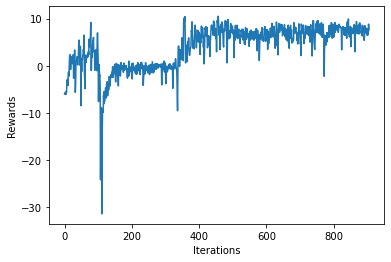

 91%|██████████████████████████████████████████████████████████████████▏      | 90602/100000 [2:44:22<15:44,  9.95it/s]

Updated Weights
Mean Reward = 4.49
6


 91%|██████████████████████████████████████████████████████████████████▏      | 90701/100000 [2:44:32<13:42, 11.31it/s]

Updated Weights
Mean Reward = 4.25
8


 91%|██████████████████████████████████████████████████████████████████▎      | 90802/100000 [2:44:43<23:56,  6.41it/s]

Updated Weights
Mean Reward = 6.62
5


 91%|██████████████████████████████████████████████████████████████████▎      | 90902/100000 [2:44:54<16:49,  9.01it/s]

Updated Weights
Mean Reward = 8.47
4


 91%|██████████████████████████████████████████████████████████████████▍      | 91000/100000 [2:45:04<15:23,  9.75it/s]

Updated Weights
Mean Reward = 9.49
10


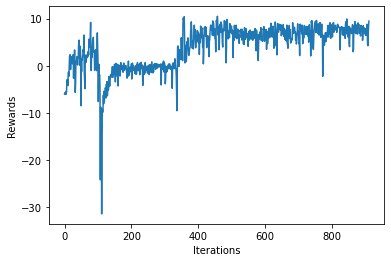

 91%|██████████████████████████████████████████████████████████████████▌      | 91102/100000 [2:45:15<16:08,  9.18it/s]

Updated Weights
Mean Reward = 8.82
5


 91%|██████████████████████████████████████████████████████████████████▌      | 91202/100000 [2:45:25<15:52,  9.24it/s]

Updated Weights
Mean Reward = 7.44
3


 91%|██████████████████████████████████████████████████████████████████▋      | 91302/100000 [2:45:35<15:51,  9.15it/s]

Updated Weights
Mean Reward = 7.94
10


 91%|██████████████████████████████████████████████████████████████████▋      | 91402/100000 [2:45:46<15:44,  9.10it/s]

Updated Weights
Mean Reward = 7.31
4


 92%|██████████████████████████████████████████████████████████████████▊      | 91500/100000 [2:45:56<15:34,  9.10it/s]

Updated Weights
Mean Reward = 7.72
9


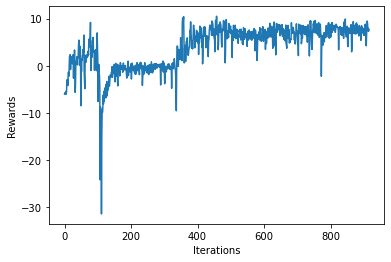

 92%|██████████████████████████████████████████████████████████████████▊      | 91602/100000 [2:46:06<14:58,  9.35it/s]

Updated Weights
Mean Reward = 7.49
7


 92%|██████████████████████████████████████████████████████████████████▉      | 91702/100000 [2:46:17<15:17,  9.04it/s]

Updated Weights
Mean Reward = 7.72
2


 92%|███████████████████████████████████████████████████████████████████      | 91802/100000 [2:46:27<14:08,  9.66it/s]

Updated Weights
Mean Reward = 5.9
10


 92%|███████████████████████████████████████████████████████████████████      | 91901/100000 [2:46:37<12:46, 10.57it/s]

Updated Weights
Mean Reward = 5.82
4


 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [2:46:48<13:05, 10.19it/s]

Updated Weights
Mean Reward = 7.81
2


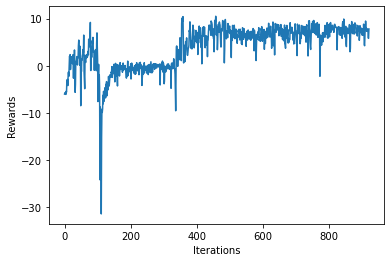

 92%|███████████████████████████████████████████████████████████████████▏     | 92102/100000 [2:46:58<13:29,  9.76it/s]

Updated Weights
Mean Reward = 7.13
8


 92%|███████████████████████████████████████████████████████████████████▎     | 92201/100000 [2:47:08<12:21, 10.52it/s]

Updated Weights
Mean Reward = 7.69
9


 92%|███████████████████████████████████████████████████████████████████▍     | 92302/100000 [2:47:19<14:03,  9.12it/s]

Updated Weights
Mean Reward = 7.69
8


 92%|███████████████████████████████████████████████████████████████████▍     | 92402/100000 [2:47:29<12:24, 10.20it/s]

Updated Weights
Mean Reward = 9.1
7


 92%|███████████████████████████████████████████████████████████████████▌     | 92499/100000 [2:47:39<10:31, 11.88it/s]

Updated Weights
Mean Reward = 6.82
7


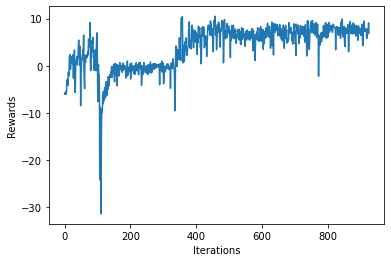

 93%|███████████████████████████████████████████████████████████████████▌     | 92601/100000 [2:47:50<12:15, 10.07it/s]

Updated Weights
Mean Reward = 6.53
7


 93%|███████████████████████████████████████████████████████████████████▋     | 92701/100000 [2:48:00<11:56, 10.19it/s]

Updated Weights
Mean Reward = 7.16
4


 93%|███████████████████████████████████████████████████████████████████▋     | 92802/100000 [2:48:10<13:19,  9.00it/s]

Updated Weights
Mean Reward = 5.25
6


 93%|███████████████████████████████████████████████████████████████████▊     | 92902/100000 [2:48:21<13:04,  9.05it/s]

Updated Weights
Mean Reward = 7.83
4


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [2:48:31<11:09, 10.45it/s]

Updated Weights
Mean Reward = 8.48
5


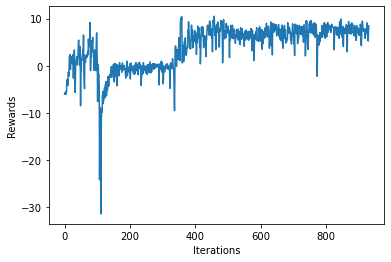

 93%|███████████████████████████████████████████████████████████████████▉     | 93102/100000 [2:48:42<13:08,  8.75it/s]

Updated Weights
Mean Reward = 8.07
6


 93%|████████████████████████████████████████████████████████████████████     | 93202/100000 [2:48:52<10:55, 10.38it/s]

Updated Weights
Mean Reward = 8.74
6


 93%|████████████████████████████████████████████████████████████████████     | 93301/100000 [2:49:03<12:15,  9.11it/s]

Updated Weights
Mean Reward = 7.98
2


 93%|████████████████████████████████████████████████████████████████████▏    | 93402/100000 [2:49:13<12:12,  9.01it/s]

Updated Weights
Mean Reward = 8.42
6


 94%|████████████████████████████████████████████████████████████████████▎    | 93500/100000 [2:49:24<12:18,  8.81it/s]

Updated Weights
Mean Reward = 8.87
2


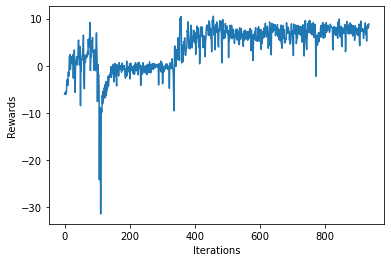

 94%|████████████████████████████████████████████████████████████████████▎    | 93602/100000 [2:49:35<11:20,  9.41it/s]

Updated Weights
Mean Reward = 6.45
4


 94%|████████████████████████████████████████████████████████████████████▍    | 93702/100000 [2:49:45<11:09,  9.40it/s]

Updated Weights
Mean Reward = 9.1
4


 94%|████████████████████████████████████████████████████████████████████▍    | 93802/100000 [2:49:56<11:09,  9.26it/s]

Updated Weights
Mean Reward = 8.38
1


 94%|████████████████████████████████████████████████████████████████████▌    | 93902/100000 [2:50:06<11:05,  9.16it/s]

Updated Weights
Mean Reward = 8.87
8


 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [2:50:16<10:40,  9.37it/s]

Updated Weights
Mean Reward = 5.86
7


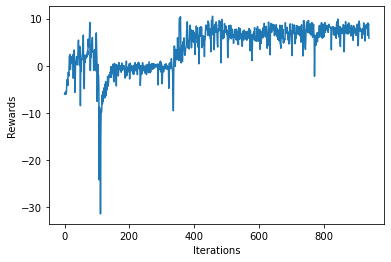

 94%|████████████████████████████████████████████████████████████████████▋    | 94102/100000 [2:50:26<10:12,  9.63it/s]

Updated Weights
Mean Reward = 8.33
8


 94%|████████████████████████████████████████████████████████████████████▊    | 94201/100000 [2:50:37<10:35,  9.13it/s]

Updated Weights
Mean Reward = 8.43
7


 94%|████████████████████████████████████████████████████████████████████▊    | 94302/100000 [2:50:48<10:21,  9.18it/s]

Updated Weights
Mean Reward = 5.92
3


 94%|████████████████████████████████████████████████████████████████████▉    | 94403/100000 [2:50:58<08:24, 11.08it/s]

Updated Weights
Mean Reward = 9.48
5


 94%|████████████████████████████████████████████████████████████████████▉    | 94500/100000 [2:51:08<10:02,  9.13it/s]

Updated Weights
Mean Reward = 8.13
10


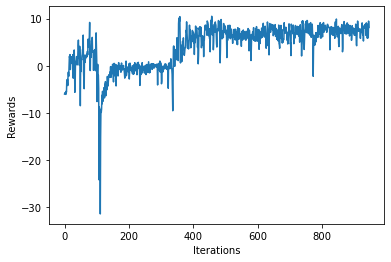

 95%|█████████████████████████████████████████████████████████████████████    | 94602/100000 [2:51:18<09:57,  9.03it/s]

Updated Weights
Mean Reward = 8.23
10


 95%|█████████████████████████████████████████████████████████████████████▏   | 94702/100000 [2:51:28<08:54,  9.91it/s]

Updated Weights
Mean Reward = 8.58
7


 95%|█████████████████████████████████████████████████████████████████████▏   | 94802/100000 [2:51:38<09:05,  9.53it/s]

Updated Weights
Mean Reward = 9.03
8


 95%|█████████████████████████████████████████████████████████████████████▎   | 94902/100000 [2:51:49<08:08, 10.43it/s]

Updated Weights
Mean Reward = 8.84
6


 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [2:51:59<08:54,  9.35it/s]

Updated Weights
Mean Reward = 7.87
5


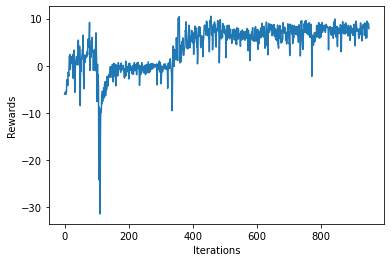

 95%|█████████████████████████████████████████████████████████████████████▍   | 95102/100000 [2:52:10<08:57,  9.11it/s]

Updated Weights
Mean Reward = 9.64
6


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [2:52:20<08:53,  8.99it/s]

Updated Weights
Mean Reward = 9.15
5


 95%|█████████████████████████████████████████████████████████████████████▌   | 95302/100000 [2:52:30<08:18,  9.42it/s]

Updated Weights
Mean Reward = 7.77
10


 95%|█████████████████████████████████████████████████████████████████████▋   | 95402/100000 [2:52:41<08:57,  8.55it/s]

Updated Weights
Mean Reward = 8.41
5


 96%|█████████████████████████████████████████████████████████████████████▋   | 95500/100000 [2:52:51<07:43,  9.70it/s]

Updated Weights
Mean Reward = 8.47
8


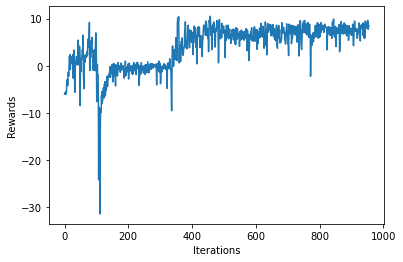

 96%|█████████████████████████████████████████████████████████████████████▊   | 95602/100000 [2:53:01<07:47,  9.40it/s]

Updated Weights
Mean Reward = 8.25
7


 96%|█████████████████████████████████████████████████████████████████████▊   | 95703/100000 [2:53:11<06:56, 10.32it/s]

Updated Weights
Mean Reward = 6.6
8


 96%|█████████████████████████████████████████████████████████████████████▉   | 95802/100000 [2:53:22<07:38,  9.16it/s]

Updated Weights
Mean Reward = 8.0
6


 96%|██████████████████████████████████████████████████████████████████████   | 95902/100000 [2:53:32<07:00,  9.74it/s]

Updated Weights
Mean Reward = 9.6
11


 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [2:53:42<06:26, 10.34it/s]

Updated Weights
Mean Reward = 8.51
3


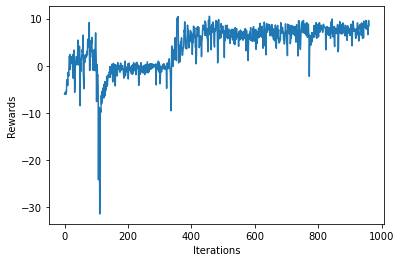

 96%|██████████████████████████████████████████████████████████████████████▏  | 96102/100000 [2:53:52<06:05, 10.65it/s]

Updated Weights
Mean Reward = 8.67
8


 96%|██████████████████████████████████████████████████████████████████████▏  | 96201/100000 [2:54:02<05:35, 11.31it/s]

Updated Weights
Mean Reward = 8.41
8


 96%|██████████████████████████████████████████████████████████████████████▎  | 96301/100000 [2:54:13<06:43,  9.16it/s]

Updated Weights
Mean Reward = 8.26
6


 96%|██████████████████████████████████████████████████████████████████████▎  | 96402/100000 [2:54:23<06:43,  8.92it/s]

Updated Weights
Mean Reward = 7.95
4


 96%|██████████████████████████████████████████████████████████████████████▍  | 96500/100000 [2:54:33<06:23,  9.13it/s]

Updated Weights
Mean Reward = 7.38
8


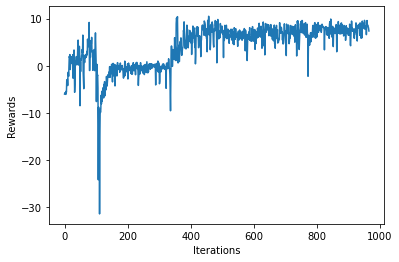

 97%|██████████████████████████████████████████████████████████████████████▌  | 96603/100000 [2:54:44<06:03,  9.33it/s]

Updated Weights
Mean Reward = 7.87
8


 97%|██████████████████████████████████████████████████████████████████████▌  | 96702/100000 [2:54:54<06:01,  9.13it/s]

Updated Weights
Mean Reward = 7.7
6


 97%|██████████████████████████████████████████████████████████████████████▋  | 96803/100000 [2:55:04<05:03, 10.54it/s]

Updated Weights
Mean Reward = 9.21
10


 97%|██████████████████████████████████████████████████████████████████████▋  | 96901/100000 [2:55:14<04:56, 10.44it/s]

Updated Weights
Mean Reward = 7.53
9


 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [2:55:24<05:26,  9.18it/s]

Updated Weights
Mean Reward = 7.6
9


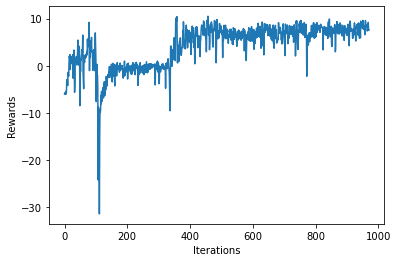

 97%|██████████████████████████████████████████████████████████████████████▉  | 97102/100000 [2:55:35<05:06,  9.46it/s]

Updated Weights
Mean Reward = 9.37
6


 97%|██████████████████████████████████████████████████████████████████████▉  | 97202/100000 [2:55:45<05:14,  8.91it/s]

Updated Weights
Mean Reward = 7.85
6


 97%|███████████████████████████████████████████████████████████████████████  | 97302/100000 [2:55:55<04:36,  9.77it/s]

Updated Weights
Mean Reward = 7.7
12


 97%|███████████████████████████████████████████████████████████████████████  | 97401/100000 [2:56:05<04:41,  9.23it/s]

Updated Weights
Mean Reward = 9.16
6


 98%|███████████████████████████████████████████████████████████████████████▏ | 97500/100000 [2:56:15<03:42, 11.21it/s]

Updated Weights
Mean Reward = 9.03
6


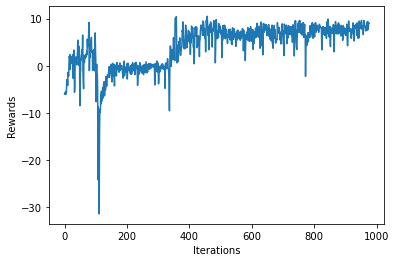

 98%|███████████████████████████████████████████████████████████████████████▏ | 97602/100000 [2:56:26<04:01,  9.93it/s]

Updated Weights
Mean Reward = 9.28
4


 98%|███████████████████████████████████████████████████████████████████████▎ | 97702/100000 [2:56:36<04:01,  9.50it/s]

Updated Weights
Mean Reward = 9.6
6


 98%|███████████████████████████████████████████████████████████████████████▍ | 97802/100000 [2:56:47<04:01,  9.11it/s]

Updated Weights
Mean Reward = 7.72
4


 98%|███████████████████████████████████████████████████████████████████████▍ | 97901/100000 [2:56:57<03:17, 10.61it/s]

Updated Weights
Mean Reward = 8.34
13


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [2:57:06<03:04, 10.84it/s]

Updated Weights
Mean Reward = 5.85
13


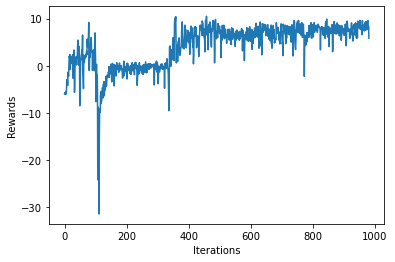

 98%|███████████████████████████████████████████████████████████████████████▌ | 98102/100000 [2:57:17<03:10,  9.98it/s]

Updated Weights
Mean Reward = 6.58
4


 98%|███████████████████████████████████████████████████████████████████████▋ | 98203/100000 [2:57:27<02:39, 11.27it/s]

Updated Weights
Mean Reward = 7.41
6


 98%|███████████████████████████████████████████████████████████████████████▊ | 98302/100000 [2:57:37<02:58,  9.51it/s]

Updated Weights
Mean Reward = 8.8
6


 98%|███████████████████████████████████████████████████████████████████████▊ | 98403/100000 [2:57:47<02:24, 11.07it/s]

Updated Weights
Mean Reward = 8.72
10


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [2:57:58<02:43,  9.18it/s]

Updated Weights
Mean Reward = 8.97
4


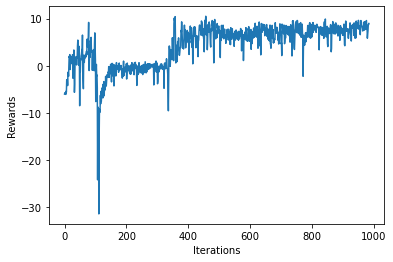

 99%|███████████████████████████████████████████████████████████████████████▉ | 98601/100000 [2:58:08<02:21,  9.86it/s]

Updated Weights
Mean Reward = 7.66
11


 99%|████████████████████████████████████████████████████████████████████████ | 98702/100000 [2:58:18<02:22,  9.11it/s]

Updated Weights
Mean Reward = 6.72
5


 99%|████████████████████████████████████████████████████████████████████████▏| 98802/100000 [2:58:28<02:02,  9.75it/s]

Updated Weights
Mean Reward = 1.61
6


 99%|████████████████████████████████████████████████████████████████████████▏| 98902/100000 [2:58:39<01:58,  9.30it/s]

Updated Weights
Mean Reward = 6.63
7


 99%|████████████████████████████████████████████████████████████████████████▎| 98999/100000 [2:58:49<01:51,  9.00it/s]

Updated Weights
Mean Reward = 4.86
4


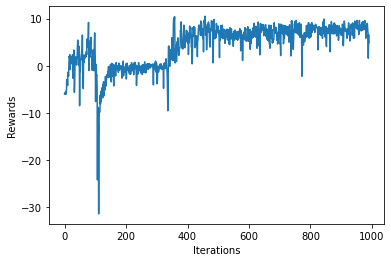

 99%|████████████████████████████████████████████████████████████████████████▎| 99102/100000 [2:59:00<01:40,  8.90it/s]

Updated Weights
Mean Reward = 7.71
8


 99%|████████████████████████████████████████████████████████████████████████▍| 99202/100000 [2:59:09<01:26,  9.26it/s]

Updated Weights
Mean Reward = 7.76
11


 99%|████████████████████████████████████████████████████████████████████████▍| 99303/100000 [2:59:20<00:57, 12.12it/s]

Updated Weights
Mean Reward = 7.87
8


 99%|████████████████████████████████████████████████████████████████████████▌| 99401/100000 [2:59:30<01:05,  9.15it/s]

Updated Weights
Mean Reward = 7.89
8


100%|████████████████████████████████████████████████████████████████████████▋| 99500/100000 [2:59:40<00:53,  9.33it/s]

Updated Weights
Mean Reward = 8.13
7


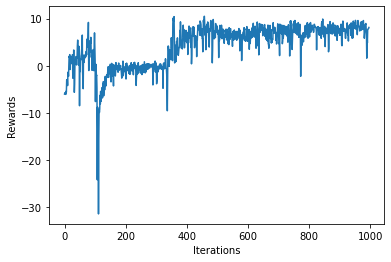

100%|████████████████████████████████████████████████████████████████████████▋| 99602/100000 [2:59:50<00:43,  9.07it/s]

Updated Weights
Mean Reward = 8.54
6


100%|████████████████████████████████████████████████████████████████████████▊| 99701/100000 [3:00:00<00:29, 10.09it/s]

Updated Weights
Mean Reward = 9.54
8


100%|████████████████████████████████████████████████████████████████████████▊| 99802/100000 [3:00:10<00:17, 11.21it/s]

Updated Weights
Mean Reward = 9.81
9


100%|████████████████████████████████████████████████████████████████████████▉| 99902/100000 [3:00:21<00:10,  9.67it/s]

Updated Weights
Mean Reward = 9.98
6


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [3:00:30<00:00,  9.23it/s]


In [5]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%250==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [10]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1

[0.1 0.8 0.4 0.2]
[0.1 0.6 0.4 0.2]
[0.1 0.4 0.4 0.2]
[0.1 0.2 0.4 0.2]
[1.00000000e-01 5.55111512e-17 4.00000000e-01 2.00000000e-01]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]
[0.1 0.  0.4 0.2]
[0.1 0.1 0.4 0.2]


In [9]:
print(done)

0
